# UTKFace Age Prediction

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# setting random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(device)

cuda


In [3]:
# Extracting the data from the files
DIR_PATH = "/scratch/storage0/be20b032/Feature-Sieve-for-RL/UTKFace/Data/UTKFace"

data = {}
data['image'] = []
data['age'] = []
data['gender'] = []
data['ethinicity'] = []

for filename in os.listdir(DIR_PATH):
  f = os.path.join(DIR_PATH, filename)
  d = filename.split("_")

  if os.path.isfile(f) and len(d) == 4:
    data['image'].append(f)
    data['age'].append(int(d[0]))
    data['gender'].append(int(d[1]))
    data['ethinicity'].append(int(d[2]))

# Creating a dataframe to store the images and corresponding attributes
data_df = pd.DataFrame(data)
data_df.to_csv("./Data/data.csv")
TOTAL_PTS = len(data_df)
print(f"Total Data Pts: {TOTAL_PTS}")
data_df.head()

Total Data Pts: 23705


image  age  gender  ethinicity
0  /scratch/storage0/be20b032/Feature-Sieve-for-R...   28       0           3
1  /scratch/storage0/be20b032/Feature-Sieve-for-R...   90       0           0
2  /scratch/storage0/be20b032/Feature-Sieve-for-R...   25       0           1
3  /scratch/storage0/be20b032/Feature-Sieve-for-R...   36       1           1
4  /scratch/storage0/be20b032/Feature-Sieve-for-R...    1       1           2

In [4]:
#Paths
DIR_PATH = "/scratch/storage0/be20b032/Feature_Sieve-for-RL/UTKFace/Data/UTKFace"
DATA_PATH = './Data/data.csv'

#loading the dataset
data_df = pd.read_csv(DATA_PATH)
TOTAL_PTS = len(data_df)

# Spliting the dataset
TRAIN_PTS = int(0.6 * TOTAL_PTS)
TEST_PTS = int(0.2 *  TOTAL_PTS)

#Shuffling the Dataframe
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.drop("Unnamed: 0", axis = 1)

train_df = data_df[:TRAIN_PTS].reset_index(drop=True)
test_df = data_df[TRAIN_PTS: TRAIN_PTS + TEST_PTS].reset_index(drop=True)
val_df = data_df[TRAIN_PTS + TEST_PTS: ].reset_index(drop=True)

print(f"Number of Total Data Points: {len(data_df)}")
print(f"Number of Training Data Points: {len(train_df)}")
print(f"Number of Test Data Points: {len(test_df)}")
print(f"Number of Validation Data Points: {len(val_df)}")

Number of Total Data Points: 23705
Number of Training Data Points: 14223
Number of Test Data Points: 4741
Number of Validation Data Points: 4741


## Custom Dataset

In [5]:
# Custom Dataset
class UTKFaceDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform=None):
    self.image_dir = image_dir
    self.df = dataframe
    self.images = dataframe['image'].values
    self.y = dataframe['age'].values
    self.gender = dataframe['gender'].values
    self.eth = dataframe['ethinicity'].values
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.images[index])

    if self.transform is not None:
      img = self.transform(img)

    label = self.y[index]
    gender = self.gender[index]
    return img, label, gender

  def __len__(self):
    return self.y.shape[0]

In [6]:
#Seggregating male and female data points for biasing
male_df = train_df[train_df['gender'] == 0].reset_index(drop=True)
female_df = train_df[train_df['gender'] == 1].reset_index(drop=True)

print(f"Male data pts: {len(male_df)}")
print(f"Female data pts: {len(female_df)}")

Male data pts: 7419
Female data pts: 6804


In [7]:
print(male_df.age.values.mean())
print(female_df.age.values.mean())

35.566114031540636
30.674309229864786


<Axes: >

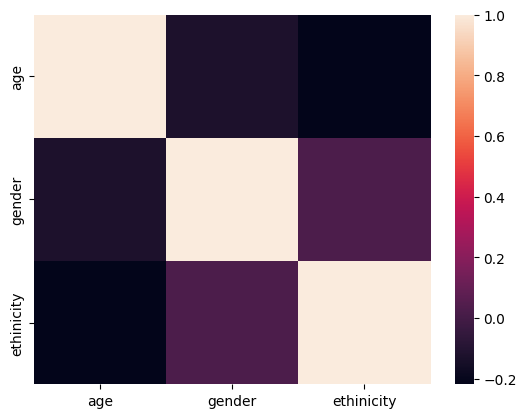

In [8]:
corr_df = data_df.drop("image", axis = 1)
sns.heatmap(corr_df.corr())

## Dataset Generation 1

In [9]:
# Creating dataframes
ages = list(data_df.age.unique())
ages = sorted(ages)

def dataframe(male_df, female_df, total_datapts = 5000, percent = 0.5, thresh = 50, old = "male"):
  MALE_POP = int(percent * total_datapts)
  FEMALE_POP = int((1-percent) * total_datapts)
  print(MALE_POP, FEMALE_POP)

  if old == "male":
    male_datapts = male_df[male_df["age"] > thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] < thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]



  else:
    male_datapts = male_df[male_df["age"] < thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] > thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]

  print(f"Male Population: {len(male_datapts)}/{len(male_datapts) + len(female_datapts)}; Female Population: {len(female_datapts)}/{len(male_datapts) + len(female_datapts)}")
  datapts = [male_datapts, female_datapts]
  datapts = pd.concat(datapts)
  datapts = datapts.sample(frac=1).reset_index(drop=True)
  return datapts

2500 2500
5547 2424
Male Population: 2500/5000; Female Population: 2500/5000


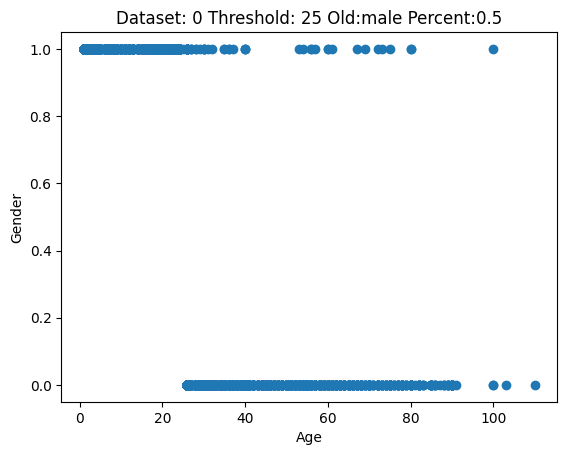

2500 2500
1278 5211
Male Population: 2500/5000; Female Population: 2500/5000


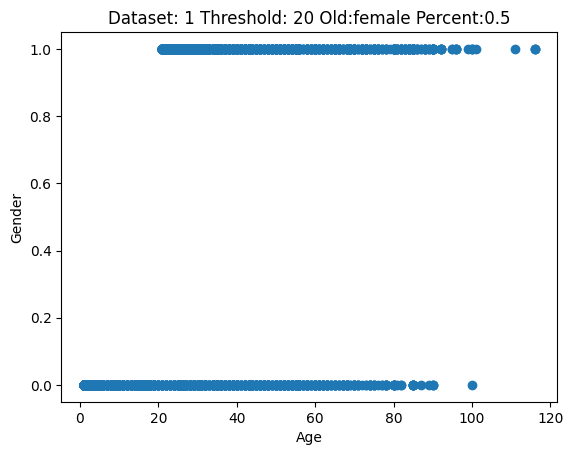

2500 2500
5856 1891
Male Population: 2500/5000; Female Population: 2500/5000


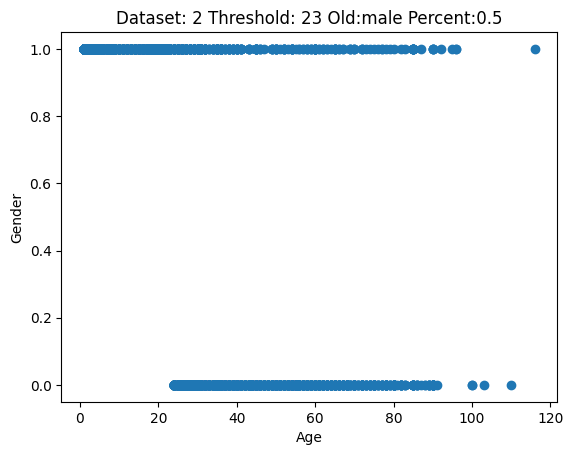

3500 1500
1483 4755
Male Population: 3500/5000; Female Population: 1500/5000


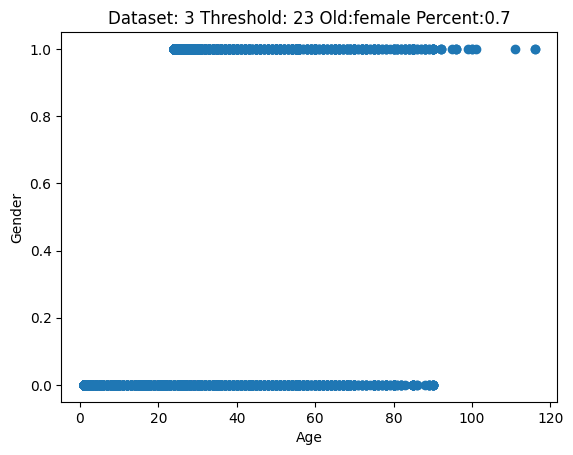

4000 999
5547 2424
Male Population: 4000/4999; Female Population: 999/4999


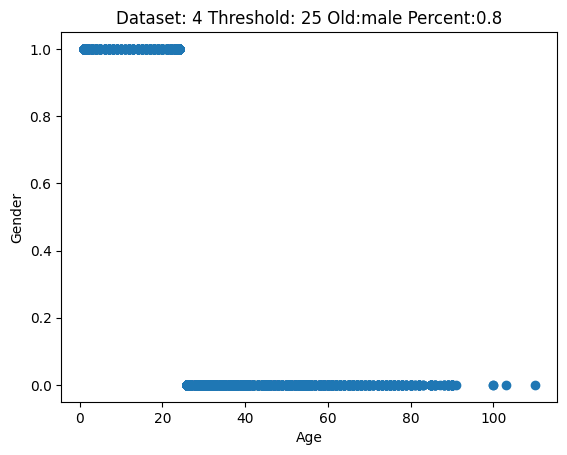

1000 4000
2464 3181
Male Population: 1000/5000; Female Population: 4000/5000


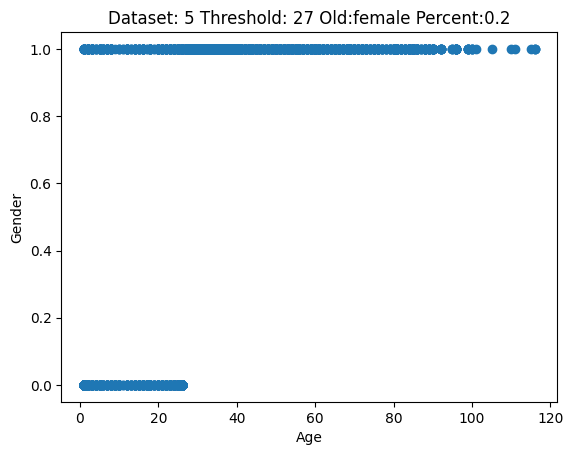

1500 3500
2833 5238
Male Population: 1500/5000; Female Population: 3500/5000


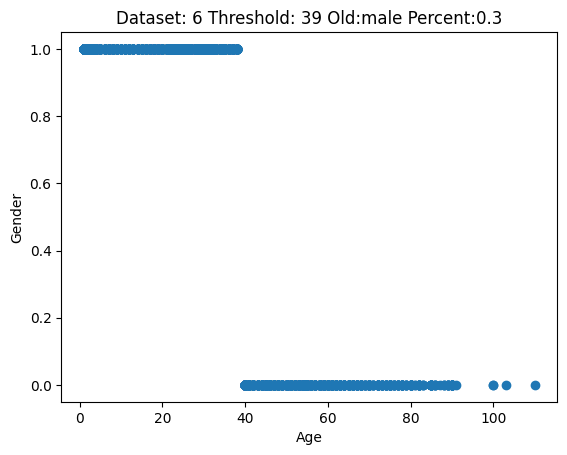

2500 2500
4841 1310
Male Population: 2500/5000; Female Population: 2500/5000


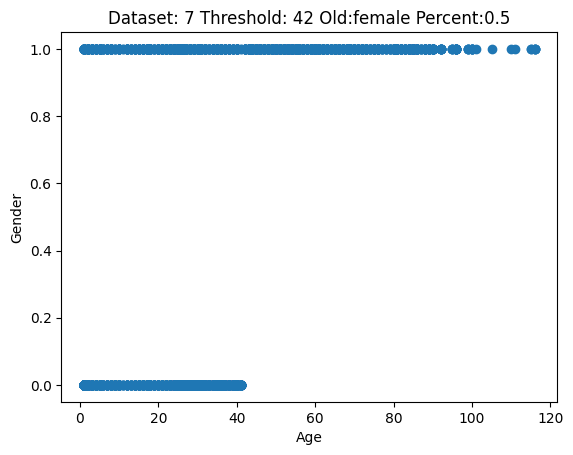

4000 999
2467 5437
Male Population: 4000/4999; Female Population: 999/4999


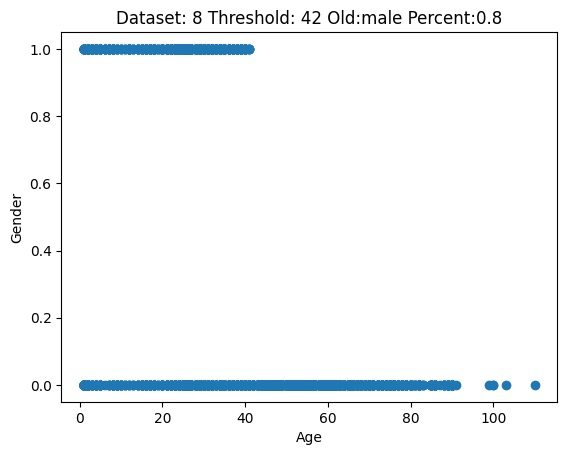

2000 3000
3096 2509
Male Population: 2000/5000; Female Population: 3000/5000


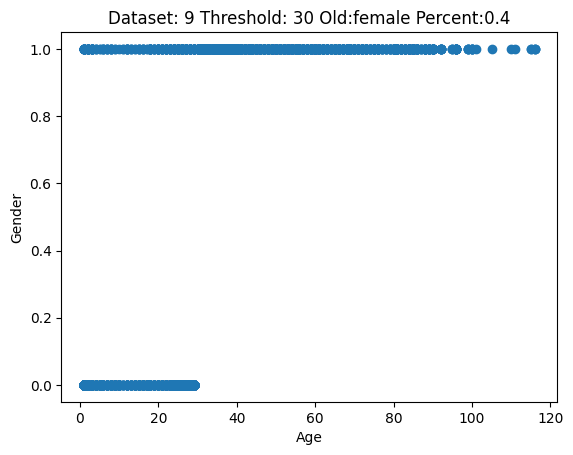

In [10]:
#Creating Datasets using Gen1 Dataframe
threshs = [25, 20, 23, 23, 25, 27, 39, 42, 42, 30]
olds = ["male", "female", "male", "female", "male", "female", 'male', 'female', 'male', 'female']
percents = [0.5, 0.5, 0.5, 0.7, 0.8, 0.2, 0.3, 0.5, 0.8, 0.4]
dfs = []

for i in range(len(threshs)):
    df = dataframe(male_df, female_df, thresh=threshs[i], old=olds[i], percent=percents[i])
    dfs.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Threshold: {threshs[i]} Old:{olds[i]} Percent:{percents[i]}")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.savefig(f"./Datasets/Gen1/Dataset{i}.png")
    plt.show()

# Dataset Generation 2

In [11]:
#Creating Dataframes using normal distribution
def dataframe_gen2(male_df, female_df, percent, male_mean, female_mean, male_var, female_var, total_datapts=5000):
    MALE_POP = int(percent * total_datapts)
    FEMALE_POP = int((1-percent) * total_datapts)
    print(MALE_POP, FEMALE_POP)

    male_age = np.sort(male_df.age)
    male_fx = np.exp(-1*(male_age - male_mean)**2 / (2*male_var)) / np.sqrt(2*np.pi*male_var)
    male_sample_probs = male_fx 

    female_age = np.sort(female_df.age)
    female_fx = np.exp(-1*(female_age - female_mean)**2 / (2*female_var)) / np.sqrt(2*np.pi*female_var)
    female_sample_probs = female_fx

    female_df_sorted = female_df.sort_values("age")
    male_df_sorted = male_df.sort_values("age")
    female_datapts = female_df_sorted.sample(n=FEMALE_POP, weights=female_sample_probs, replace=False)
    male_datapts = male_df_sorted.sample(n=MALE_POP, weights=male_sample_probs, replace=False)

    df = [male_datapts, female_datapts]
    df = pd.concat(df)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

3000 2000
24.482
44.0505
image         5000
age             64
gender           2
ethinicity       5
dtype: int64


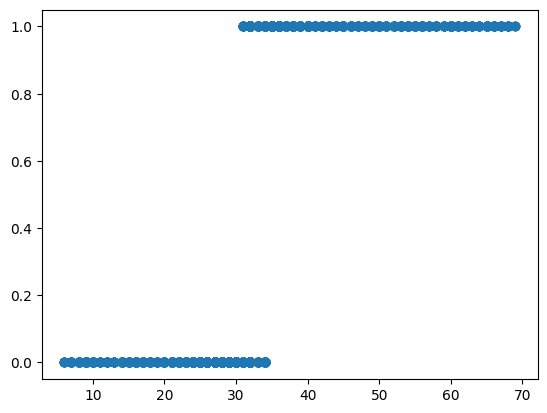

In [12]:
# Testing Dataset Gen2
dataset_1 = dataframe_gen2(male_df, female_df, percent=0.6, male_mean=20, female_mean=50, male_var=1, female_var=1)
dataset_1_male = dataset_1[dataset_1["gender"]==0]
dataset_1_female = dataset_1[dataset_1["gender"]==1]
print(dataset_1_male.age.values.mean())
print(dataset_1_female.age.values.mean())

print(dataset_1.nunique())
plt.scatter(dataset_1.age.values, dataset_1.gender.values)
plt.show()

4000 999


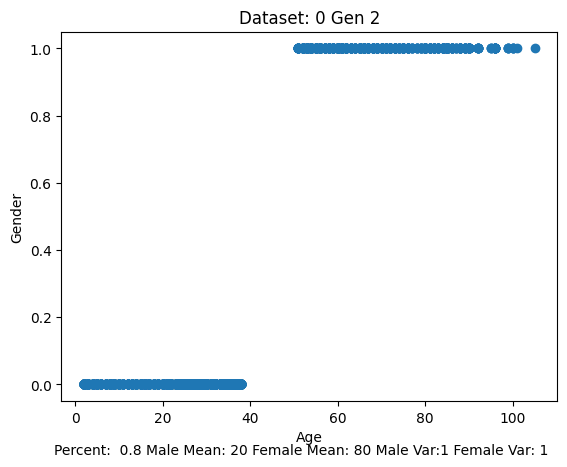

2500 2500


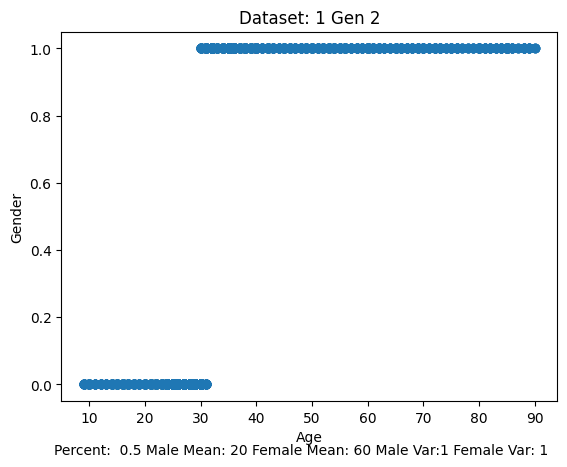

3000 2000


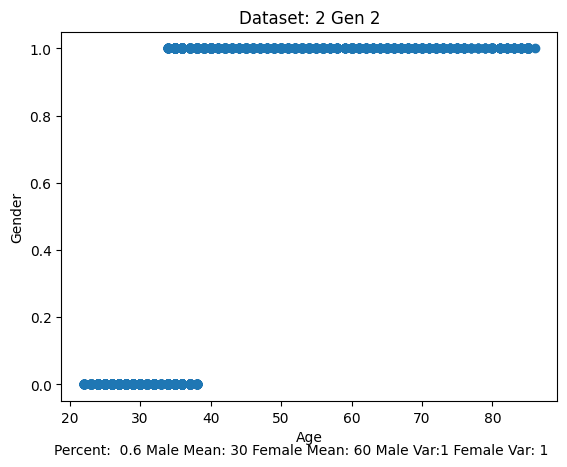

2500 2500


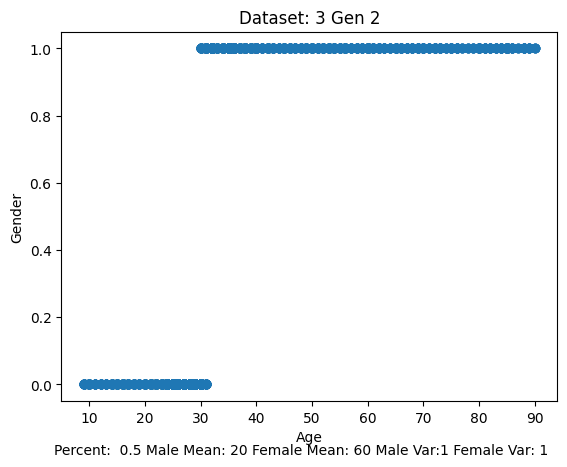

2000 3000


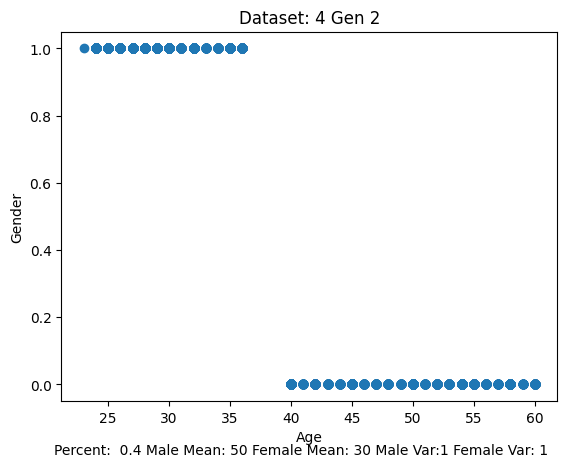

2000 3000


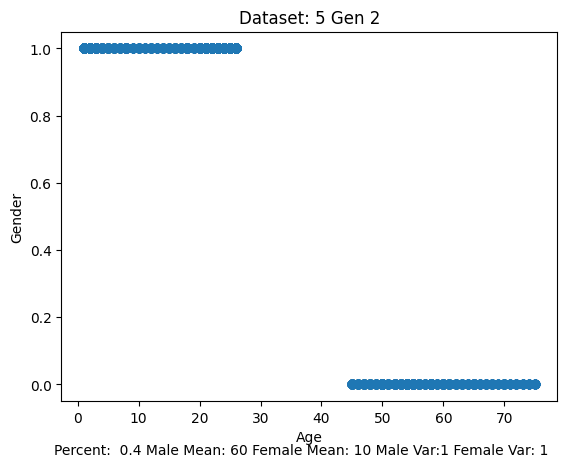

4000 999


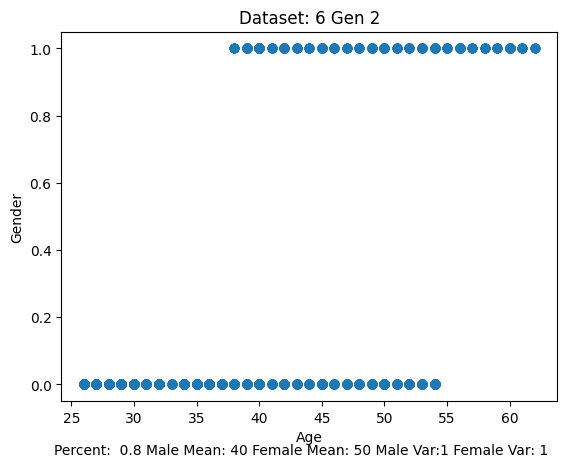

4000 999


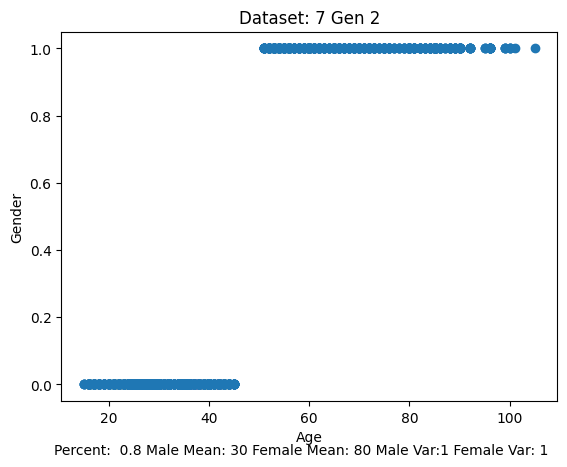

1000 4000


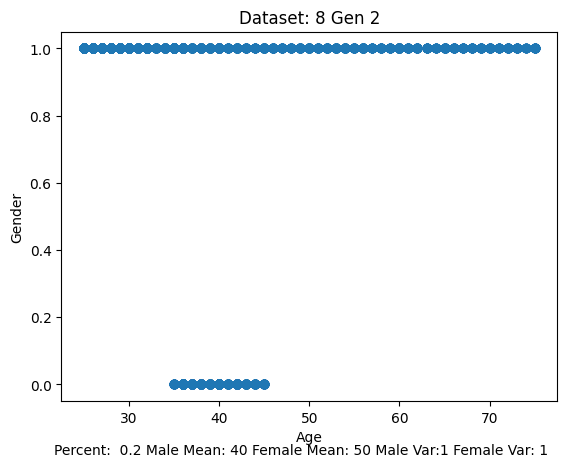

3000 2000


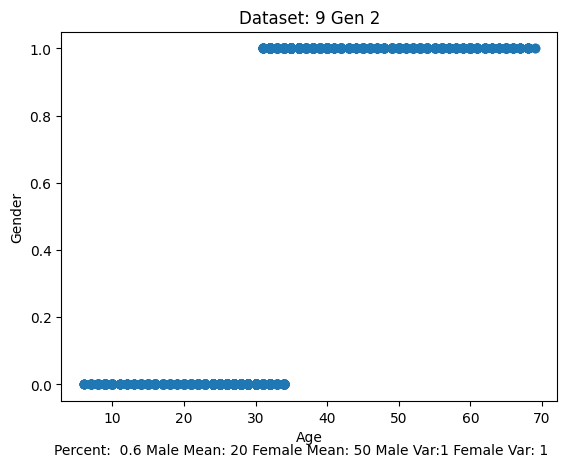

In [13]:
#Creating Dataframes using Gen2
percents = [0.8, 0.5, 0.6, 0.5, 0.4, 0.4, 0.8, 0.8, 0.2, 0.6]
male_means = [20, 20, 30, 20, 50, 60, 40, 30, 40, 20]
female_means = [80, 60, 60, 60, 30, 10, 50, 80, 50, 50]
male_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
female_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

dfs_gen2 = []
for i in range(len(percents)):
    df = dataframe_gen2(male_df, female_df, percent=percents[i], male_mean=male_means[i], female_mean=female_means[i], male_var=male_vars[i], female_var=female_vars[i])
    dfs_gen2.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Gen 2")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.figtext(0.5, 0.0001, f"Percent:  {percents[i]} Male Mean: {male_means[i]} Female Mean: {female_means[i]} Male Var:{male_vars[i]} Female Var: {female_vars[i]}", wrap=True, horizontalalignment='center', fontsize=10)
    plt.savefig(f"./Datasets/Gen2/Dataset{i}.png")
    plt.show()

## Datasets and Dataloaders

In [14]:
# Datasets and Dataloaders
##Datasets
NUM_TRAIN_DATASETS = len(threshs)
BATCH_SIZE = 128

custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

test_dataset = UTKFaceDataset(dataframe = test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

val_dataset = UTKFaceDataset(dataframe = val_df,
                             image_dir = DIR_PATH,
                             transform = custom_transform)
train_datasets = []
train_dataloaders = []
for i in range(NUM_TRAIN_DATASETS):
  train_dataset = UTKFaceDataset(dataframe = dfs_gen2[i],
                                 image_dir= DIR_PATH,
                                 transform = custom_transform)

  train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

  train_dataloaders.append(train_dataloader)
  train_datasets.append(train_dataset)

##Dataloaders
test_dataloader = DataLoader(dataset = test_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True)

## Dataset Visualization

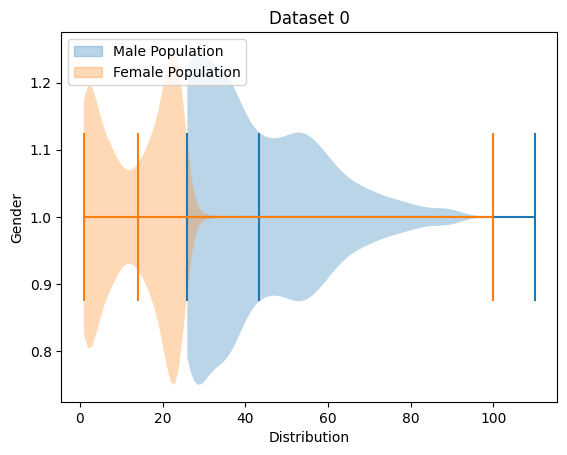

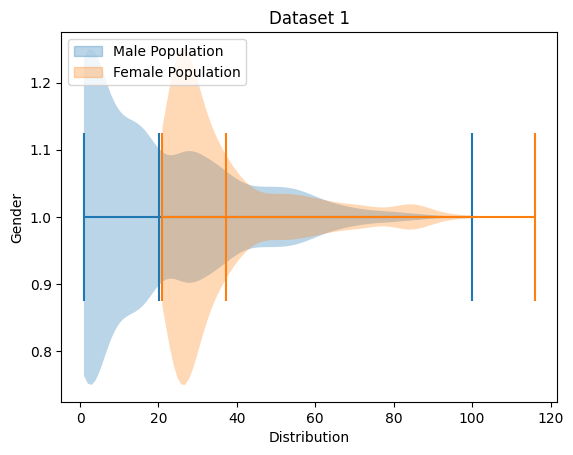

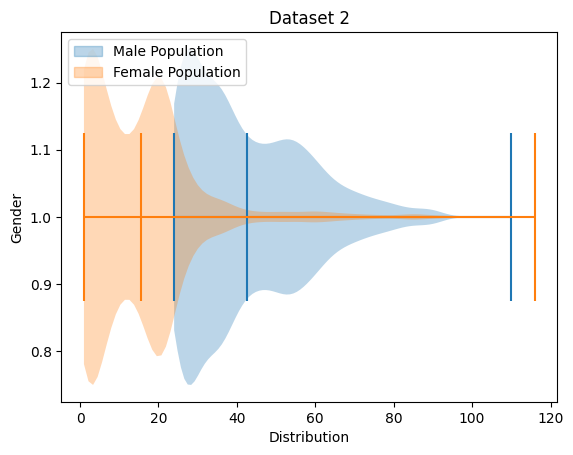

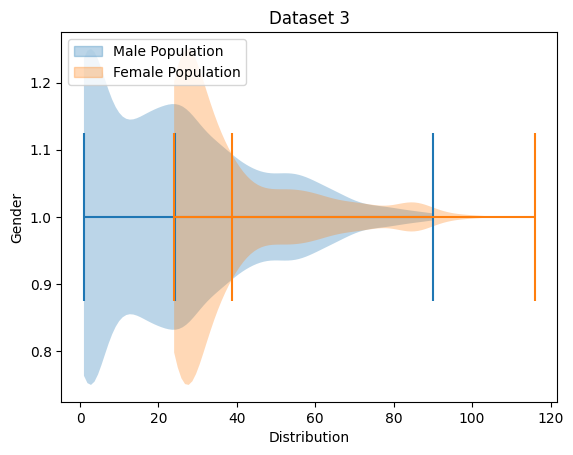

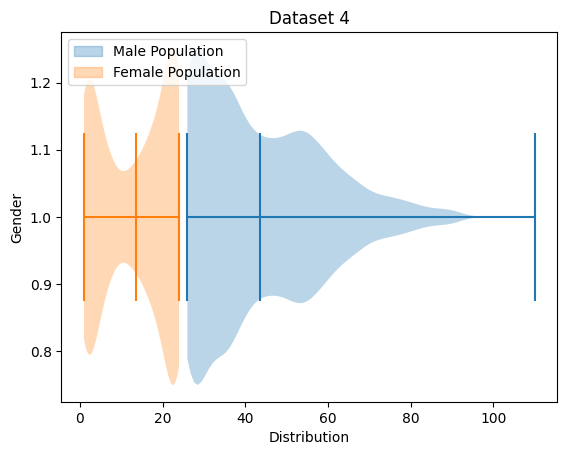

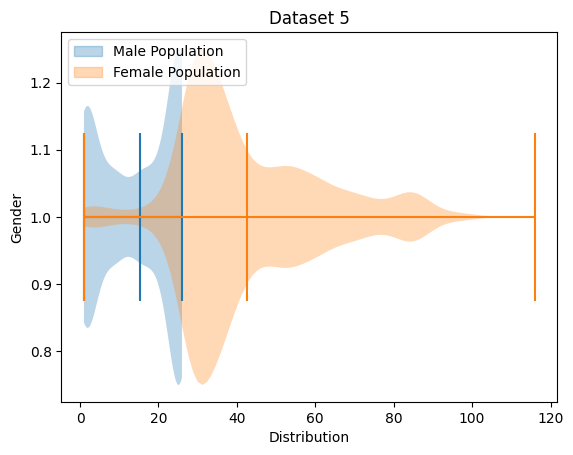

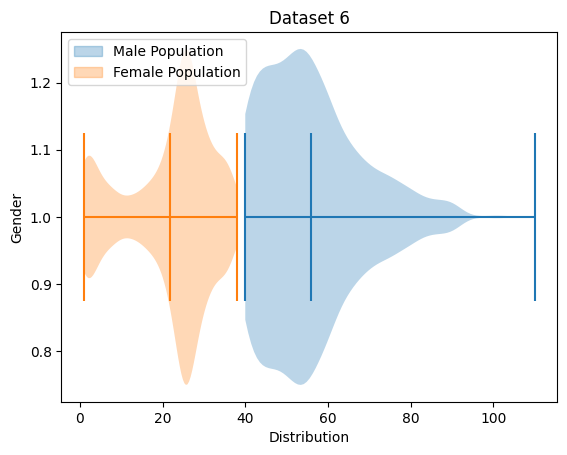

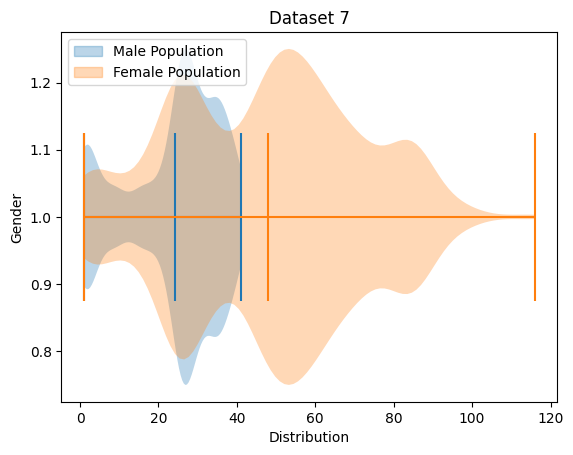

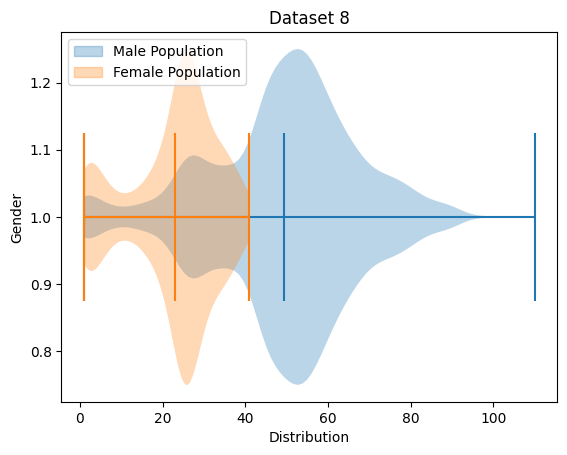

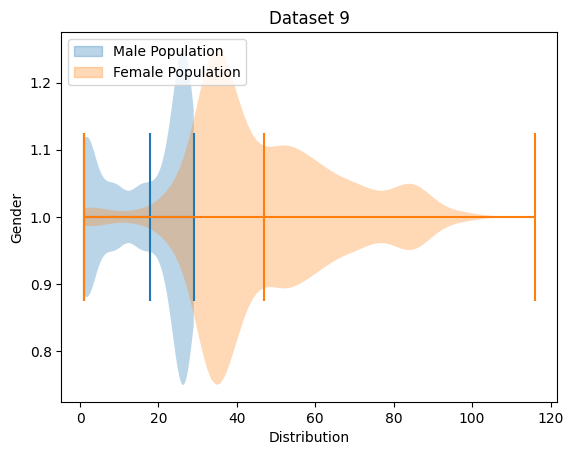

In [15]:
## Dataset Gen1 
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color = color), label))

for i in range(len(dfs)):
    labels  = []
    df = dfs[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Population")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen1/dataset_dist{i}.png")
    plt.show()

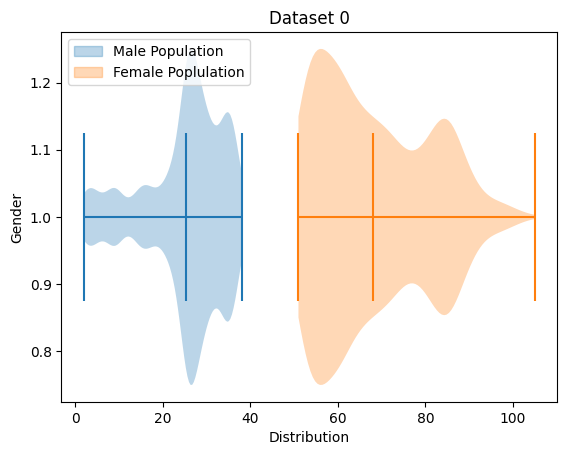

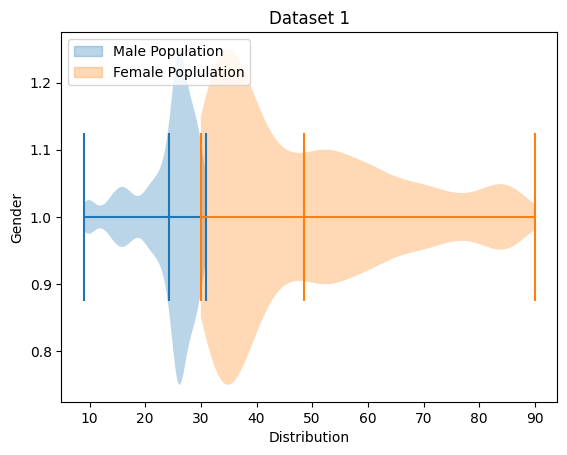

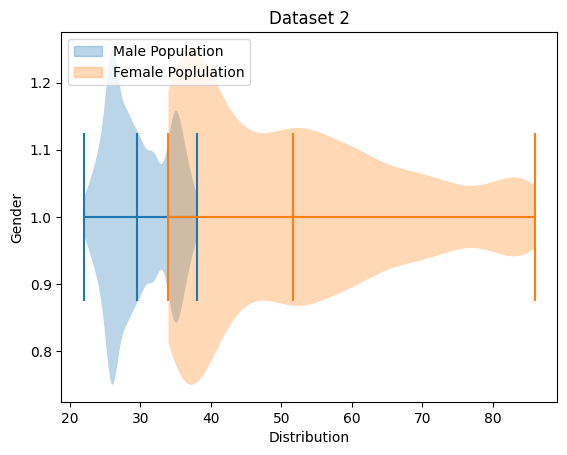

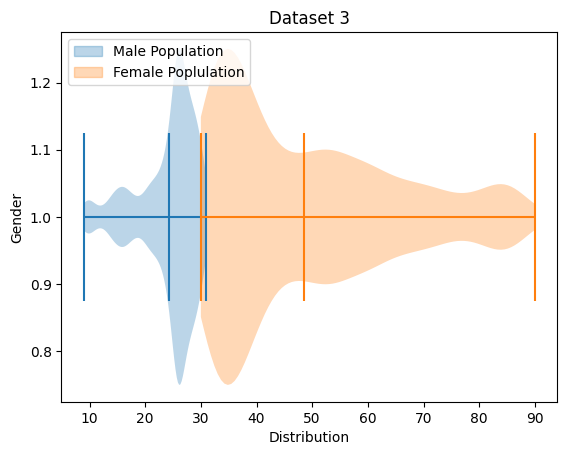

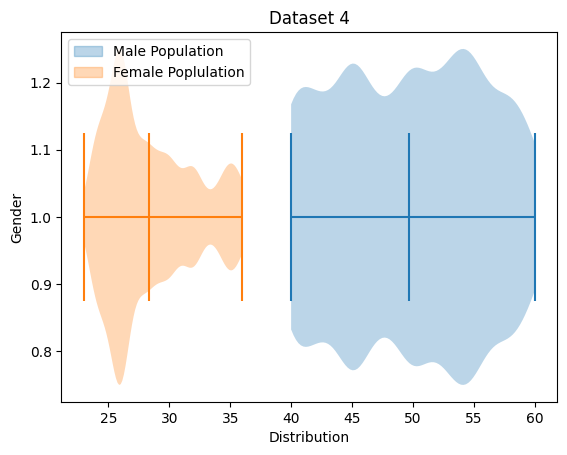

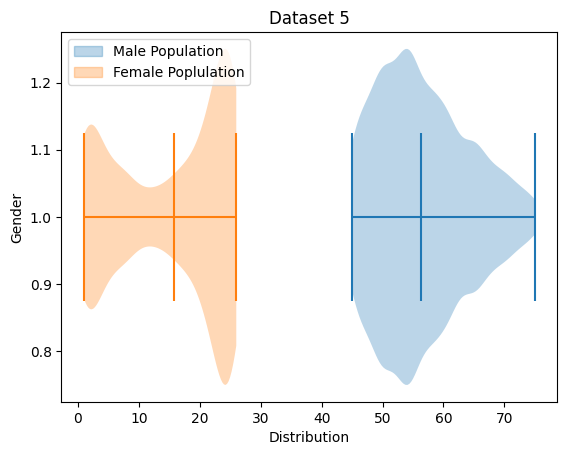

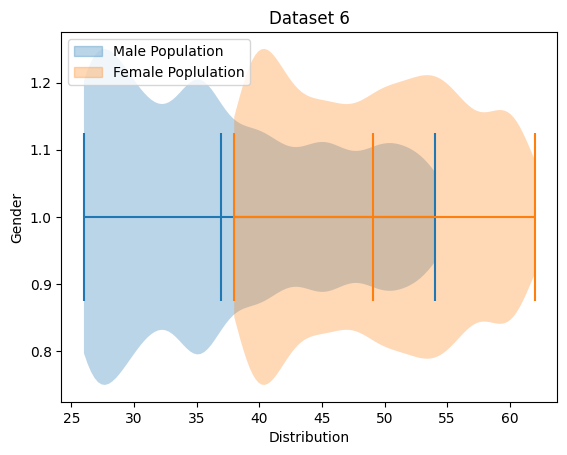

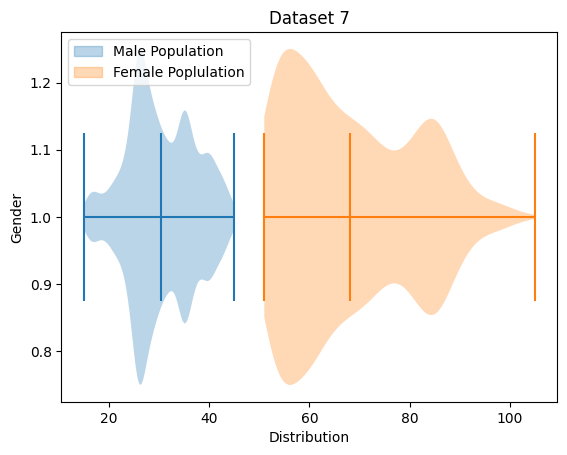

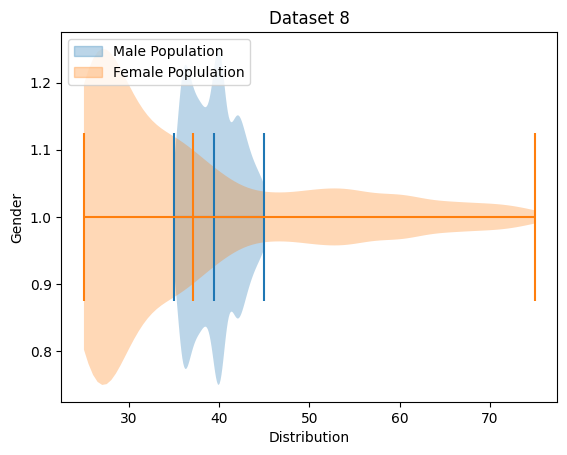

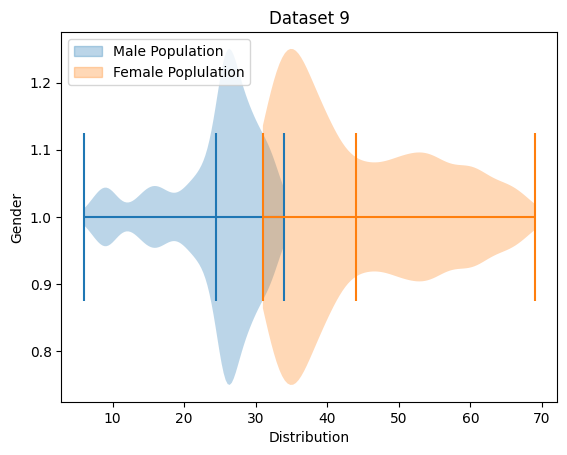

In [16]:
# Dataset Gen 2
for i in range(len(dfs_gen2)):
    labels = []
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Poplulation")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen2/dataset_dist{i}.png")
    plt.show()

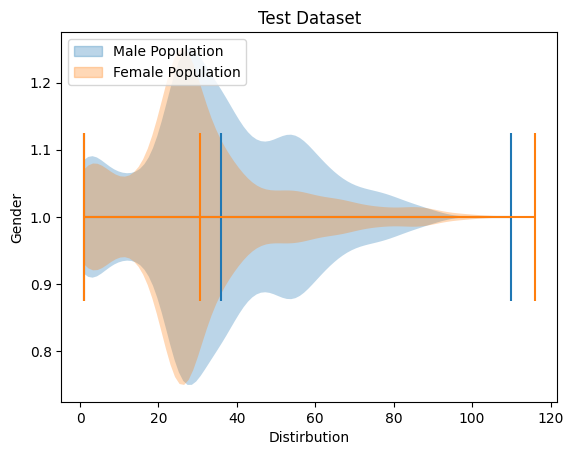

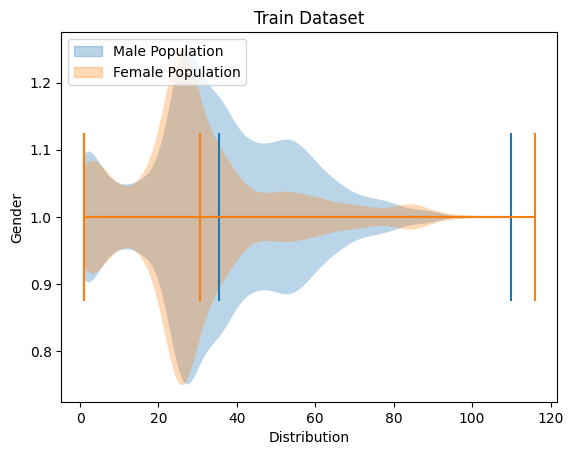

In [17]:
#Plotting distribution of test dataset
labels = []
male_test_df = test_df[test_df.gender == 0].age.values
female_test_df = test_df[test_df.gender == 1].age.values
add_label(plt.violinplot(male_test_df, vert = False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_test_df, vert = False, showmeans = True), "Female Population")
plt.xlabel("Distirbution")
plt.ylabel("Gender")
plt.title("Test Dataset")
plt.legend(*zip(*labels), loc = 2)
plt.savefig("./Datasets/test_distribution.png")
plt.show()

labels = []
male_train_df = train_df[train_df.gender == 0].age.values
female_train_df = train_df[train_df.gender == 1].age.values
add_label(plt.violinplot(male_train_df, vert=False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_train_df, vert = False, showmeans= True), "Female Population")
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.legend(*zip(*labels), loc = 2)
plt.title("Train Dataset")
plt.savefig("./Datasets/train_distribution.png")
plt.show()

## Correlation Analysis

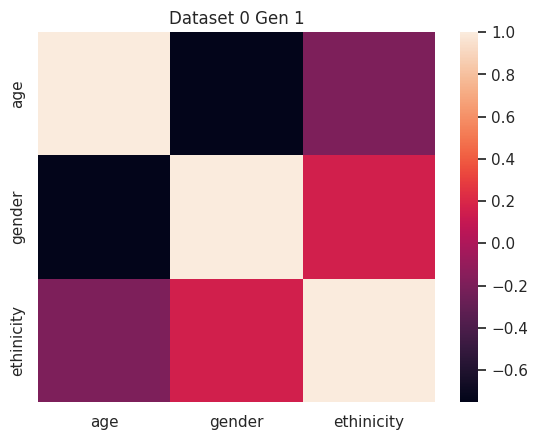

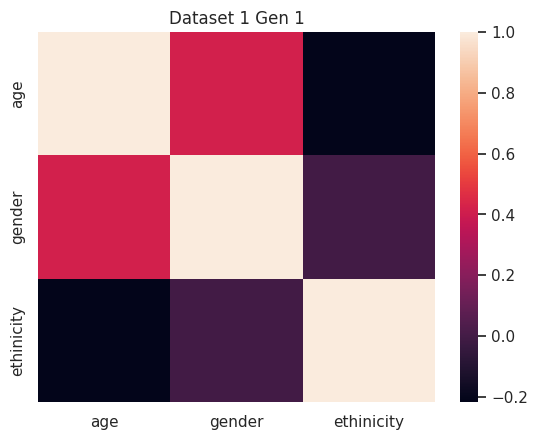

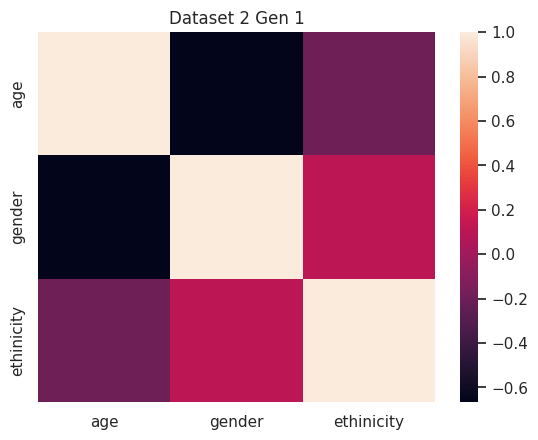

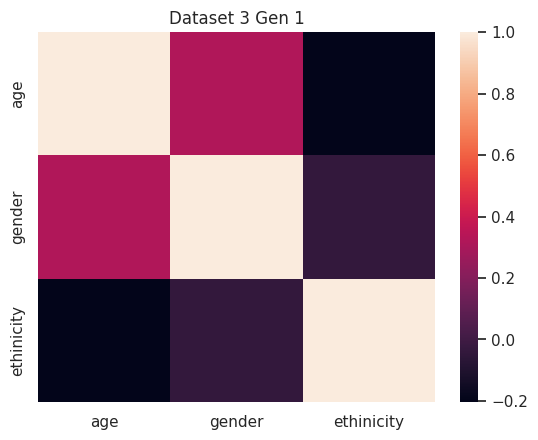

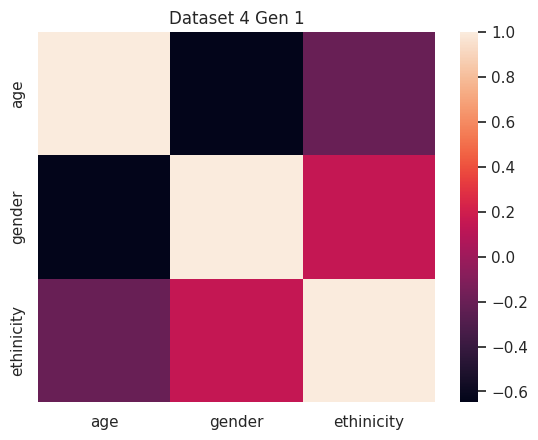

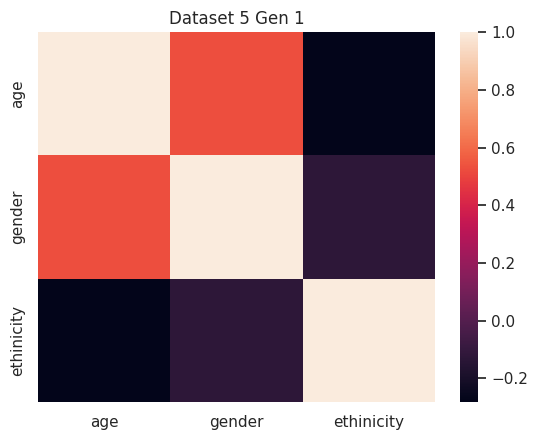

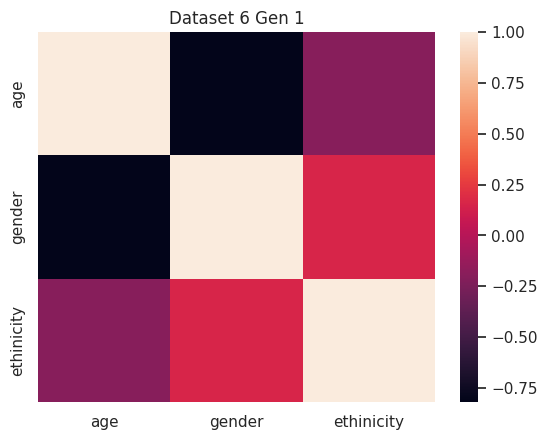

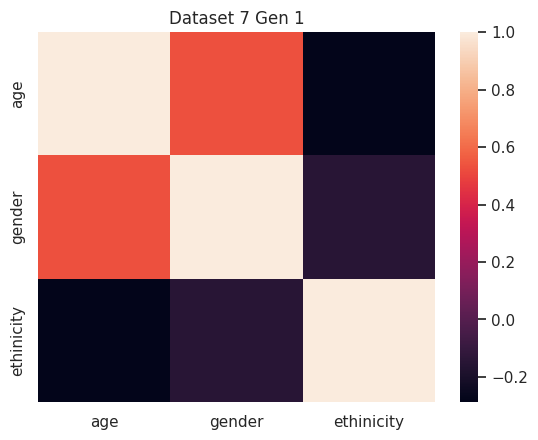

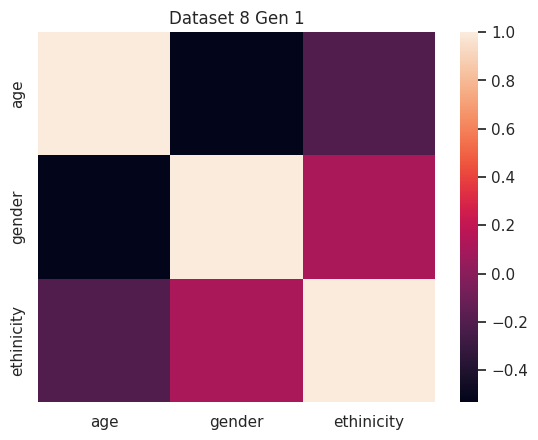

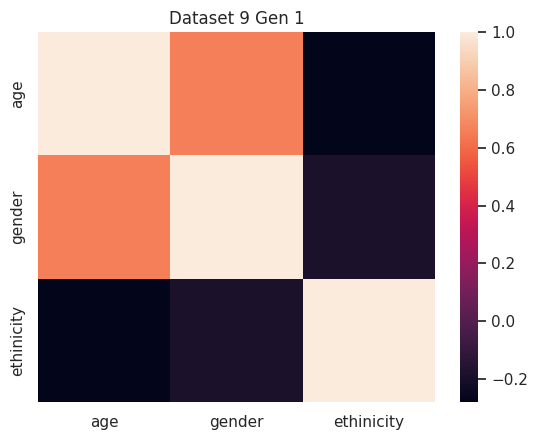

In [21]:
sns.set()
for i in range(len(dfs)):
    df = dfs[i]
    sns_plot = sns.heatmap(df.drop("image", axis = 1).corr()).set(title = f"Dataset {i} Gen 1")
    plt.savefig(f"./Datasets/Correlations_Gen1/Dataset{i}.png")
    plt.show()

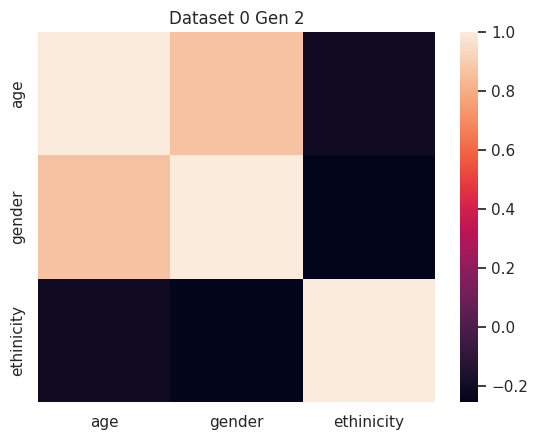

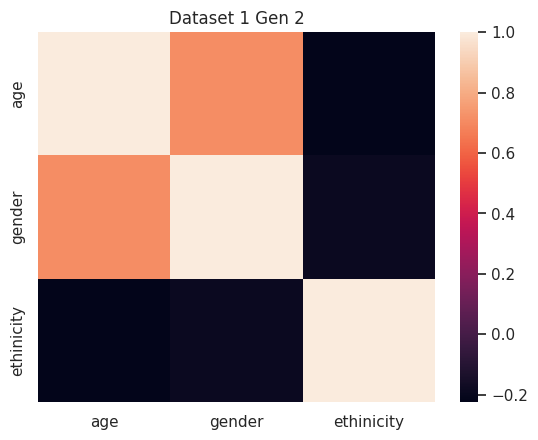

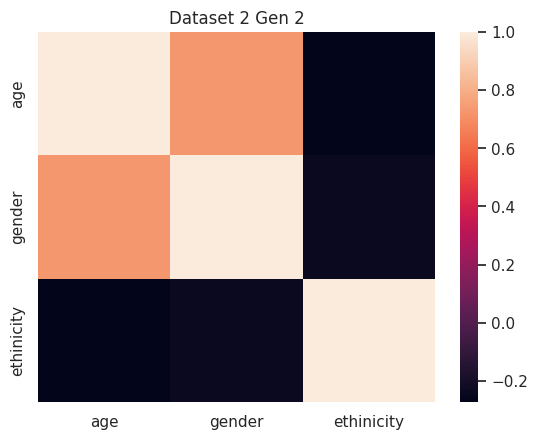

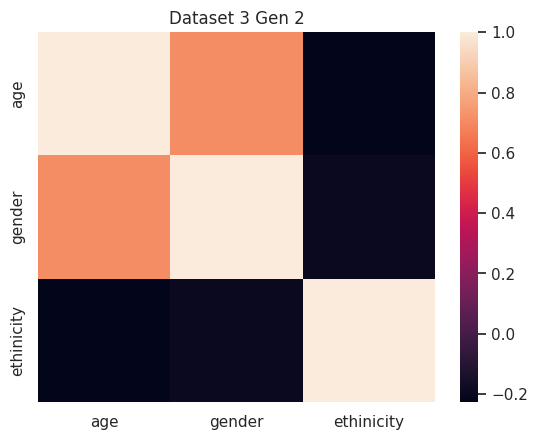

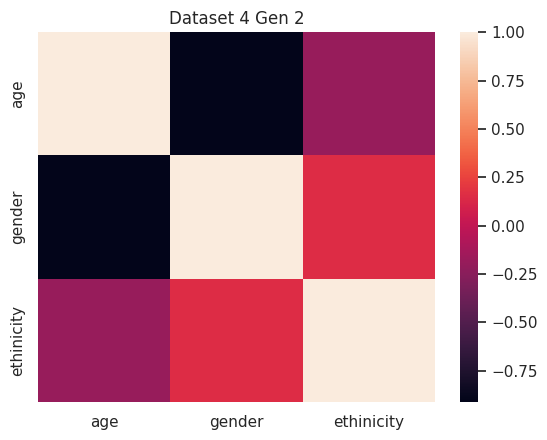

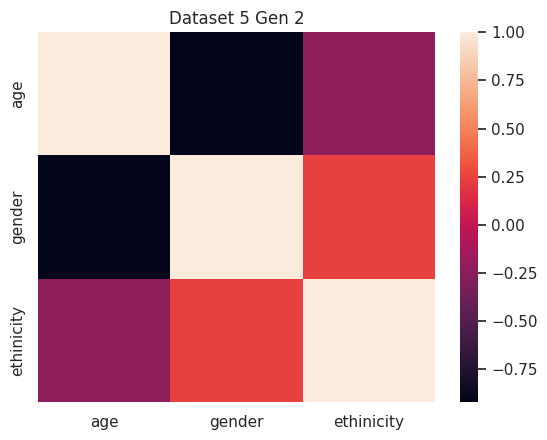

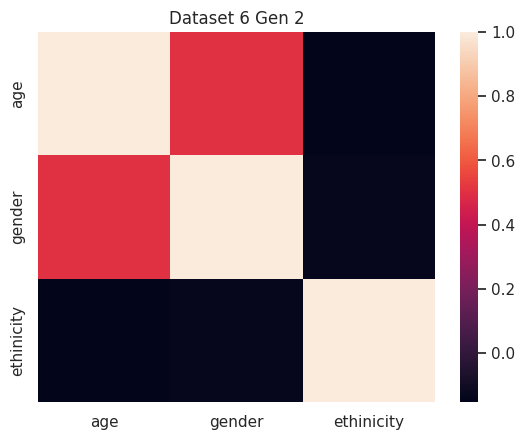

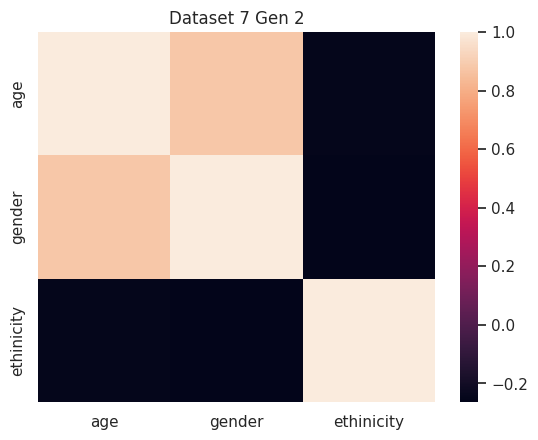

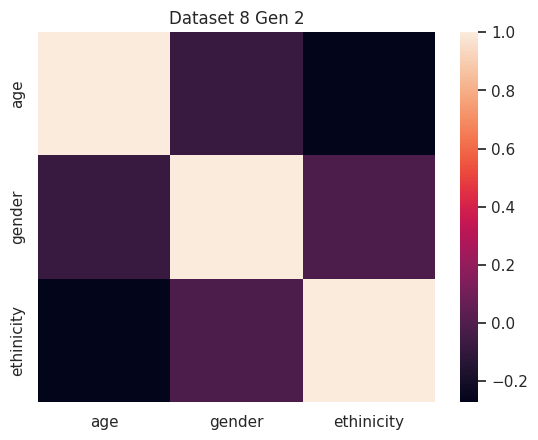

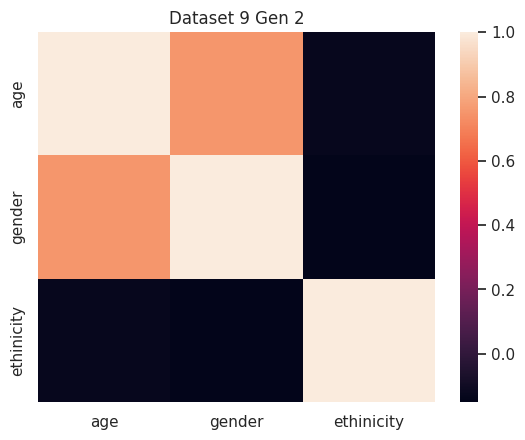

In [22]:
for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    sns_plot = sns.heatmap(df.drop("image", axis= 1).corr()).set(title = f"Dataset {i} Gen 2")
    plt.savefig(f"./Datasets/Correlations_Gen2/Dataset{i}.png")
    plt.show()

# Bayesian Loss Limit

Calculating the errors of a Bayesian Regression Model which just uses Gender make predictions

Training Dataset0, Test Loss: 1077.2680062744878
Training Dataset1, Test Loss: 601.7875000303167
Training Dataset2, Test Loss: 602.8963233617063
Training Dataset3, Test Loss: 600.5322925472677
Training Dataset4, Test Loss: 501.2444454650216
Training Dataset5, Test Loss: 740.4815103132299
Training Dataset6, Test Loss: 538.2889656370745
Training Dataset7, Test Loss: 1033.9039553493458
Training Dataset8, Test Loss: 414.079036764465
Training Dataset9, Test Loss: 541.4109964917877
Full Trainig Dataset: 392.3462117503327


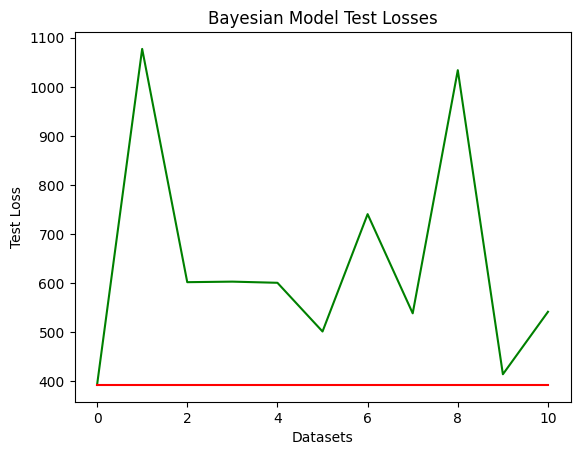

In [65]:
import sklearn
from sklearn import linear_model

test_losses_bayesian = []

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    
    x = df.gender.values
    x = x.reshape(-1,1)
    y = df.age.values

    #Bayesian Regression Model
    reg = linear_model.BayesianRidge()
    reg.fit(x, y)

    #Error Calculations
    x_test = test_df.gender.values
    x_test = x_test.reshape(-1,1)
    y_test = test_df.age.values

    y_pred = reg.predict(x_test)
    Loss = (np.square(y_test - y_pred)).mean()
    test_losses_bayesian.append(Loss)

    print(f"Training Dataset{i}, Test Loss: {Loss}")

#Bayesian on full dataset
x,y = train_df.gender.values, train_df.age.values
x = x.reshape(-1,1)
reg = linear_model.BayesianRidge()
reg.fit(x, y)

y_pred=reg.predict(x_test)
full_loss = (np.square(y_test - y_pred)).mean()
print("Full Trainig Dataset: {}".format(full_loss))
test_losses_bayesian.insert(0, full_loss)

#plotting the test loss of bayesian model in different datasets
plt.plot(range(len(test_losses_bayesian)), test_losses_bayesian, color='green')
plt.plot(range(len(test_losses_bayesian)), [full_loss]*len(test_losses_bayesian), color='red')
plt.title("Bayesian Model Test Losses")
plt.xlabel("Datasets")
plt.ylabel("Test Loss")
plt.savefig("./Outputs/Bayesian_losses.png")
plt.show()

# CORAL Paper Implementation

In [19]:
# ResNet 34 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

## ResNet 34 model
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [20]:
## Model and Hyperparameters
model = resnet34(1, False).to(device) 

In [21]:
#Training the model
def train(model, train_dataloader, val_dataloader, lr = 0.0005, weight_decay = 0, epochs = 200, verbose = False):
  if verbose:
    print("Training the Model........")

  optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  losses = []
  val_losses = []
  model.train()

  for epoch in tqdm(range(epochs)):
    tloss = 0
    loss_num = 0

    for batch_idx, data in enumerate(train_dataloader):
      x, y, _ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      optimizer.zero_grad()
      out = model(x)
      loss = F.mse_loss(out, y)
      loss.backward()
      optimizer.step()

      tloss += loss.detach().cpu()
      loss_num += 1

    with torch.no_grad():
      vloss = 0
      vloss_num = 0

      for batch_idx, data in enumerate(val_dataloader):
        x,y,_ = data
        x = x.to(torch.float32).to(device)
        y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

        out = model(x)
        loss = F.mse_loss(out, y)

        vloss += loss.detach().cpu()
        vloss_num += 1

    if verbose:
      print(f"Epoch: {epoch}/{epochs} Training loss: {tloss / loss_num} Validation loss: {vloss / vloss_num}")

    losses.append(float(tloss / loss_num))
    val_losses.append(float(vloss / vloss_num))

  return model, losses, val_losses

# Evaluating the model
def eval_model(model, test_dataloader):
  test_loss = 0
  test_loss_num =0

  with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
      x,y,_ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      out = model(x)
      loss = F.mse_loss(out, y)

      test_loss += loss.detach().cpu()
      test_loss_num += 1

  print(f"Test Loss: {float(test_loss / test_loss_num)}")
  return float(test_loss / test_loss_num)

In [22]:
# Plotting the loss curves
epochs = 100
# Plotting function
def plot_loss_curves(train_losses, val_losses, test_loss, epochs, model_name = "resnet"):
    plt.plot(range(epochs), train_losses, color = 'blue', label = 'Training Loss')
    plt.plot(range(epochs), val_losses, color = 'red', label = 'Validation loss')
    plt.plot(range(epochs), [test_loss] * epochs, color = 'green', label = "Test Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} loss curves")
    plt.show()

In [27]:
model, train_losses, val_losses = train(model, train_dataloader=train_dataloaders[0], val_dataloader=val_dataloader, verbose = True, epochs=100)
test_loss = eval_model(model, test_dataloader)

Training the Model........


  1%|█▌                                                                                                                                                           | 1/100 [00:17<28:42, 17.40s/it]

Epoch: 0/100 Training loss: 243.54690551757812 Validation loss: 379.5006103515625


  2%|███▏                                                                                                                                                         | 2/100 [00:34<28:13, 17.28s/it]

Epoch: 1/100 Training loss: 164.04591369628906 Validation loss: 188.0150146484375


  3%|████▋                                                                                                                                                        | 3/100 [00:51<27:58, 17.31s/it]

Epoch: 2/100 Training loss: 111.8448715209961 Validation loss: 181.76515197753906


  4%|██████▎                                                                                                                                                      | 4/100 [01:09<27:35, 17.24s/it]

Epoch: 3/100 Training loss: 105.63011169433594 Validation loss: 234.25927734375


  5%|███████▊                                                                                                                                                     | 5/100 [01:26<27:16, 17.23s/it]

Epoch: 4/100 Training loss: 130.583251953125 Validation loss: 169.1822509765625


  6%|█████████▍                                                                                                                                                   | 6/100 [01:43<26:59, 17.23s/it]

Epoch: 5/100 Training loss: 78.01573181152344 Validation loss: 189.72679138183594


  7%|██████████▉                                                                                                                                                  | 7/100 [02:01<26:55, 17.37s/it]

Epoch: 6/100 Training loss: 66.9306411743164 Validation loss: 179.9574737548828


  8%|████████████▌                                                                                                                                                | 8/100 [02:18<26:45, 17.45s/it]

Epoch: 7/100 Training loss: 59.74739456176758 Validation loss: 151.43479919433594


  9%|██████████████▏                                                                                                                                              | 9/100 [02:36<26:37, 17.55s/it]

Epoch: 8/100 Training loss: 77.9902572631836 Validation loss: 163.8548583984375


 10%|███████████████▌                                                                                                                                            | 10/100 [02:54<26:20, 17.56s/it]

Epoch: 9/100 Training loss: 61.013710021972656 Validation loss: 159.22467041015625


 11%|█████████████████▏                                                                                                                                          | 11/100 [03:11<26:09, 17.63s/it]

Epoch: 10/100 Training loss: 50.134193420410156 Validation loss: 159.81851196289062


 12%|██████████████████▋                                                                                                                                         | 12/100 [03:29<25:52, 17.65s/it]

Epoch: 11/100 Training loss: 49.709529876708984 Validation loss: 172.94142150878906


 13%|████████████████████▎                                                                                                                                       | 13/100 [03:47<25:36, 17.66s/it]

Epoch: 12/100 Training loss: 49.82073211669922 Validation loss: 167.87982177734375


 14%|█████████████████████▊                                                                                                                                      | 14/100 [04:04<25:18, 17.66s/it]

Epoch: 13/100 Training loss: 49.45458984375 Validation loss: 153.12789916992188


 15%|███████████████████████▍                                                                                                                                    | 15/100 [04:22<24:56, 17.61s/it]

Epoch: 14/100 Training loss: 51.113380432128906 Validation loss: 141.25010681152344


 16%|████████████████████████▉                                                                                                                                   | 16/100 [04:40<24:37, 17.59s/it]

Epoch: 15/100 Training loss: 65.84992980957031 Validation loss: 194.3275909423828


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [04:57<24:20, 17.59s/it]

Epoch: 16/100 Training loss: 47.82007598876953 Validation loss: 171.10574340820312


 18%|████████████████████████████                                                                                                                                | 18/100 [05:15<24:04, 17.61s/it]

Epoch: 17/100 Training loss: 42.727455139160156 Validation loss: 155.3270263671875


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [05:32<23:46, 17.61s/it]

Epoch: 18/100 Training loss: 38.20378494262695 Validation loss: 173.13763427734375


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [05:50<23:29, 17.62s/it]

Epoch: 19/100 Training loss: 44.52558898925781 Validation loss: 146.5448760986328


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [06:08<23:12, 17.63s/it]

Epoch: 20/100 Training loss: 38.74970245361328 Validation loss: 203.52037048339844


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [06:25<22:56, 17.65s/it]

Epoch: 21/100 Training loss: 32.133052825927734 Validation loss: 170.11817932128906


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [06:43<22:38, 17.65s/it]

Epoch: 22/100 Training loss: 27.154211044311523 Validation loss: 146.9059295654297


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [07:00<22:16, 17.59s/it]

Epoch: 23/100 Training loss: 23.97776985168457 Validation loss: 138.24661254882812


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [07:18<21:58, 17.58s/it]

Epoch: 24/100 Training loss: 23.313091278076172 Validation loss: 144.08203125


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [07:36<21:41, 17.59s/it]

Epoch: 25/100 Training loss: 33.28706359863281 Validation loss: 174.08714294433594


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [07:53<21:25, 17.60s/it]

Epoch: 26/100 Training loss: 32.95374298095703 Validation loss: 139.516845703125


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [08:11<21:05, 17.58s/it]

Epoch: 27/100 Training loss: 33.319217681884766 Validation loss: 168.4178466796875


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [08:28<20:50, 17.61s/it]

Epoch: 28/100 Training loss: 36.952552795410156 Validation loss: 170.75015258789062


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [08:46<20:33, 17.62s/it]

Epoch: 29/100 Training loss: 31.26614761352539 Validation loss: 176.3339385986328


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [09:04<20:13, 17.58s/it]

Epoch: 30/100 Training loss: 23.37710952758789 Validation loss: 144.7248992919922


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [09:21<19:55, 17.57s/it]

Epoch: 31/100 Training loss: 22.327754974365234 Validation loss: 166.7274932861328


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [09:39<19:40, 17.61s/it]

Epoch: 32/100 Training loss: 18.38109588623047 Validation loss: 153.3298797607422


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [09:56<19:20, 17.59s/it]

Epoch: 33/100 Training loss: 19.221261978149414 Validation loss: 158.1585235595703


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [10:14<19:02, 17.58s/it]

Epoch: 34/100 Training loss: 16.61965560913086 Validation loss: 165.33006286621094


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [10:32<18:47, 17.62s/it]

Epoch: 35/100 Training loss: 15.172627449035645 Validation loss: 150.9136962890625


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [10:49<18:29, 17.62s/it]

Epoch: 36/100 Training loss: 16.348676681518555 Validation loss: 150.9208526611328


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [11:07<18:11, 17.60s/it]

Epoch: 37/100 Training loss: 24.420251846313477 Validation loss: 171.1116180419922


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [11:24<17:54, 17.62s/it]

Epoch: 38/100 Training loss: 24.771360397338867 Validation loss: 155.335205078125


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [11:42<17:36, 17.61s/it]

Epoch: 39/100 Training loss: 21.449752807617188 Validation loss: 177.49246215820312


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [12:00<17:19, 17.61s/it]

Epoch: 40/100 Training loss: 29.752405166625977 Validation loss: 152.8134307861328


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [12:17<17:00, 17.59s/it]

Epoch: 41/100 Training loss: 25.479930877685547 Validation loss: 199.62234497070312


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [12:35<16:41, 17.58s/it]

Epoch: 42/100 Training loss: 26.8000545501709 Validation loss: 159.64414978027344


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [12:52<16:25, 17.60s/it]

Epoch: 43/100 Training loss: 42.15810775756836 Validation loss: 219.8900146484375


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [13:10<16:07, 17.58s/it]

Epoch: 44/100 Training loss: 59.28558349609375 Validation loss: 236.62579345703125


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [13:28<15:49, 17.59s/it]

Epoch: 45/100 Training loss: 50.28034210205078 Validation loss: 156.06253051757812


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [13:45<15:34, 17.63s/it]

Epoch: 46/100 Training loss: 34.74864196777344 Validation loss: 175.4070281982422


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [14:03<15:15, 17.61s/it]

Epoch: 47/100 Training loss: 33.21955108642578 Validation loss: 152.73171997070312


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [14:21<14:59, 17.64s/it]

Epoch: 48/100 Training loss: 22.380455017089844 Validation loss: 160.24671936035156


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [14:38<14:41, 17.63s/it]

Epoch: 49/100 Training loss: 17.872365951538086 Validation loss: 153.5952606201172


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [14:56<14:22, 17.60s/it]

Epoch: 50/100 Training loss: 16.18136215209961 Validation loss: 151.04090881347656


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [15:13<14:06, 17.63s/it]

Epoch: 51/100 Training loss: 15.90166187286377 Validation loss: 147.4842529296875


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [15:31<13:49, 17.65s/it]

Epoch: 52/100 Training loss: 18.34048080444336 Validation loss: 174.07122802734375


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [15:49<13:30, 17.62s/it]

Epoch: 53/100 Training loss: 13.621421813964844 Validation loss: 158.4940185546875


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [16:06<13:13, 17.64s/it]

Epoch: 54/100 Training loss: 12.34572696685791 Validation loss: 141.8667449951172


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [16:24<12:55, 17.62s/it]

Epoch: 55/100 Training loss: 11.352758407592773 Validation loss: 146.58438110351562


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [16:42<12:37, 17.62s/it]

Epoch: 56/100 Training loss: 10.4103364944458 Validation loss: 155.6332550048828


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [16:59<12:21, 17.65s/it]

Epoch: 57/100 Training loss: 9.79456615447998 Validation loss: 170.61257934570312


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [17:17<12:04, 17.67s/it]

Epoch: 58/100 Training loss: 9.112714767456055 Validation loss: 145.9476318359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [17:35<11:46, 17.66s/it]

Epoch: 59/100 Training loss: 8.181968688964844 Validation loss: 166.96348571777344


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [17:52<11:29, 17.68s/it]

Epoch: 60/100 Training loss: 9.412897109985352 Validation loss: 166.06529235839844


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [18:10<11:09, 17.63s/it]

Epoch: 61/100 Training loss: 9.153339385986328 Validation loss: 147.56524658203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [18:28<10:52, 17.64s/it]

Epoch: 62/100 Training loss: 8.525735855102539 Validation loss: 151.0042724609375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [18:45<10:34, 17.63s/it]

Epoch: 63/100 Training loss: 6.85553503036499 Validation loss: 138.65481567382812


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [19:03<10:16, 17.61s/it]

Epoch: 64/100 Training loss: 12.199419021606445 Validation loss: 161.06956481933594


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [19:20<09:58, 17.61s/it]

Epoch: 65/100 Training loss: 83.00841522216797 Validation loss: 227.8907470703125


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [19:38<09:40, 17.60s/it]

Epoch: 66/100 Training loss: 51.95367431640625 Validation loss: 199.21360778808594


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [19:55<09:22, 17.59s/it]

Epoch: 67/100 Training loss: 32.66451644897461 Validation loss: 159.6177520751953


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [20:13<09:06, 17.63s/it]

Epoch: 68/100 Training loss: 24.808300018310547 Validation loss: 151.0873260498047


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [20:31<08:48, 17.60s/it]

Epoch: 69/100 Training loss: 19.49522590637207 Validation loss: 163.40756225585938


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [20:48<08:30, 17.59s/it]

Epoch: 70/100 Training loss: 16.745616912841797 Validation loss: 182.3607177734375


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [21:06<08:12, 17.59s/it]

Epoch: 71/100 Training loss: 15.30378532409668 Validation loss: 173.62088012695312


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [21:24<07:56, 17.65s/it]

Epoch: 72/100 Training loss: 13.730108261108398 Validation loss: 158.05264282226562


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [21:41<07:39, 17.68s/it]

Epoch: 73/100 Training loss: 13.237200736999512 Validation loss: 146.68484497070312


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [21:59<07:20, 17.63s/it]

Epoch: 74/100 Training loss: 11.116857528686523 Validation loss: 144.2837677001953


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [22:16<07:02, 17.60s/it]

Epoch: 75/100 Training loss: 10.009873390197754 Validation loss: 153.47300720214844


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [22:34<06:46, 17.66s/it]

Epoch: 76/100 Training loss: 13.289525032043457 Validation loss: 156.99090576171875


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [22:52<06:28, 17.66s/it]

Epoch: 77/100 Training loss: 11.10659408569336 Validation loss: 152.99053955078125


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [23:10<06:10, 17.64s/it]

Epoch: 78/100 Training loss: 10.571918487548828 Validation loss: 158.29457092285156


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [23:27<05:52, 17.62s/it]

Epoch: 79/100 Training loss: 10.451519966125488 Validation loss: 140.2431640625


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [23:45<05:35, 17.66s/it]

Epoch: 80/100 Training loss: 8.262934684753418 Validation loss: 149.13058471679688


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [24:02<05:17, 17.62s/it]

Epoch: 81/100 Training loss: 7.8397088050842285 Validation loss: 158.3518829345703


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [24:20<04:59, 17.61s/it]

Epoch: 82/100 Training loss: 6.897097110748291 Validation loss: 138.56838989257812


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [24:37<04:41, 17.59s/it]

Epoch: 83/100 Training loss: 8.26226806640625 Validation loss: 151.1826629638672


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [24:55<04:24, 17.62s/it]

Epoch: 84/100 Training loss: 5.335751056671143 Validation loss: 150.4749755859375


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [25:13<04:06, 17.64s/it]

Epoch: 85/100 Training loss: 5.868597030639648 Validation loss: 147.5821990966797


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [25:30<03:49, 17.62s/it]

Epoch: 86/100 Training loss: 6.887060642242432 Validation loss: 149.0998077392578


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [25:48<03:31, 17.60s/it]

Epoch: 87/100 Training loss: 7.668117523193359 Validation loss: 185.8367156982422


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 89/100 [26:06<03:14, 17.65s/it]

Epoch: 88/100 Training loss: 11.314329147338867 Validation loss: 161.4973602294922


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 90/100 [26:23<02:56, 17.64s/it]

Epoch: 89/100 Training loss: 22.465620040893555 Validation loss: 171.51470947265625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 91/100 [26:41<02:38, 17.61s/it]

Epoch: 90/100 Training loss: 23.509746551513672 Validation loss: 210.0991668701172


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92/100 [26:59<02:20, 17.62s/it]

Epoch: 91/100 Training loss: 18.44437599182129 Validation loss: 147.84361267089844


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 93/100 [27:16<02:03, 17.65s/it]

Epoch: 92/100 Training loss: 14.027463912963867 Validation loss: 166.49085998535156


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 94/100 [27:34<01:45, 17.64s/it]

Epoch: 93/100 Training loss: 8.420034408569336 Validation loss: 147.02200317382812


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 95/100 [27:52<01:28, 17.64s/it]

Epoch: 94/100 Training loss: 6.499660491943359 Validation loss: 146.476318359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [28:09<01:10, 17.71s/it]

Epoch: 95/100 Training loss: 5.839524269104004 Validation loss: 160.01121520996094


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97/100 [28:27<00:53, 17.75s/it]

Epoch: 96/100 Training loss: 5.376172065734863 Validation loss: 141.04808044433594


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [28:45<00:35, 17.73s/it]

Epoch: 97/100 Training loss: 22.716552734375 Validation loss: 182.8309326171875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [29:03<00:17, 17.75s/it]

Epoch: 98/100 Training loss: 21.726192474365234 Validation loss: 182.0535430908203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:20<00:00, 17.61s/it]

Epoch: 99/100 Training loss: 13.677627563476562 Validation loss: 181.6771697998047


Test Loss: 191.3367919921875


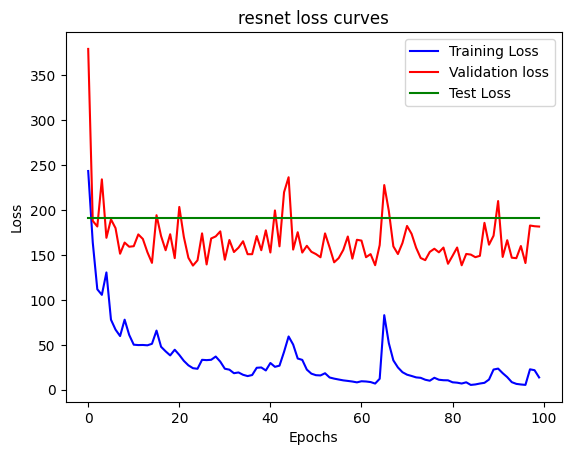

In [28]:
#plotting
plot_loss_curves(train_losses, val_losses, test_loss, epochs)

In [23]:
# Training Dataset and Dataloader
comp_train_dataset = UTKFaceDataset(dataframe=train_df,
                                   image_dir = DIR_PATH,
                                   transform = custom_transform)
comp_train_dataloader = DataLoader(dataset = comp_train_dataset,
                                  batch_size = BATCH_SIZE,
                                  shuffle = True)

In [22]:
full_model = resnet34(1, False).to(device)
full_model, full_losses, full_vlosses = train(model, comp_train_dataloader, val_dataloader, epochs = 100, verbose = True)
full_test_loss = eval_model(model, test_dataloader)
torch.save(full_model.state_dict(), "./Models/full_model.pth")

Training the Model........


  1%|█▌                                                                                                                                                         | 1/100 [00:41<1:08:06, 41.28s/it]

Epoch: 0/100 Training loss: 407.72027587890625 Validation loss: 159.7054901123047


  2%|███                                                                                                                                                        | 2/100 [01:18<1:03:02, 38.60s/it]

Epoch: 1/100 Training loss: 127.554443359375 Validation loss: 116.08931732177734


  3%|████▋                                                                                                                                                      | 3/100 [01:55<1:01:15, 37.89s/it]

Epoch: 2/100 Training loss: 107.1889419555664 Validation loss: 106.64752197265625


  4%|██████▏                                                                                                                                                    | 4/100 [02:32<1:00:26, 37.78s/it]

Epoch: 3/100 Training loss: 89.40238189697266 Validation loss: 92.81407165527344


  5%|███████▊                                                                                                                                                     | 5/100 [03:10<59:40, 37.68s/it]

Epoch: 4/100 Training loss: 84.75157928466797 Validation loss: 84.75932312011719


  6%|█████████▍                                                                                                                                                   | 6/100 [03:48<59:16, 37.83s/it]

Epoch: 5/100 Training loss: 74.35176086425781 Validation loss: 83.7119369506836


  7%|██████████▊                                                                                                                                                | 7/100 [04:29<1:00:33, 39.07s/it]

Epoch: 6/100 Training loss: 69.507568359375 Validation loss: 83.52178192138672


  8%|████████████▌                                                                                                                                                | 8/100 [05:08<59:43, 38.95s/it]

Epoch: 7/100 Training loss: 63.56819534301758 Validation loss: 89.8721923828125


  9%|█████████████▉                                                                                                                                             | 9/100 [05:50<1:00:33, 39.93s/it]

Epoch: 8/100 Training loss: 59.15048599243164 Validation loss: 85.87333679199219


 10%|███████████████▌                                                                                                                                            | 10/100 [06:30<59:43, 39.82s/it]

Epoch: 9/100 Training loss: 60.68708038330078 Validation loss: 87.0700912475586


 11%|█████████████████▏                                                                                                                                          | 11/100 [07:10<59:18, 39.98s/it]

Epoch: 10/100 Training loss: 53.70991897583008 Validation loss: 79.0096206665039


 12%|██████████████████▋                                                                                                                                         | 12/100 [07:51<58:58, 40.21s/it]

Epoch: 11/100 Training loss: 47.169151306152344 Validation loss: 77.2950668334961


 13%|████████████████████▎                                                                                                                                       | 13/100 [08:30<57:50, 39.89s/it]

Epoch: 12/100 Training loss: 50.711971282958984 Validation loss: 81.03874969482422


 14%|█████████████████████▊                                                                                                                                      | 14/100 [09:16<59:36, 41.59s/it]

Epoch: 13/100 Training loss: 46.69129180908203 Validation loss: 81.22478485107422


 15%|███████████████████████▍                                                                                                                                    | 15/100 [09:55<57:52, 40.85s/it]

Epoch: 14/100 Training loss: 44.1159553527832 Validation loss: 79.12760162353516


 16%|████████████████████████▉                                                                                                                                   | 16/100 [10:35<57:02, 40.74s/it]

Epoch: 15/100 Training loss: 38.284854888916016 Validation loss: 76.61612701416016


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [11:15<56:07, 40.57s/it]

Epoch: 16/100 Training loss: 38.64206314086914 Validation loss: 76.14707946777344


 18%|████████████████████████████                                                                                                                                | 18/100 [11:55<55:07, 40.34s/it]

Epoch: 17/100 Training loss: 33.59965133666992 Validation loss: 79.09991455078125


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [12:36<54:38, 40.48s/it]

Epoch: 18/100 Training loss: 33.681732177734375 Validation loss: 81.46034240722656


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [13:16<53:51, 40.40s/it]

Epoch: 19/100 Training loss: 33.465736389160156 Validation loss: 74.85529327392578


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [13:55<52:43, 40.05s/it]

Epoch: 20/100 Training loss: 27.180438995361328 Validation loss: 67.8237075805664


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [14:36<52:11, 40.15s/it]

Epoch: 21/100 Training loss: 30.52943992614746 Validation loss: 73.76728820800781


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [15:16<51:28, 40.11s/it]

Epoch: 22/100 Training loss: 29.576568603515625 Validation loss: 77.78179168701172


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [15:56<50:57, 40.23s/it]

Epoch: 23/100 Training loss: 25.982336044311523 Validation loss: 72.5457992553711


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [16:37<50:31, 40.43s/it]

Epoch: 24/100 Training loss: 22.81153678894043 Validation loss: 70.90084838867188


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [17:18<49:51, 40.43s/it]

Epoch: 25/100 Training loss: 27.150754928588867 Validation loss: 74.0699234008789


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [17:58<49:09, 40.40s/it]

Epoch: 26/100 Training loss: 23.68161392211914 Validation loss: 77.27184295654297


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [18:38<48:32, 40.45s/it]

Epoch: 27/100 Training loss: 20.529855728149414 Validation loss: 71.89373016357422


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [19:18<47:38, 40.26s/it]

Epoch: 28/100 Training loss: 19.426774978637695 Validation loss: 79.35758972167969


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [19:58<46:55, 40.23s/it]

Epoch: 29/100 Training loss: 19.672866821289062 Validation loss: 68.00057220458984


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [20:38<46:06, 40.10s/it]

Epoch: 30/100 Training loss: 16.434463500976562 Validation loss: 69.36783599853516


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [21:18<45:15, 39.93s/it]

Epoch: 31/100 Training loss: 16.001413345336914 Validation loss: 77.48125457763672


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [21:58<44:48, 40.13s/it]

Epoch: 32/100 Training loss: 18.013790130615234 Validation loss: 77.58187103271484


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [22:38<44:07, 40.11s/it]

Epoch: 33/100 Training loss: 17.049823760986328 Validation loss: 68.55298614501953


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [23:18<43:25, 40.09s/it]

Epoch: 34/100 Training loss: 17.64322280883789 Validation loss: 72.7080078125


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [24:00<43:12, 40.50s/it]

Epoch: 35/100 Training loss: 14.92263126373291 Validation loss: 69.94232177734375


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [24:43<43:12, 41.14s/it]

Epoch: 36/100 Training loss: 15.55790901184082 Validation loss: 68.11903381347656


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [25:22<41:53, 40.54s/it]

Epoch: 37/100 Training loss: 15.614068984985352 Validation loss: 66.4748306274414


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [26:03<41:27, 40.78s/it]

Epoch: 38/100 Training loss: 18.84457778930664 Validation loss: 75.7334976196289


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [26:43<40:32, 40.55s/it]

Epoch: 39/100 Training loss: 16.752538681030273 Validation loss: 69.70745849609375


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [27:23<39:42, 40.39s/it]

Epoch: 40/100 Training loss: 14.520405769348145 Validation loss: 67.62401580810547


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [28:04<39:17, 40.64s/it]

Epoch: 41/100 Training loss: 14.229775428771973 Validation loss: 71.57698059082031


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [28:43<38:09, 40.16s/it]

Epoch: 42/100 Training loss: 14.440664291381836 Validation loss: 78.7094497680664


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [29:25<37:53, 40.60s/it]

Epoch: 43/100 Training loss: 11.97784423828125 Validation loss: 65.45916748046875


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [30:07<37:36, 41.02s/it]

Epoch: 44/100 Training loss: 10.454360008239746 Validation loss: 65.16043853759766


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [30:50<37:30, 41.68s/it]

Epoch: 45/100 Training loss: 10.405718803405762 Validation loss: 66.90106201171875


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [31:30<36:20, 41.14s/it]

Epoch: 46/100 Training loss: 10.432942390441895 Validation loss: 66.77703094482422


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [32:10<35:21, 40.80s/it]

Epoch: 47/100 Training loss: 10.608920097351074 Validation loss: 68.2132339477539


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [32:51<34:43, 40.85s/it]

Epoch: 48/100 Training loss: 9.795012474060059 Validation loss: 65.9963607788086


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [33:31<33:46, 40.52s/it]

Epoch: 49/100 Training loss: 10.16041088104248 Validation loss: 67.28673553466797


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [34:12<33:16, 40.75s/it]

Epoch: 50/100 Training loss: 10.158469200134277 Validation loss: 69.63367462158203


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [34:51<32:13, 40.28s/it]

Epoch: 51/100 Training loss: 8.920031547546387 Validation loss: 66.06654357910156


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [35:34<32:00, 40.87s/it]

Epoch: 52/100 Training loss: 8.48011589050293 Validation loss: 68.28852081298828


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [36:13<30:59, 40.42s/it]

Epoch: 53/100 Training loss: 8.953848838806152 Validation loss: 66.31624603271484


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [36:52<30:01, 40.03s/it]

Epoch: 54/100 Training loss: 11.500215530395508 Validation loss: 108.83831787109375


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [37:38<30:34, 41.70s/it]

Epoch: 55/100 Training loss: 47.36488723754883 Validation loss: 86.54684448242188


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [38:19<29:53, 41.71s/it]

Epoch: 56/100 Training loss: 30.04367446899414 Validation loss: 69.72256469726562


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [39:00<28:54, 41.29s/it]

Epoch: 57/100 Training loss: 14.321098327636719 Validation loss: 67.49505615234375


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [39:41<28:15, 41.36s/it]

Epoch: 58/100 Training loss: 11.1074857711792 Validation loss: 65.45661163330078


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [40:22<27:25, 41.15s/it]

Epoch: 59/100 Training loss: 8.457686424255371 Validation loss: 68.0583724975586


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [41:05<27:03, 41.62s/it]

Epoch: 60/100 Training loss: 8.381793022155762 Validation loss: 67.50426483154297


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [41:46<26:16, 41.49s/it]

Epoch: 61/100 Training loss: 7.267120838165283 Validation loss: 69.1309585571289


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [42:29<25:59, 42.16s/it]

Epoch: 62/100 Training loss: 7.2414164543151855 Validation loss: 65.32917022705078


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [43:11<25:15, 42.11s/it]

Epoch: 63/100 Training loss: 6.115442752838135 Validation loss: 63.42991256713867


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [43:53<24:28, 41.95s/it]

Epoch: 64/100 Training loss: 6.356719970703125 Validation loss: 67.80416107177734


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [44:34<23:39, 41.74s/it]

Epoch: 65/100 Training loss: 5.543104648590088 Validation loss: 64.285888671875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [45:15<22:51, 41.55s/it]

Epoch: 66/100 Training loss: 5.550139904022217 Validation loss: 66.13368225097656


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [45:55<21:52, 41.03s/it]

Epoch: 67/100 Training loss: 5.365570068359375 Validation loss: 66.16043853759766


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [46:35<21:04, 40.80s/it]

Epoch: 68/100 Training loss: 5.580009937286377 Validation loss: 66.1858901977539


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [47:17<20:28, 40.94s/it]

Epoch: 69/100 Training loss: 5.558287143707275 Validation loss: 62.63231658935547


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [48:00<20:10, 41.75s/it]

Epoch: 70/100 Training loss: 5.251992702484131 Validation loss: 64.10868835449219


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [48:41<19:23, 41.54s/it]

Epoch: 71/100 Training loss: 5.337039947509766 Validation loss: 67.10982513427734


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [49:23<18:40, 41.51s/it]

Epoch: 72/100 Training loss: 5.189208507537842 Validation loss: 62.725772857666016


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [50:06<18:12, 42.02s/it]

Epoch: 73/100 Training loss: 5.7148237228393555 Validation loss: 68.12103271484375


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [50:46<17:11, 41.27s/it]

Epoch: 74/100 Training loss: 6.656029224395752 Validation loss: 65.14201354980469


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [51:27<16:34, 41.45s/it]

Epoch: 75/100 Training loss: 5.599625110626221 Validation loss: 65.43551635742188


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [52:09<15:53, 41.44s/it]

Epoch: 76/100 Training loss: 5.549320697784424 Validation loss: 64.5837631225586


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [52:52<15:20, 41.83s/it]

Epoch: 77/100 Training loss: 5.598494052886963 Validation loss: 62.528656005859375


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [53:34<14:39, 41.90s/it]

Epoch: 78/100 Training loss: 5.113371849060059 Validation loss: 67.74098205566406


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [54:17<14:06, 42.31s/it]

Epoch: 79/100 Training loss: 5.065004825592041 Validation loss: 64.32760620117188


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [55:00<13:26, 42.47s/it]

Epoch: 80/100 Training loss: 5.152034759521484 Validation loss: 63.168617248535156


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [55:40<12:32, 41.79s/it]

Epoch: 81/100 Training loss: 5.060207366943359 Validation loss: 66.82420349121094


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [56:20<11:39, 41.17s/it]

Epoch: 82/100 Training loss: 5.891847133636475 Validation loss: 63.999576568603516


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [57:01<10:58, 41.18s/it]

Epoch: 83/100 Training loss: 5.69547176361084 Validation loss: 67.36473083496094


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [57:42<10:19, 41.27s/it]

Epoch: 84/100 Training loss: 5.642075061798096 Validation loss: 66.23931884765625


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [58:25<09:42, 41.61s/it]

Epoch: 85/100 Training loss: 5.514216423034668 Validation loss: 66.02173614501953


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [59:07<09:02, 41.71s/it]

Epoch: 86/100 Training loss: 7.5766096115112305 Validation loss: 86.9559097290039


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [59:47<08:14, 41.23s/it]

Epoch: 87/100 Training loss: 35.94893264770508 Validation loss: 75.00960540771484


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 89/100 [1:00:30<07:39, 41.80s/it]

Epoch: 88/100 Training loss: 15.070849418640137 Validation loss: 65.07671356201172


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 90/100 [1:01:12<06:57, 41.73s/it]

Epoch: 89/100 Training loss: 7.883814811706543 Validation loss: 64.39547729492188


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 91/100 [1:01:53<06:14, 41.62s/it]

Epoch: 90/100 Training loss: 6.252129554748535 Validation loss: 63.95219421386719


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 92/100 [1:02:34<05:31, 41.38s/it]

Epoch: 91/100 Training loss: 4.83701229095459 Validation loss: 63.77271270751953


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 93/100 [1:03:14<04:46, 40.96s/it]

Epoch: 92/100 Training loss: 4.1841816902160645 Validation loss: 63.445640563964844


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [1:03:55<04:05, 40.99s/it]

Epoch: 93/100 Training loss: 3.9048614501953125 Validation loss: 63.472900390625


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 95/100 [1:04:42<03:34, 42.90s/it]

Epoch: 94/100 Training loss: 3.863115072250366 Validation loss: 65.36019134521484


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [1:05:28<02:54, 43.67s/it]

Epoch: 95/100 Training loss: 3.583923816680908 Validation loss: 61.71787643432617


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [1:06:06<02:06, 42.22s/it]

Epoch: 96/100 Training loss: 3.362483501434326 Validation loss: 62.504676818847656


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [1:06:48<01:24, 42.06s/it]

Epoch: 97/100 Training loss: 3.3592283725738525 Validation loss: 62.39314270019531


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [1:07:31<00:42, 42.28s/it]

Epoch: 98/100 Training loss: 3.6823525428771973 Validation loss: 65.2373275756836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:08:12<00:00, 40.93s/it]

Epoch: 99/100 Training loss: 3.584869623184204 Validation loss: 63.3243522644043


Test Loss: 72.61416625976562


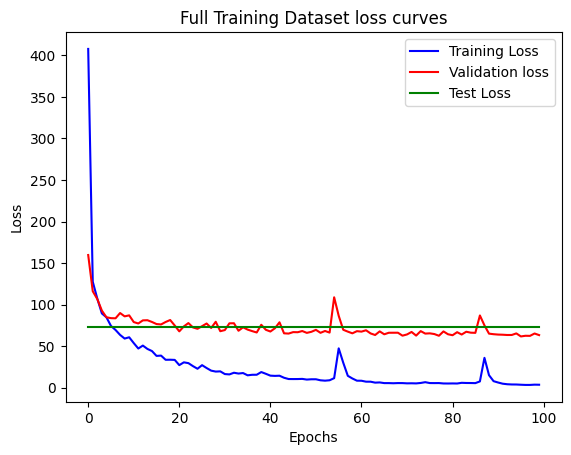

In [23]:
#plotting loss curves for the entire training dataset
plot_loss_curves(full_losses, full_vlosses, full_test_loss, epochs, model_name="Full Training Dataset")

In [20]:
# Training models on different Training Datasets
models = []
tlosses = []
vlosses = []
tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = resnet34(1, False).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100)
    test_loss = eval_model(model, test_dataloader)

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:02<00:00, 18.02s/it]


Test Loss: 167.07644653320312
Model saved to ./Models/Gen2_models/model0.pth
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:16<00:00, 18.17s/it]


Test Loss: 184.7777862548828
Model saved to ./Models/Gen2_models/model1.pth
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:00<00:00, 18.00s/it]


Test Loss: 347.7750549316406
Model saved to ./Models/Gen2_models/model2.pth
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:45<00:00, 17.86s/it]


Test Loss: 202.0666046142578
Model saved to ./Models/Gen2_models/model3.pth
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:52<00:00, 17.93s/it]


Test Loss: 250.9844512939453
Model saved to ./Models/Gen2_models/model4.pth
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:48<00:00, 17.88s/it]


Test Loss: 226.62294006347656
Model saved to ./Models/Gen2_models/model5.pth
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:48<00:00, 17.88s/it]


Test Loss: 229.2008819580078
Model saved to ./Models/Gen2_models/model6.pth
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:44<00:00, 17.84s/it]


Test Loss: 353.51263427734375
Model saved to ./Models/Gen2_models/model7.pth
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:49<00:00, 17.90s/it]


Test Loss: 285.98394775390625
Model saved to ./Models/Gen2_models/model8.pth
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:57<00:00, 17.97s/it]


Test Loss: 194.95729064941406
Model saved to ./Models/Gen2_models/model9.pth


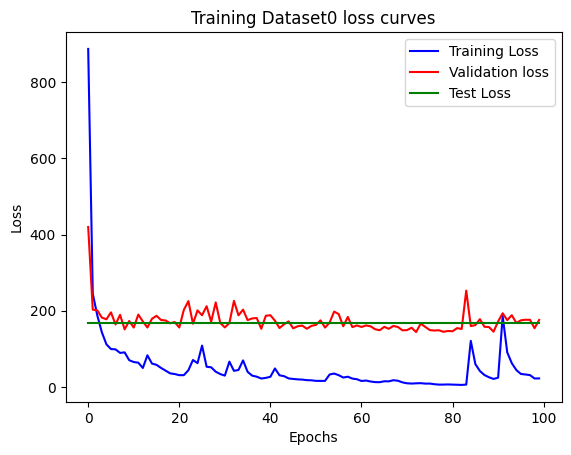

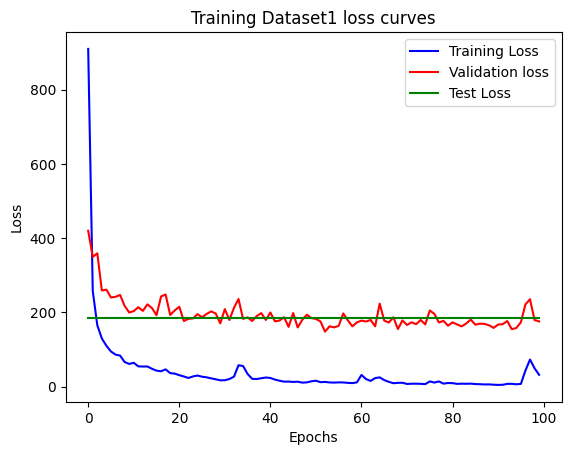

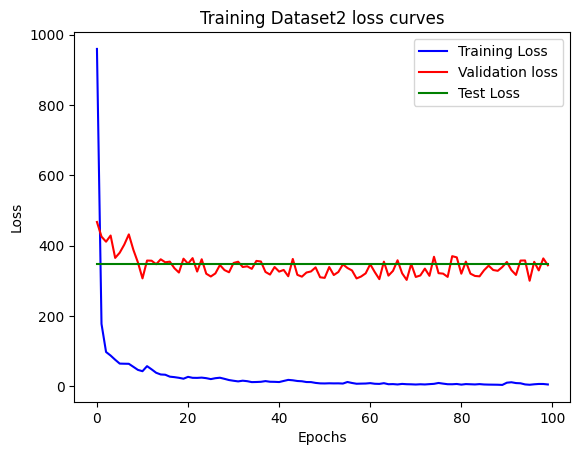

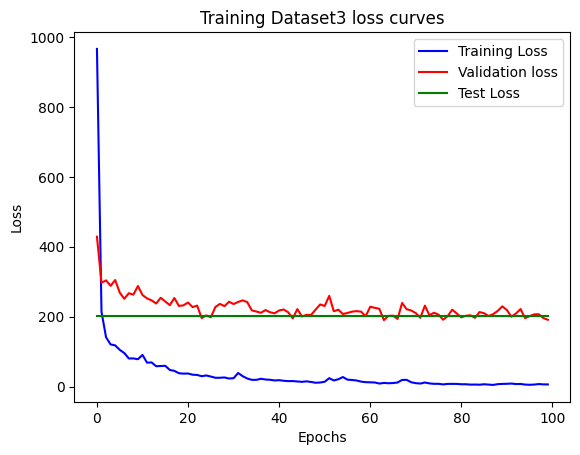

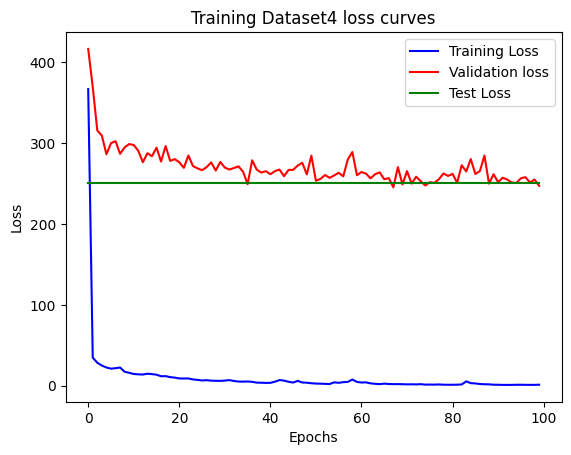

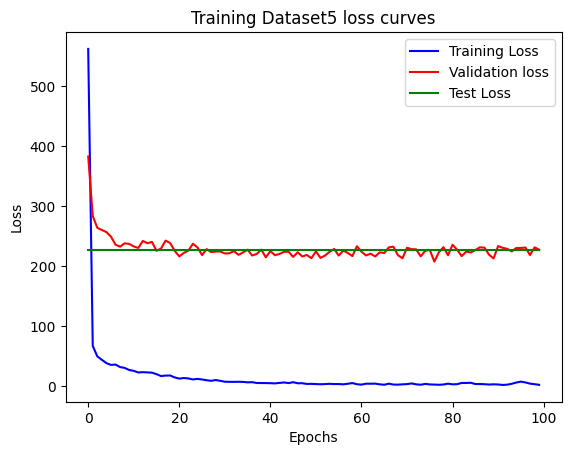

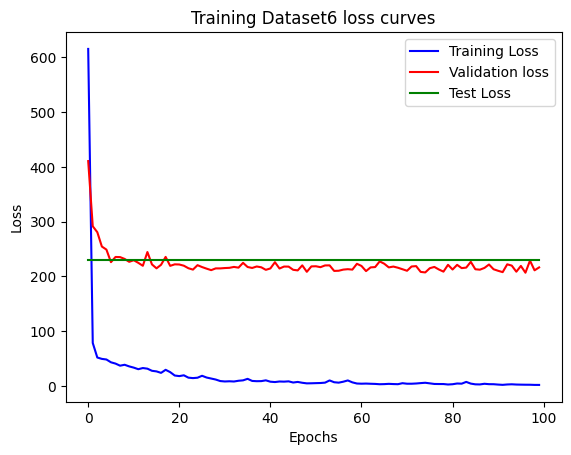

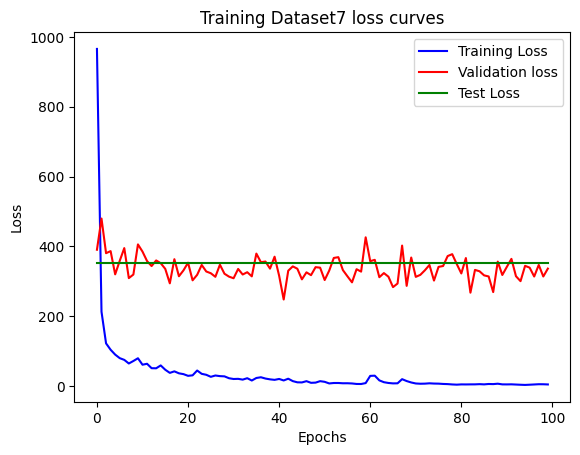

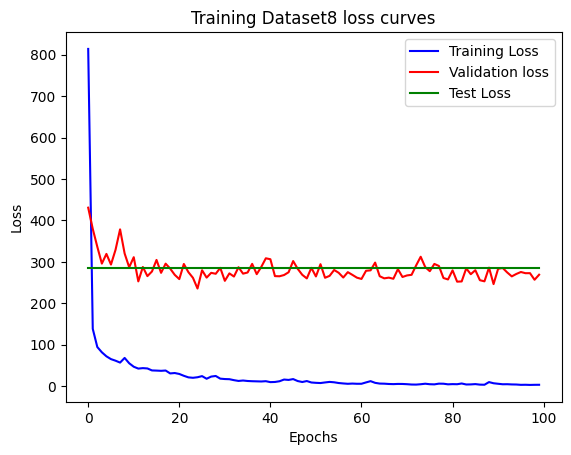

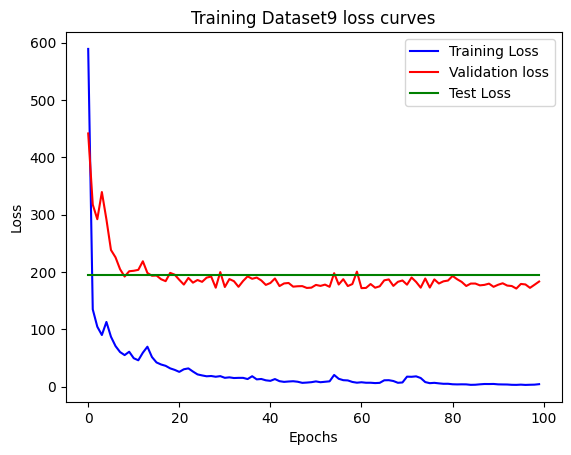

In [21]:
#plotting graphs:
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs, model_name=f"Training Dataset{i}")

# Feature Sieve Regression
## 1) Forgetting loss: Margin Loss

In [23]:
class Feature_Sieve_Margin(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Margin, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, 1)
        # self.aux_out = nn.Linear(128, 1)
        

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([ self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        # aux = self.aux_out(aux)
        
        
        return logits, aux

def fs_margin(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Margin(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [24]:
fs_mar_model = fs_margin(1, False).to(device)

In [25]:
## Forget Loss: Margin Loss
def learn_main(model, optim_main, x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux(model, optim_main, optim_aux, x, y, alpha_aux = 1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * F.mse_loss(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux(model, optim_forget, x, y, margin):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    mse_loss = F.mse_loss(aux,y)
    thresh = torch.tensor(-margin).to(torch.float32).to(device)
    loss = torch.max(thresh, -mse_loss)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()

In [26]:
def train_fs_mar(model, train_dataloader, val_dataloader, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=2, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training model...............")
        
    train_losses= []
    val_losses = []
    aux_losses = []

    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # training Part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                auxloss = learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_aux(model, optim_forget, x, y, margin)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                aux_losses.append(auxloss.detach().cpu())
                
                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch+1}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses

def eval_FSModel(model, test_dataloader):
    with torch.no_grad():
        tst_loss = 0
        loss_num = 0

        for batch_idx, data in enumerate(test_dataloader):
            x,y, _ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            out = model(x)[0]
            loss = F.mse_loss(out, y)

            tst_loss += loss.detach().cpu()
            loss_num += 1

        print(f"Test Loss: {float(tst_loss / loss_num)}")
    return float(tst_loss / loss_num)

In [28]:
# Hyperparameter Tuning
margins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
forget_lrs = [1e-5, 5e-5, 2e-5, 2e-4, 5e-4, 1e-4, 1e-3, 2e-3, 8e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss, _ = train_fs_mar(model, train_dataloaders[0], val_dataloader, lrs = [0.0005, 0.0005, forget_lrs[i]], verbose=False, epochs=5)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss, _ = train_fs_mar(model, train_dataloaders[0], val_dataloader, lrs=[0.0005, 0.0005, best_forget_lr], forget_iters=forget_iters[i], verbose=False, epochs=5)
    tst_loss= eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter :{best_forget_iter}")

test_losses = []
for i in range(len(margins)):
    print(f"Margin: {margins[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss,_ = train_fs_mar(model, train_dataloaders[0], val_dataloader, margin=margins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_margin = margins[test_losses.index(min(test_losses))]
print(f"Best Margin: {best_margin}")

Forget LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.38s/it]


Test Loss: 183.6930694580078
Forget LR: 5e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.43s/it]


Test Loss: 552.69384765625
Forget LR: 2e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.75s/it]


Test Loss: 390.2315979003906
Forget LR: 0.0002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.32s/it]


Test Loss: 414.79522705078125
Forget LR: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.33s/it]


Test Loss: 260.92401123046875
Forget LR: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.25s/it]


Test Loss: 557.2430419921875
Forget LR: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.53s/it]


Test Loss: 185.87071228027344
Forget LR: 0.002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.03s/it]


Test Loss: 222.0137481689453
Forget LR: 0.008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.03s/it]


Test Loss: 211.02488708496094
Forget LR: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.44s/it]


Test Loss: 203.47308349609375
Forget LR: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.31s/it]


Test Loss: 270.214111328125
Forget LR: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.90s/it]


Test Loss: 198.83926391601562
Forget LR: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.59s/it]


Test Loss: 189.24063110351562
Best Forget Lr: 1e-05
Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.51s/it]


Test Loss: 229.5182647705078
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.13s/it]


Test Loss: 324.8780517578125
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 207.81890869140625
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.33s/it]


Test Loss: 200.10597229003906
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.29s/it]


Test Loss: 518.0548095703125
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.34s/it]


Test Loss: 440.6860046386719
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 229.5087890625
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.61s/it]


Test Loss: 214.4638214111328
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.64s/it]


Test Loss: 204.8404541015625
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.45s/it]


Test Loss: 369.41162109375
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.94s/it]


Test Loss: 1256.0877685546875
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]


Test Loss: 346.9795837402344
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.52s/it]


Test Loss: 203.35269165039062
Best Forget Iter :20
Margin: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.96s/it]


Test Loss: 244.2012176513672
Margin: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.88s/it]


Test Loss: 417.8134460449219
Margin: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.97s/it]


Test Loss: 272.11767578125
Margin: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.87s/it]


Test Loss: 782.5371704101562
Margin: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 259.9147644042969
Margin: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.11s/it]


Test Loss: 848.3525390625
Margin: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.16s/it]


Test Loss: 194.2251434326172
Margin: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.91s/it]


Test Loss: 269.96893310546875
Margin: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.24s/it]


Test Loss: 355.9194641113281
Margin: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.11s/it]


Test Loss: 617.9598999023438
Margin: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.14s/it]


Test Loss: 180.38223266601562
Margin: 150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.66s/it]


Test Loss: 174.2486572265625
Margin: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.35s/it]


Test Loss: 186.5857391357422
Best Margin: 150


In [30]:
# Training models on different Training Datasets
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = fs_margin(1, False).to(device)
    model, train_losses, val_losses, _ = train_fs_mar(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100, margin=best_margin, forget_iters=best_forget_iter, lrs=[5e-4, 5e-4, best_forget_lr])
    test_loss = eval_FSModel(model, test_dataloader)

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:47<00:00, 26.88s/it]


Test Loss: 162.33738708496094
Model saved to ./Models/fs_mar_model0.pth
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:37<00:00, 27.37s/it]


Test Loss: 172.19313049316406
Model saved to ./Models/fs_mar_model1.pth
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:25<00:00, 26.66s/it]


Test Loss: 352.29833984375
Model saved to ./Models/fs_mar_model2.pth
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:48<00:00, 26.89s/it]


Test Loss: 211.13082885742188
Model saved to ./Models/fs_mar_model3.pth
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:23<00:00, 27.23s/it]


Test Loss: 256.6214599609375
Model saved to ./Models/fs_mar_model4.pth
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:21<00:00, 27.21s/it]


Test Loss: 250.77903747558594
Model saved to ./Models/fs_mar_model5.pth
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:01<00:00, 27.01s/it]


Test Loss: 227.75367736816406
Model saved to ./Models/fs_mar_model6.pth
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:37<00:00, 27.38s/it]


Test Loss: 304.69744873046875
Model saved to ./Models/fs_mar_model7.pth
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:33<00:00, 27.33s/it]


Test Loss: 257.0054626464844
Model saved to ./Models/fs_mar_model8.pth
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:31<00:00, 27.32s/it]


Test Loss: 225.3866729736328
Model saved to ./Models/fs_mar_model9.pth


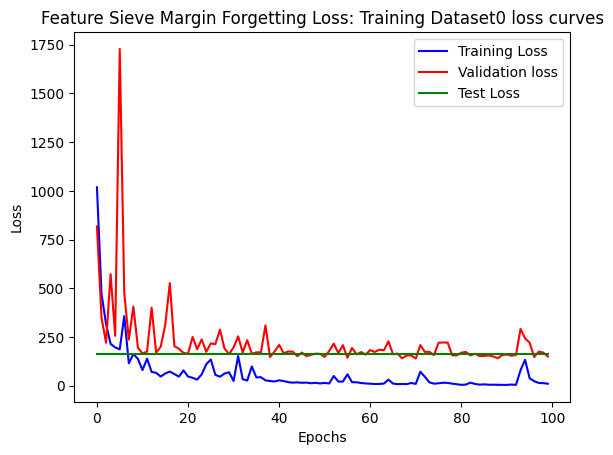

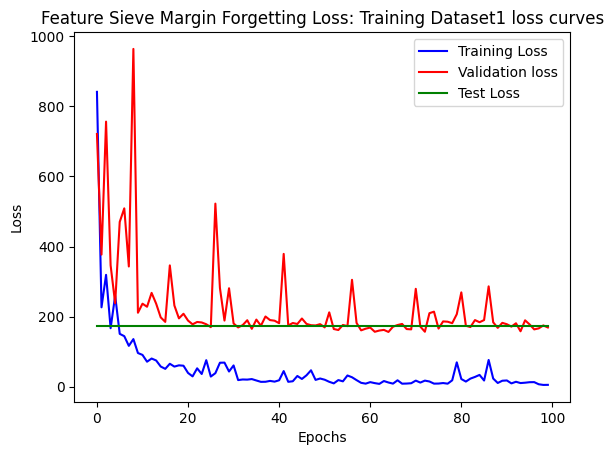

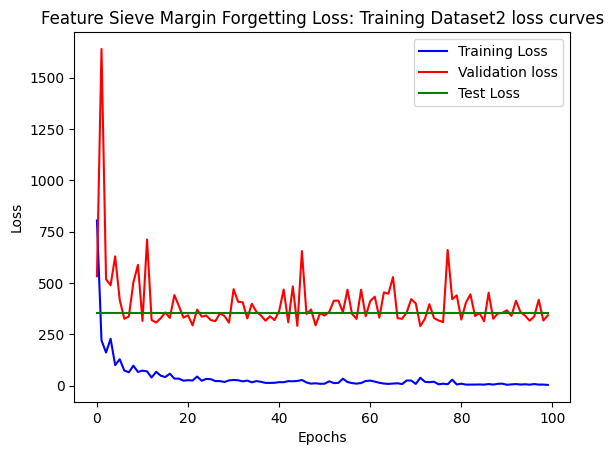

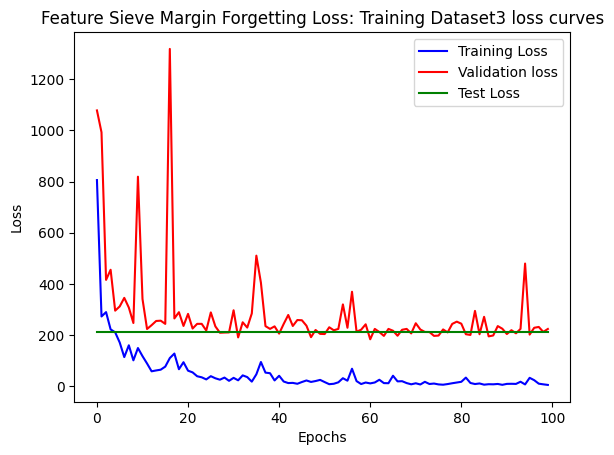

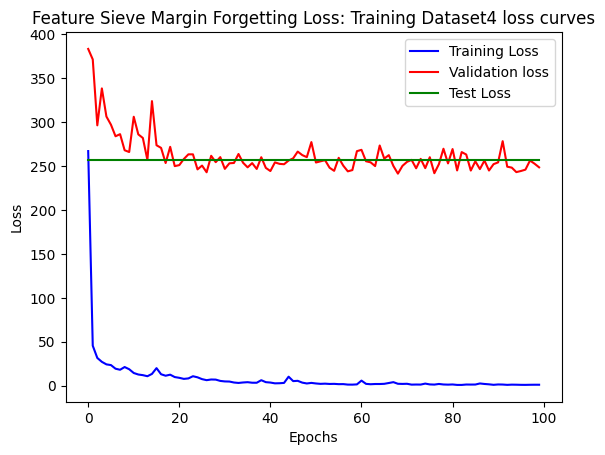

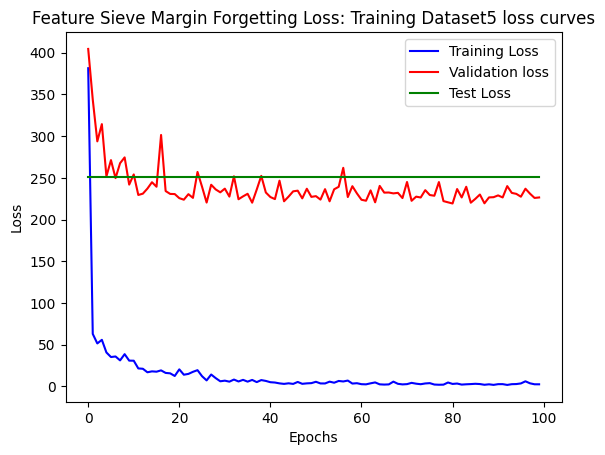

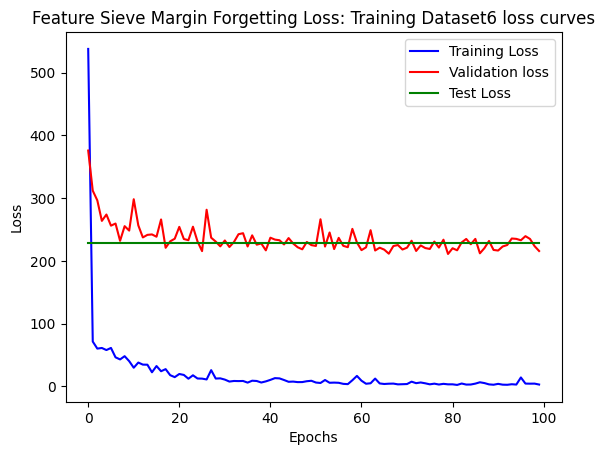

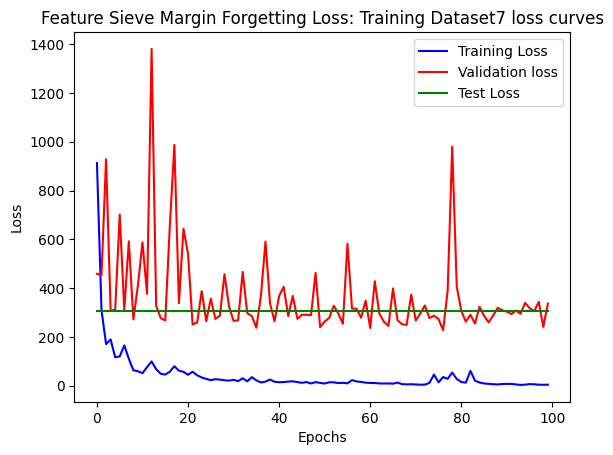

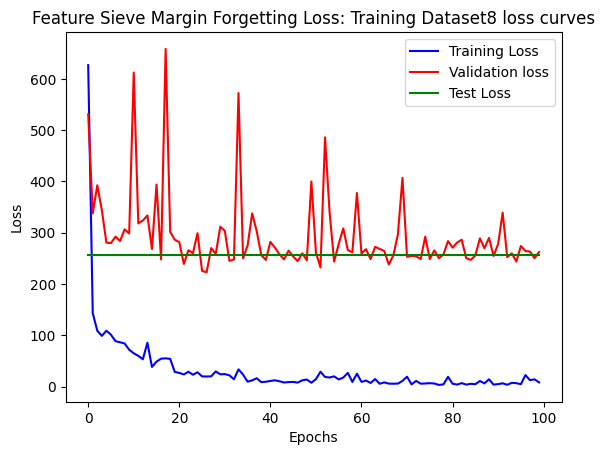

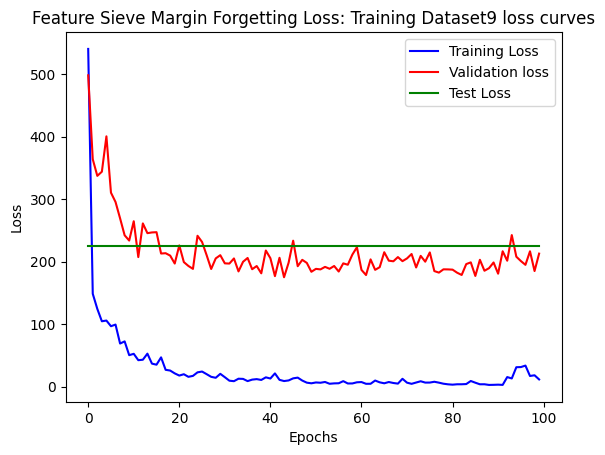

In [31]:
# plotting loss curves
for i in range(len(fs_tlosses)):
    plot_loss_curves(fs_tlosses[i], fs_vlosses[i], fs_tst_losses[i], epochs, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:51:18<00:00, 66.78s/it]


Test Loss: 69.43731689453125


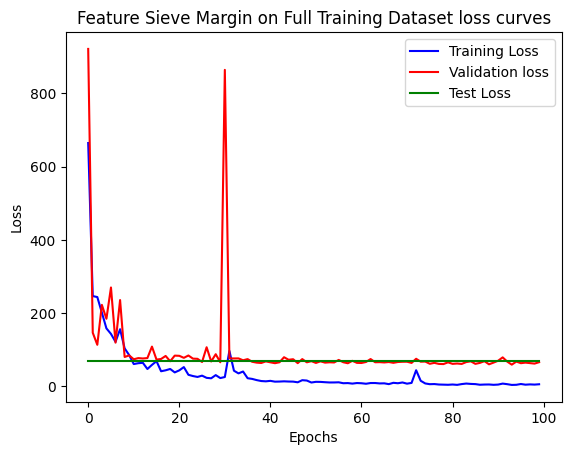

In [32]:
full_fs_margin = fs_margin(1, False).to(device)
full_fs_margin, tloss, vloss, _ = train_fs_mar(full_fs_margin, comp_train_dataloader, val_dataloader, margin=best_margin, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr], epochs=100, verbose=False)
full_fs_mar_tstloss = eval_FSModel(full_fs_margin, test_dataloader)

fs_tst_losses.insert(0,full_fs_mar_tstloss)
plot_loss_curves(tloss, vloss, full_fs_mar_tstloss, epochs=100, model_name="Feature Sieve Margin on Full Training Dataset")

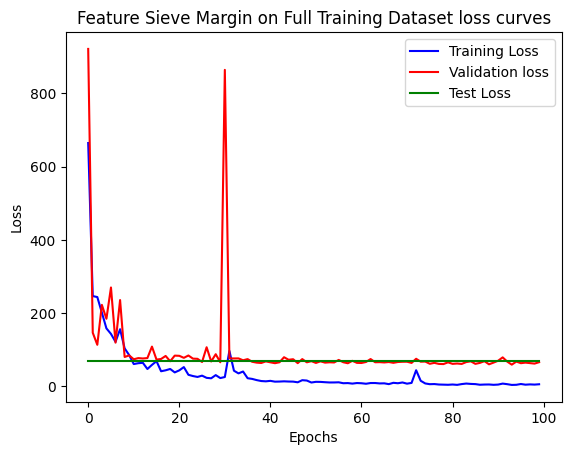

In [33]:
fs_tst_losses.insert(0,full_fs_mar_tstloss)
plot_loss_curves(tloss, vloss, full_fs_mar_tstloss, epochs=100, model_name="Feature Sieve Margin on Full Training Dataset")

## 2) Cross Entropy Forgetting Loss:

In [27]:
#Cross entropy model
class Feature_Sieve_CE(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_CE, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 128, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        x = self.layer1(sh)

        #forward of the main network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = F.softmax(self.aux_fc(aux), dim=-1)

        return logits, aux

def fs_ce(num_classes, num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_CE(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model
    

In [28]:
## Forgetting Loss: Cross Entropy
def learn_main_ce(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux_ce(FS, optim_main, optim_aux, x, y, bins, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    y = torch.bucketize(y,bins, right=False).reshape(-1)
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()
    return loss

def forget_aux_ce(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()

In [29]:
#Functions
def train_fs_ce(model, train_dataloader, val_dataloader, age, num_bins = 20, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=20, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training Model............")
        
    train_losses= []
    val_losses = []
    aux_losses = []

    bin_counts, bin_edges = np.histogram(age, bins = num_bins -1 )
    bins = torch.tensor(bin_edges).to(device)
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # Training part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ce(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ce(model, optim_main, optim_aux, x, y, bins)
            if forget_iters and steps % forget_iters == 0:
                forget_aux_ce(model, optim_forget, x, num_bins)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses

Training Model............


  1%|█▌                                                                                                                                                           | 1/100 [00:27<45:13, 27.41s/it]

Epochs: 0/100 Training Loss: 827.5842895507812 Validation Loss: 521.51611328125


  2%|███▏                                                                                                                                                         | 2/100 [00:54<44:43, 27.39s/it]

Epochs: 1/100 Training Loss: 295.16534423828125 Validation Loss: 236.9951629638672


  3%|████▋                                                                                                                                                        | 3/100 [01:22<44:37, 27.60s/it]

Epochs: 2/100 Training Loss: 174.6689910888672 Validation Loss: 215.3685302734375


  4%|██████▎                                                                                                                                                      | 4/100 [01:51<44:47, 27.99s/it]

Epochs: 3/100 Training Loss: 172.5572509765625 Validation Loss: 186.7392578125


  5%|███████▊                                                                                                                                                     | 5/100 [02:20<44:53, 28.36s/it]

Epochs: 4/100 Training Loss: 145.8343505859375 Validation Loss: 226.47134399414062


  6%|█████████▍                                                                                                                                                   | 6/100 [02:51<45:55, 29.32s/it]

Epochs: 5/100 Training Loss: 173.39181518554688 Validation Loss: 251.2313690185547


  7%|██████████▉                                                                                                                                                  | 7/100 [03:25<47:42, 30.78s/it]

Epochs: 6/100 Training Loss: 106.14424896240234 Validation Loss: 163.76942443847656


  8%|████████████▌                                                                                                                                                | 8/100 [03:58<48:34, 31.68s/it]

Epochs: 7/100 Training Loss: 99.66930389404297 Validation Loss: 204.63441467285156


  9%|██████████████▏                                                                                                                                              | 9/100 [04:32<48:46, 32.16s/it]

Epochs: 8/100 Training Loss: 105.59336853027344 Validation Loss: 286.1537170410156


 10%|███████████████▌                                                                                                                                            | 10/100 [05:05<48:50, 32.56s/it]

Epochs: 9/100 Training Loss: 100.3307113647461 Validation Loss: 146.09190368652344


 11%|█████████████████▏                                                                                                                                          | 11/100 [05:39<48:49, 32.92s/it]

Epochs: 10/100 Training Loss: 101.86698150634766 Validation Loss: 206.67417907714844


 12%|██████████████████▋                                                                                                                                         | 12/100 [06:12<48:26, 33.03s/it]

Epochs: 11/100 Training Loss: 56.23571014404297 Validation Loss: 181.4991455078125


 13%|████████████████████▎                                                                                                                                       | 13/100 [06:46<48:29, 33.44s/it]

Epochs: 12/100 Training Loss: 159.64218139648438 Validation Loss: 1026.485107421875


 14%|█████████████████████▊                                                                                                                                      | 14/100 [07:19<47:35, 33.21s/it]

Epochs: 13/100 Training Loss: 64.56996154785156 Validation Loss: 370.6675720214844


 15%|███████████████████████▍                                                                                                                                    | 15/100 [07:52<46:46, 33.02s/it]

Epochs: 14/100 Training Loss: 48.27073287963867 Validation Loss: 213.63235473632812


 16%|████████████████████████▉                                                                                                                                   | 16/100 [08:26<46:42, 33.37s/it]

Epochs: 15/100 Training Loss: 83.059814453125 Validation Loss: 271.97265625


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [08:59<45:58, 33.23s/it]

Epochs: 16/100 Training Loss: 46.791072845458984 Validation Loss: 168.80145263671875


 18%|████████████████████████████                                                                                                                                | 18/100 [09:31<44:55, 32.87s/it]

Epochs: 17/100 Training Loss: 55.213218688964844 Validation Loss: 264.7220764160156


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [10:04<44:27, 32.93s/it]

Epochs: 18/100 Training Loss: 125.64678955078125 Validation Loss: 159.53811645507812


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [10:39<44:40, 33.51s/it]

Epochs: 19/100 Training Loss: 39.541908264160156 Validation Loss: 196.4532470703125


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [11:11<43:30, 33.04s/it]

Epochs: 20/100 Training Loss: 37.84379959106445 Validation Loss: 150.0245819091797


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [11:43<42:41, 32.84s/it]

Epochs: 21/100 Training Loss: 28.009654998779297 Validation Loss: 170.6394500732422


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [12:18<42:57, 33.47s/it]

Epochs: 22/100 Training Loss: 36.2221565246582 Validation Loss: 180.01181030273438


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [12:50<42:01, 33.18s/it]

Epochs: 23/100 Training Loss: 26.173389434814453 Validation Loss: 144.81185913085938


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [13:24<41:46, 33.42s/it]

Epochs: 24/100 Training Loss: 30.618831634521484 Validation Loss: 181.89100646972656


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [13:58<41:08, 33.35s/it]

Epochs: 25/100 Training Loss: 26.06795883178711 Validation Loss: 176.2346649169922


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [14:33<41:15, 33.91s/it]

Epochs: 26/100 Training Loss: 45.39636993408203 Validation Loss: 173.91114807128906


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [15:08<41:07, 34.27s/it]

Epochs: 27/100 Training Loss: 78.6139144897461 Validation Loss: 197.8458251953125


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [15:40<39:54, 33.72s/it]

Epochs: 28/100 Training Loss: 35.259681701660156 Validation Loss: 172.2644500732422


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [16:16<39:50, 34.15s/it]

Epochs: 29/100 Training Loss: 30.04803466796875 Validation Loss: 158.15545654296875


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [16:48<38:41, 33.64s/it]

Epochs: 30/100 Training Loss: 54.76483154296875 Validation Loss: 148.9989013671875


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [17:22<38:09, 33.67s/it]

Epochs: 31/100 Training Loss: 78.79093170166016 Validation Loss: 180.35983276367188


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [17:56<37:42, 33.77s/it]

Epochs: 32/100 Training Loss: 66.89480590820312 Validation Loss: 168.1258544921875


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [18:28<36:37, 33.30s/it]

Epochs: 33/100 Training Loss: 27.50237464904785 Validation Loss: 180.0670166015625


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [19:03<36:29, 33.69s/it]

Epochs: 34/100 Training Loss: 36.05628204345703 Validation Loss: 169.83995056152344


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [19:36<35:53, 33.64s/it]

Epochs: 35/100 Training Loss: 82.13446807861328 Validation Loss: 150.9318389892578


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [20:10<35:24, 33.73s/it]

Epochs: 36/100 Training Loss: 46.24989700317383 Validation Loss: 187.5949249267578


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [20:43<34:46, 33.65s/it]

Epochs: 37/100 Training Loss: 101.11001586914062 Validation Loss: 151.7360382080078


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [21:17<34:05, 33.54s/it]

Epochs: 38/100 Training Loss: 20.778854370117188 Validation Loss: 150.6208953857422


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [21:51<33:39, 33.66s/it]

Epochs: 39/100 Training Loss: 127.49308013916016 Validation Loss: 161.46502685546875


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [22:25<33:09, 33.73s/it]

Epochs: 40/100 Training Loss: 70.88154602050781 Validation Loss: 162.5419921875


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [22:59<32:43, 33.86s/it]

Epochs: 41/100 Training Loss: 28.0424861907959 Validation Loss: 236.3531494140625


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [23:33<32:12, 33.91s/it]

Epochs: 42/100 Training Loss: 18.776321411132812 Validation Loss: 165.50685119628906


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [24:06<31:29, 33.74s/it]

Epochs: 43/100 Training Loss: 91.66858673095703 Validation Loss: 163.1114959716797


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [24:40<31:03, 33.88s/it]

Epochs: 44/100 Training Loss: 41.73631286621094 Validation Loss: 222.46762084960938


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [25:12<30:01, 33.36s/it]

Epochs: 45/100 Training Loss: 16.874984741210938 Validation Loss: 143.52047729492188


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [25:47<29:40, 33.59s/it]

Epochs: 46/100 Training Loss: 14.175973892211914 Validation Loss: 160.6997528076172


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [26:22<29:32, 34.09s/it]

Epochs: 47/100 Training Loss: 17.61351203918457 Validation Loss: 157.39520263671875


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [26:56<29:05, 34.23s/it]

Epochs: 48/100 Training Loss: 14.2526216506958 Validation Loss: 134.07485961914062


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [27:32<28:46, 34.52s/it]

Epochs: 49/100 Training Loss: 12.378290176391602 Validation Loss: 153.84019470214844


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [28:04<27:34, 33.76s/it]

Epochs: 50/100 Training Loss: 8.60246753692627 Validation Loss: 139.12205505371094


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [28:37<26:56, 33.68s/it]

Epochs: 51/100 Training Loss: 8.377202033996582 Validation Loss: 153.8565673828125


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [29:10<26:10, 33.40s/it]

Epochs: 52/100 Training Loss: 8.486122131347656 Validation Loss: 127.05093383789062


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [29:45<25:54, 33.80s/it]

Epochs: 53/100 Training Loss: 10.699882507324219 Validation Loss: 127.97359466552734


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [30:16<24:54, 33.20s/it]

Epochs: 54/100 Training Loss: 10.390143394470215 Validation Loss: 135.22853088378906


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [30:52<24:54, 33.96s/it]

Epochs: 55/100 Training Loss: 8.247485160827637 Validation Loss: 132.92974853515625


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [31:25<24:08, 33.68s/it]

Epochs: 56/100 Training Loss: 9.204575538635254 Validation Loss: 147.47598266601562


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [32:01<23:58, 34.24s/it]

Epochs: 57/100 Training Loss: 8.626449584960938 Validation Loss: 160.663818359375


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [32:35<23:23, 34.23s/it]

Epochs: 58/100 Training Loss: 10.418980598449707 Validation Loss: 136.44390869140625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [33:07<22:29, 33.74s/it]

Epochs: 59/100 Training Loss: 9.354941368103027 Validation Loss: 147.81423950195312


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [33:43<22:13, 34.18s/it]

Epochs: 60/100 Training Loss: 7.785813331604004 Validation Loss: 141.4354248046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [34:16<21:28, 33.90s/it]

Epochs: 61/100 Training Loss: 5.2731709480285645 Validation Loss: 150.47401428222656


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [34:49<20:47, 33.73s/it]

Epochs: 62/100 Training Loss: 5.334841728210449 Validation Loss: 137.31097412109375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [35:24<20:22, 33.97s/it]

Epochs: 63/100 Training Loss: 4.831803321838379 Validation Loss: 142.83030700683594


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [35:58<19:55, 34.17s/it]

Epochs: 64/100 Training Loss: 4.420369625091553 Validation Loss: 135.524658203125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [36:31<19:09, 33.80s/it]

Epochs: 65/100 Training Loss: 4.656691551208496 Validation Loss: 161.70985412597656


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [37:06<18:48, 34.19s/it]

Epochs: 66/100 Training Loss: 43.7232551574707 Validation Loss: 171.92071533203125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [37:40<18:04, 33.90s/it]

Epochs: 67/100 Training Loss: 134.79641723632812 Validation Loss: 253.07470703125


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [38:13<17:28, 33.82s/it]

Epochs: 68/100 Training Loss: 105.05876159667969 Validation Loss: 743.5848999023438


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [38:48<16:58, 33.94s/it]

Epochs: 69/100 Training Loss: 100.22724914550781 Validation Loss: 201.5155487060547


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [39:23<16:41, 34.54s/it]

Epochs: 70/100 Training Loss: 70.99446105957031 Validation Loss: 196.88807678222656


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [39:57<15:58, 34.24s/it]

Epochs: 71/100 Training Loss: 48.481971740722656 Validation Loss: 188.8062286376953


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [40:31<15:25, 34.27s/it]

Epochs: 72/100 Training Loss: 19.984880447387695 Validation Loss: 161.65219116210938


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [41:07<14:58, 34.57s/it]

Epochs: 73/100 Training Loss: 13.419352531433105 Validation Loss: 144.66456604003906


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [41:38<14:03, 33.72s/it]

Epochs: 74/100 Training Loss: 11.210236549377441 Validation Loss: 149.3433074951172


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [42:13<13:33, 33.90s/it]

Epochs: 75/100 Training Loss: 14.461878776550293 Validation Loss: 144.2133331298828


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [42:46<12:57, 33.79s/it]

Epochs: 76/100 Training Loss: 7.939141273498535 Validation Loss: 159.59677124023438


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [43:19<12:16, 33.46s/it]

Epochs: 77/100 Training Loss: 9.790718078613281 Validation Loss: 142.3200225830078


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [43:53<11:49, 33.76s/it]

Epochs: 78/100 Training Loss: 5.87026309967041 Validation Loss: 141.29066467285156


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [44:28<11:21, 34.06s/it]

Epochs: 79/100 Training Loss: 5.20678186416626 Validation Loss: 137.5656280517578


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [45:01<10:39, 33.68s/it]

Epochs: 80/100 Training Loss: 5.966711044311523 Validation Loss: 146.90794372558594


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [45:35<10:07, 33.77s/it]

Epochs: 81/100 Training Loss: 5.427988529205322 Validation Loss: 140.78054809570312


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [46:09<09:36, 33.94s/it]

Epochs: 82/100 Training Loss: 5.408186912536621 Validation Loss: 143.4456787109375


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [46:42<08:58, 33.68s/it]

Epochs: 83/100 Training Loss: 5.061482906341553 Validation Loss: 132.4809112548828


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [47:17<08:29, 34.00s/it]

Epochs: 84/100 Training Loss: 6.1964287757873535 Validation Loss: 141.28929138183594


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [47:52<08:02, 34.43s/it]

Epochs: 85/100 Training Loss: 5.1917524337768555 Validation Loss: 154.6790008544922


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [48:26<07:23, 34.10s/it]

Epochs: 86/100 Training Loss: 5.163937568664551 Validation Loss: 148.96319580078125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [49:01<06:52, 34.37s/it]

Epochs: 87/100 Training Loss: 5.491643905639648 Validation Loss: 140.40663146972656


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 89/100 [49:35<06:15, 34.17s/it]

Epochs: 88/100 Training Loss: 4.332306861877441 Validation Loss: 141.1698760986328


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 90/100 [50:09<05:42, 34.22s/it]

Epochs: 89/100 Training Loss: 4.476858615875244 Validation Loss: 149.94427490234375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 91/100 [50:42<05:05, 33.95s/it]

Epochs: 90/100 Training Loss: 4.621644496917725 Validation Loss: 168.26455688476562


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92/100 [51:16<04:32, 34.06s/it]

Epochs: 91/100 Training Loss: 113.12613677978516 Validation Loss: 256.6640930175781


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 93/100 [51:50<03:57, 33.99s/it]

Epochs: 92/100 Training Loss: 102.06559753417969 Validation Loss: 181.83416748046875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 94/100 [52:23<03:21, 33.59s/it]

Epochs: 93/100 Training Loss: 65.6714096069336 Validation Loss: 158.49765014648438


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 95/100 [52:57<02:49, 33.83s/it]

Epochs: 94/100 Training Loss: 20.408634185791016 Validation Loss: 154.94692993164062


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [53:32<02:16, 34.16s/it]

Epochs: 95/100 Training Loss: 45.225914001464844 Validation Loss: 148.90017700195312


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97/100 [54:04<01:40, 33.46s/it]

Epochs: 96/100 Training Loss: 26.38450050354004 Validation Loss: 205.6100616455078


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [54:39<01:07, 33.81s/it]

Epochs: 97/100 Training Loss: 13.403050422668457 Validation Loss: 126.92296600341797


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [55:12<00:33, 33.70s/it]

Epochs: 98/100 Training Loss: 10.558806419372559 Validation Loss: 156.74058532714844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:48<00:00, 33.48s/it]

Epochs: 99/100 Training Loss: 7.3060150146484375 Validation Loss: 132.5943603515625


Test Loss: 149.87060546875


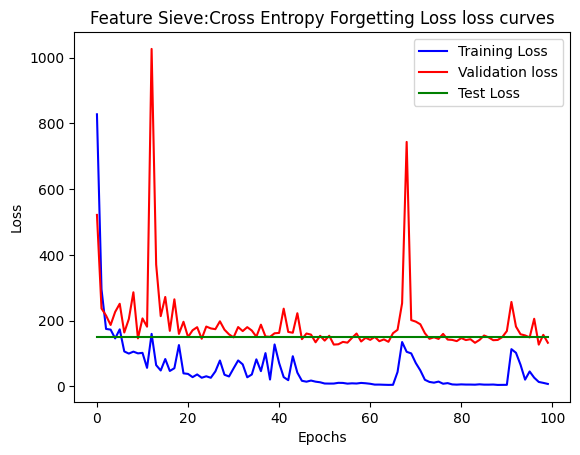

In [33]:
#Training
epochs = 100
num_bins = 20
ages = data_df['age'].values

fs_ce_model = fs_ce(1, num_bins, False).to(device)
fs_ce_model, fs_ce_tloss, fs_ce_vloss ,_ = train_fs_ce(fs_ce_model, train_dataloaders[0], val_dataloader, ages, num_bins = num_bins, verbose = True)
fs_ce_test_loss = eval_FSModel(fs_ce_model, test_dataloader)

plot_loss_curves(fs_ce_tloss, fs_ce_vloss, fs_ce_test_loss, epochs = epochs, model_name = "Feature Sieve:Cross Entropy Forgetting Loss")

In [46]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

num_bin = 20

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages,  num_bins=num_bin, forget_iters=forget_iters[i], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget Lr: {forget_lrs[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bin, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses=[]
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ce(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005, best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.09s/it]


Test Loss: 188.9726104736328
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.36s/it]


Test Loss: 209.47503662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 295.4831237792969
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.43s/it]


Test Loss: 273.8879089355469
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.85s/it]


Test Loss: 340.2899475097656
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.39s/it]


Test Loss: 1260.3504638671875
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.83s/it]


Test Loss: 203.2891387939453
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.96s/it]


Test Loss: 270.7403564453125
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.17s/it]


Test Loss: 218.1846923828125
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.13s/it]


Test Loss: 1014.4155883789062
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.03s/it]


Test Loss: 265.92352294921875
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.09s/it]


Test Loss: 561.5079956054688
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.62s/it]


Test Loss: 199.1851806640625
Best Forget Iter: 2
Forget Lr: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.30s/it]


Test Loss: 304.4369812011719
Forget Lr: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.79s/it]


Test Loss: 196.960693359375
Forget Lr: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.16s/it]


Test Loss: 477.94732666015625
Forget Lr: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.42s/it]


Test Loss: 593.125244140625
Forget Lr: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:01<00:00, 36.36s/it]


Test Loss: 227.2938690185547
Forget Lr: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 226.6198272705078
Forget Lr: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.53s/it]


Test Loss: 204.45501708984375
Forget Lr: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.89s/it]


Test Loss: 189.7186737060547
Best Forget Lr: 0.1
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.12s/it]


Test Loss: 301.1495361328125
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.43s/it]


Test Loss: 224.38694763183594
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.22s/it]


Test Loss: 321.97607421875
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.02s/it]


Test Loss: 211.0284423828125
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.63s/it]


Test Loss: 247.28042602539062
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.28s/it]


Test Loss: 235.97201538085938
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.46s/it]


Test Loss: 307.9757385253906
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.26s/it]


Test Loss: 287.79913330078125
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.05s/it]


Test Loss: 339.7842712402344
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.55s/it]


Test Loss: 204.39402770996094
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.84s/it]


Test Loss: 243.2328338623047
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.97s/it]


Test Loss: 270.8900451660156
Best Num Bins: 80


In [47]:
fs_ce_tloss = []
fs_ce_vloss = []
fs_ce_test_loss = []

best_num_bins = 3
best_forget_iters = 50 
best_forget_lr = 0.001

for i in range(len(train_dataloaders)):
    print(f"Training Dataset {i}")
    model = fs_ce(1, best_num_bins, False).to(device)
    model, fs_ce_loss, fs_ce_val_loss = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, num_bins = best_num_bins, forget_iters=best_forget_iters, lrs=[0.0005, 0.0005, best_forget_lr], verbose = False)
    fs_ce_tst_loss = eval_FSModel(model, test_dataloader)

    fs_ce_tloss.append(fs_ce_loss)
    fs_ce_vloss.append(fs_ce_val_loss)
    fs_ce_test_loss.append(fs_ce_tst_loss)

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Logged model into: ./Models/fs_ce_model{i}.pth")

Training Dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [52:04<00:00, 31.24s/it]


Test Loss: 174.06626892089844
Logged model into: ./Models/fs_ce_model0.pth
Training Dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:18<00:00, 32.58s/it]


Test Loss: 224.8866729736328
Logged model into: ./Models/fs_ce_model1.pth
Training Dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:20<00:00, 33.21s/it]


Test Loss: 304.33721923828125
Logged model into: ./Models/fs_ce_model2.pth
Training Dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:30<00:00, 33.31s/it]


Test Loss: 219.54811096191406
Logged model into: ./Models/fs_ce_model3.pth
Training Dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:24<00:00, 33.25s/it]


Test Loss: 266.0223388671875
Logged model into: ./Models/fs_ce_model4.pth
Training Dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:56<00:00, 33.56s/it]


Test Loss: 235.9572296142578
Logged model into: ./Models/fs_ce_model5.pth
Training Dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:48<00:00, 33.48s/it]


Test Loss: 234.09063720703125
Logged model into: ./Models/fs_ce_model6.pth
Training Dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:12<00:00, 33.73s/it]


Test Loss: 368.1534423828125
Logged model into: ./Models/fs_ce_model7.pth
Training Dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:55<00:00, 33.56s/it]


Test Loss: 278.2205810546875
Logged model into: ./Models/fs_ce_model8.pth
Training Dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:08<00:00, 33.68s/it]


Test Loss: 207.40386962890625
Logged model into: ./Models/fs_ce_model9.pth


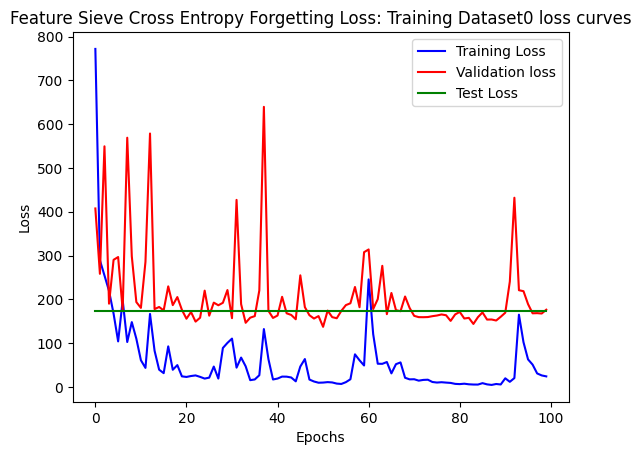

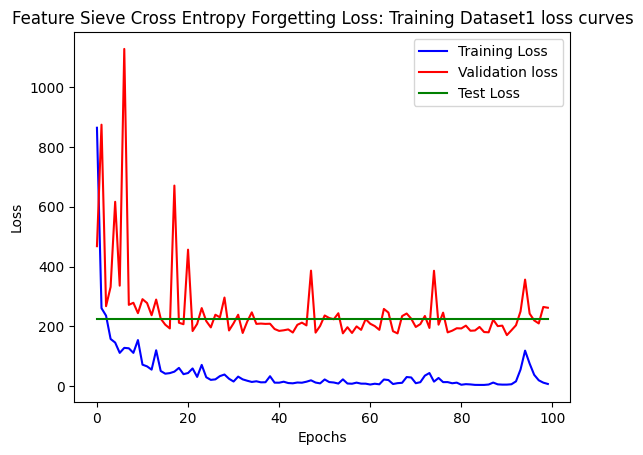

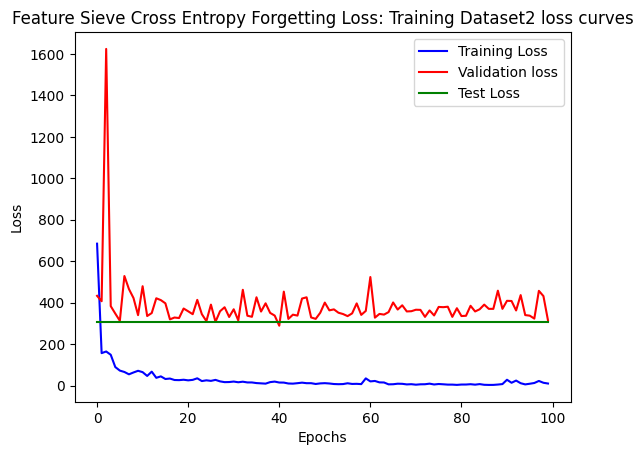

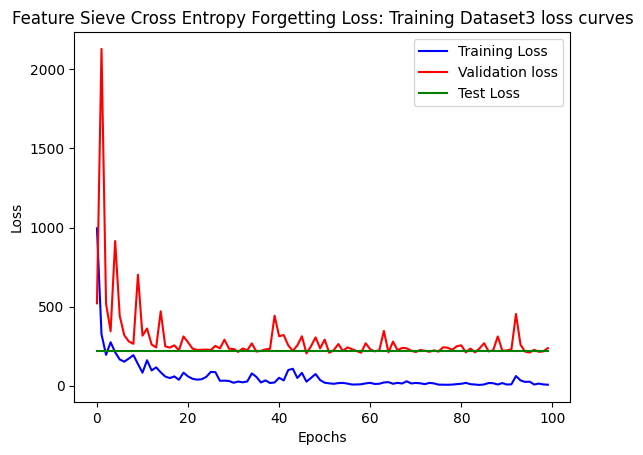

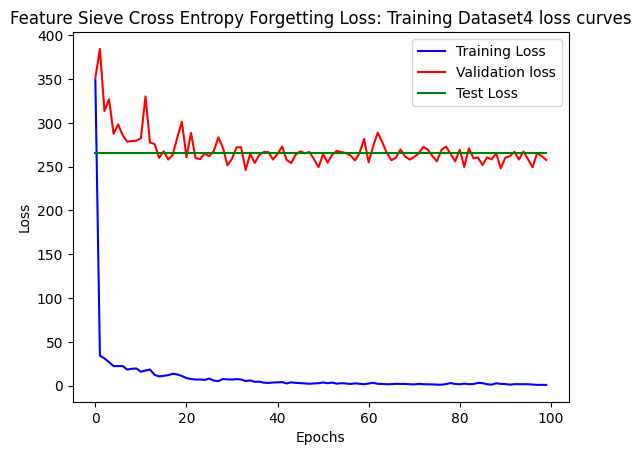

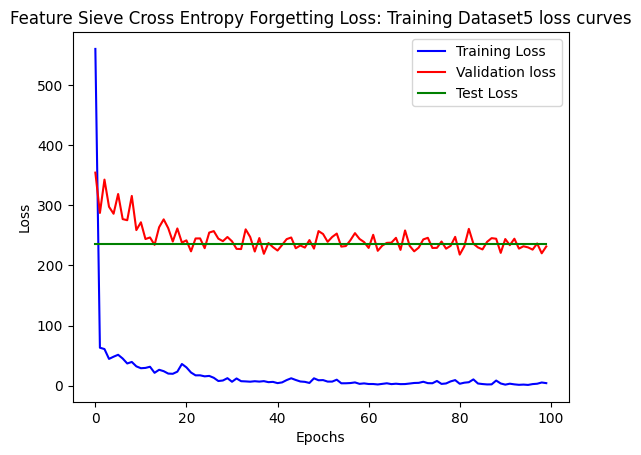

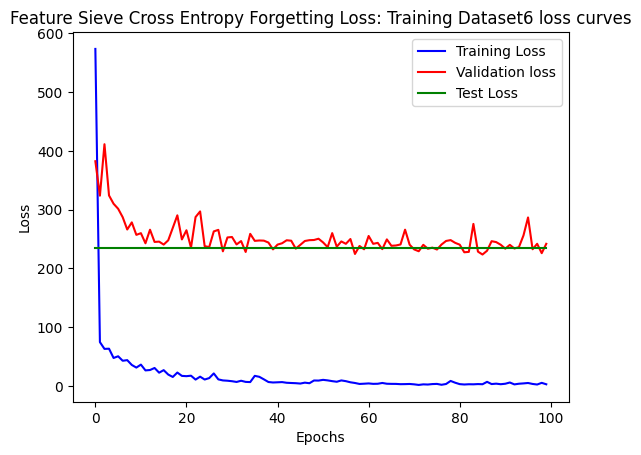

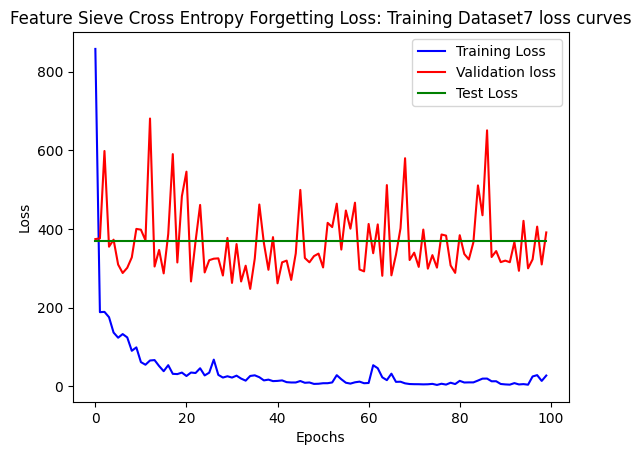

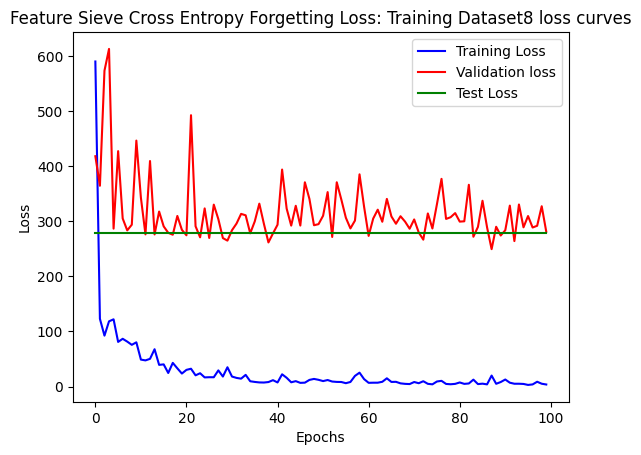

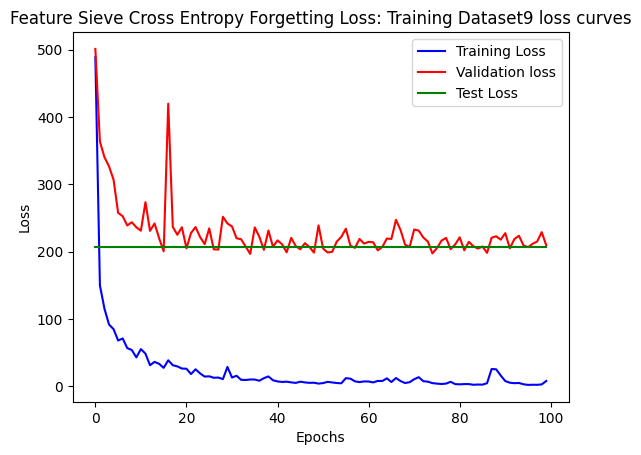

In [48]:
for i in range(len(fs_ce_tloss)):
    plot_loss_curves(fs_ce_tloss[i], fs_ce_vloss[i], fs_ce_test_loss[i], epochs= 100, model_name= "Feature Sieve Cross Entropy Forgetting Loss: Training Dataset{}".format(i))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:18:31<00:00, 83.11s/it]


Test Loss: 69.14472198486328


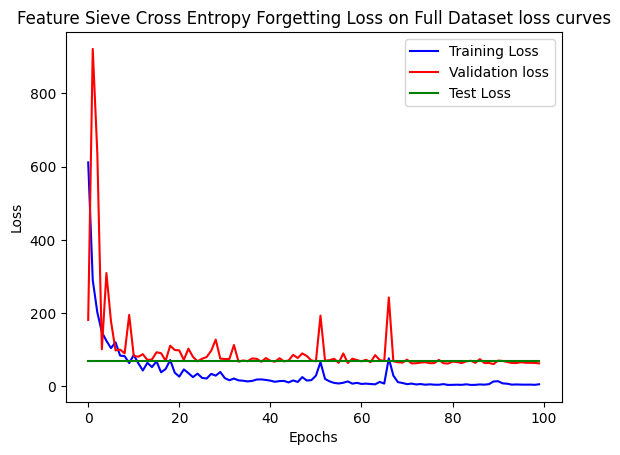

In [52]:
comp_fs_ce = fs_ce(1, best_num_bins, False).to(device)
comp_fs_ce, tloss, vloss = train_fs_ce(comp_fs_ce, comp_train_dataloader, val_dataloader, ages, num_bins=best_num_bins, epochs=100, forget_iters=best_forget_iters, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
comp_tst_loss = eval_FSModel(comp_fs_ce, test_dataloader)
fs_ce_test_loss.insert(0, comp_tst_loss)

plot_loss_curves(tloss, vloss, comp_tst_loss, epochs=100, model_name="Feature Sieve Cross Entropy Forgetting Loss on Full Dataset")

## 3) Ordinal Forgetting Loss

In [30]:
# Ordinal Model
class Feature_Sieve_Ord(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Ord, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        
        return logits, aux

def fs_ord(num_classes,num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Ord(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model

In [31]:
# Multilabel Loss function
multi_label_loss = nn.BCEWithLogitsLoss()

def learn_main_ordinal(model, optim_main,x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord, alpha_aux=1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * multi_label_loss(aux, y_ord)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux_ordinal(model, optim_forget, x,y, num_bins):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    aux_preds = torch.sum(F.sigmoid(aux), dim =-1) * 116 / num_bins
    loss = F.mse_loss(aux_preds.reshape(-1,1), y)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()

In [32]:
#Functions
def train_fs_ord(model, train_dataloader, val_dataloader, num_bins=20, epochs = 100, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    train_losses= []
    val_losses = []
    aux_losses = []
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            y_ord = y.reshape(-1).numpy()
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            #Ordinal label generation
            y_ord = np.greater_equal.outer(y_ord, np.arange(num_bins)*116/num_bins).astype(float)
            y_ord = torch.tensor(y_ord).reshape(y_ord.shape[0], -1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ordinal(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord)
            if forget_iters and steps % forget_iters == 0:
                forget_aux_ordinal(model, optim_forget, x, y, num_bins)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses

In [35]:
fs_ord_model = fs_ord(1, 20, False).to(device)
fs_ord_model, fs_ord_tloss, fs_ord_vloss,_ = train_fs_ord(fs_ord_model, train_dataloaders[0], val_dataloader, num_bins = 20, verbose = False)
fs_ord_tst_loss = eval_FSModel(fs_ord_model, test_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:10<00:00, 28.31s/it]


Test Loss: 176.63095092773438


In [31]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ord(1,20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=forget_iters[i], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses=[]
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_ord(1, 20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget LR: {best_forget_lr}")

test_losses = []
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ord(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=num_bins[i], forget_iters=best_forget_iter, epochs=5, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.64s/it]


Test Loss: 1567.7342529296875
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.38s/it]


Test Loss: 949.28662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 293.83392333984375
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.26s/it]


Test Loss: 186.01007080078125
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.19s/it]


Test Loss: 250.61827087402344
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 206.6374969482422
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.35s/it]


Test Loss: 266.7720642089844
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


Test Loss: 279.9361267089844
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.13s/it]


Test Loss: 248.24282836914062
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.87s/it]


Test Loss: 397.17138671875
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]


Test Loss: 849.2794799804688
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.57s/it]


Test Loss: 326.846435546875
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.43s/it]


Test Loss: 189.51080322265625
Best Forget Iter: 20
Forget LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.28s/it]


Test Loss: 345.2628479003906
Forget LR: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.79s/it]


Test Loss: 172.997802734375
Forget LR: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 167.3886260986328
Forget LR: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 225.93434143066406
Forget LR: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 299.410888671875
Forget LR: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.71s/it]


Test Loss: 233.41815185546875
Forget LR: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.25s/it]


Test Loss: 286.5182189941406
Forget LR: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.29s/it]


Test Loss: 396.6966552734375
Best Forget LR: 0.0001
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


Test Loss: 198.12777709960938
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 272.1819152832031
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]


Test Loss: 300.36065673828125
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.00s/it]


Test Loss: 450.013427734375
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.15s/it]


Test Loss: 331.4488220214844
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.04s/it]


Test Loss: 196.8692626953125
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


Test Loss: 256.56707763671875
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.50s/it]


Test Loss: 245.00143432617188
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.47s/it]


Test Loss: 206.03347778320312
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 224.94801330566406
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.16s/it]


Test Loss: 205.9883270263672
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.51s/it]


Test Loss: 188.63841247558594
Best Num Bins: 100


In [32]:
# On Different Datasets
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_test_losses = []

best_forget_iter = 90
best_forget_lr = 0.0001
best_num_bins = 100

for i in range(len(train_dataloaders)):
    print(f"Training Dataset :{i}")
    fs_ord_model = fs_ord(1, best_num_bins, False).to(device)
    fs_ord_model, fs_ord_tloss, fs_ord_vloss = train_fs_ord(fs_ord_model, train_dataloaders[i], val_dataloader, num_bins = best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr],epochs=100, verbose = False)
    fs_ord_test_loss = eval_FSModel(fs_ord_model, test_dataloader)

    fs_ord_tlosses.append(fs_ord_tloss)
    fs_ord_vlosses.append(fs_ord_vloss)
    fs_ord_test_losses.append(fs_ord_test_loss)
    
    torch.save(fs_ord_model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Logged Model to ./Models/fs_ord_model{i}.pth")

Training Dataset :0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:02<00:00, 28.23s/it]


Test Loss: 167.37442016601562
Logged Model to ./Models/fs_ord_model0.pth
Training Dataset :1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:12<00:00, 28.32s/it]


Test Loss: 176.6057891845703
Logged Model to ./Models/fs_ord_model1.pth
Training Dataset :2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:06<00:00, 28.27s/it]


Test Loss: 326.765380859375
Logged Model to ./Models/fs_ord_model2.pth
Training Dataset :3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:58<00:00, 28.18s/it]


Test Loss: 212.7412872314453
Logged Model to ./Models/fs_ord_model3.pth
Training Dataset :4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:19<00:00, 28.39s/it]


Test Loss: 256.0242614746094
Logged Model to ./Models/fs_ord_model4.pth
Training Dataset :5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:14<00:00, 28.34s/it]


Test Loss: 234.5452117919922
Logged Model to ./Models/fs_ord_model5.pth
Training Dataset :6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:07<00:00, 28.28s/it]


Test Loss: 238.74819946289062
Logged Model to ./Models/fs_ord_model6.pth
Training Dataset :7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:01<00:00, 28.22s/it]


Test Loss: 300.202880859375
Logged Model to ./Models/fs_ord_model7.pth
Training Dataset :8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:24<00:00, 28.44s/it]


Test Loss: 299.679443359375
Logged Model to ./Models/fs_ord_model8.pth
Training Dataset :9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:15<00:00, 28.36s/it]


Test Loss: 201.1782684326172
Logged Model to ./Models/fs_ord_model9.pth


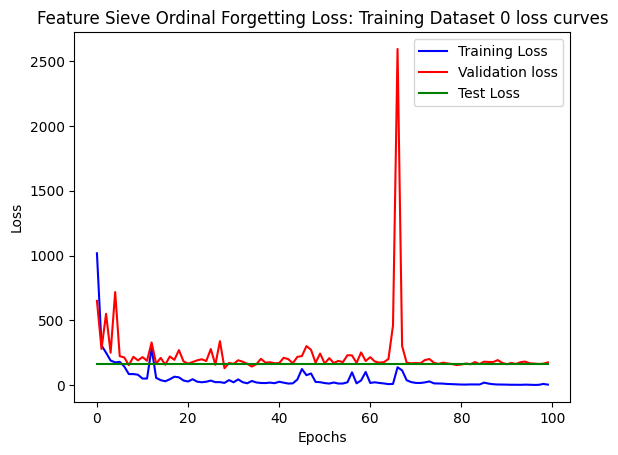

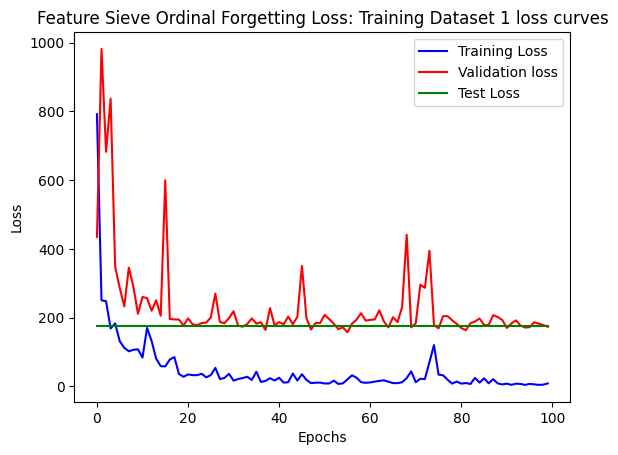

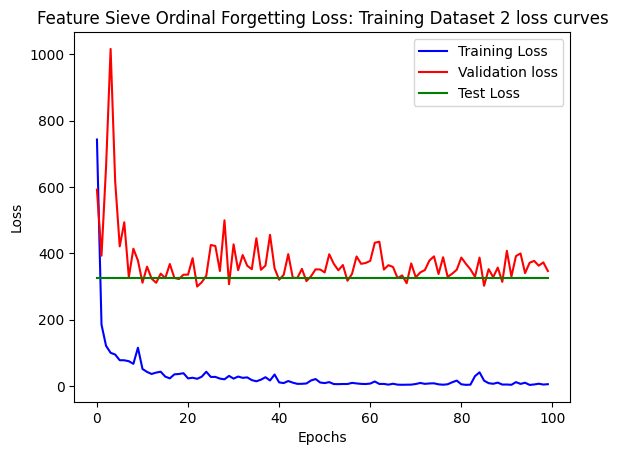

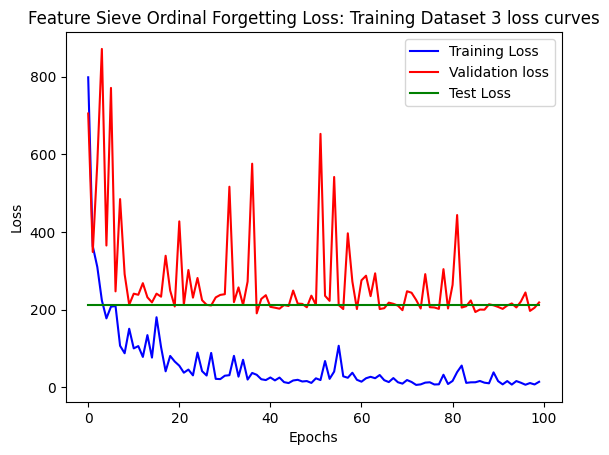

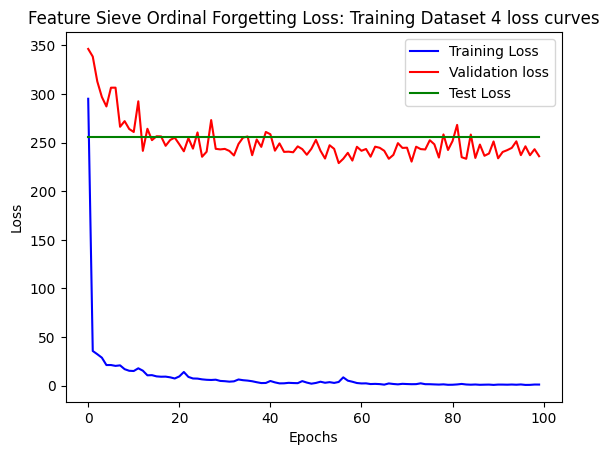

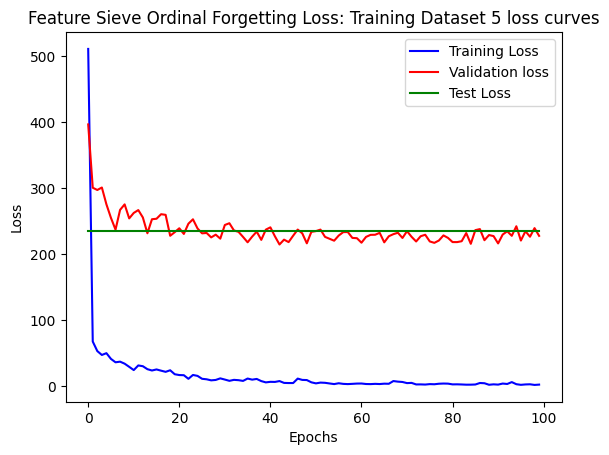

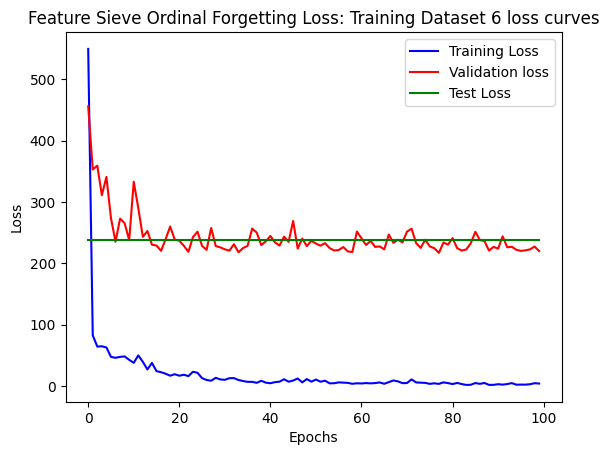

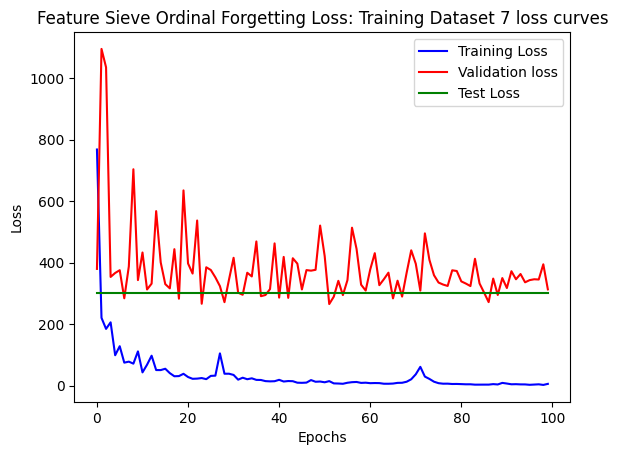

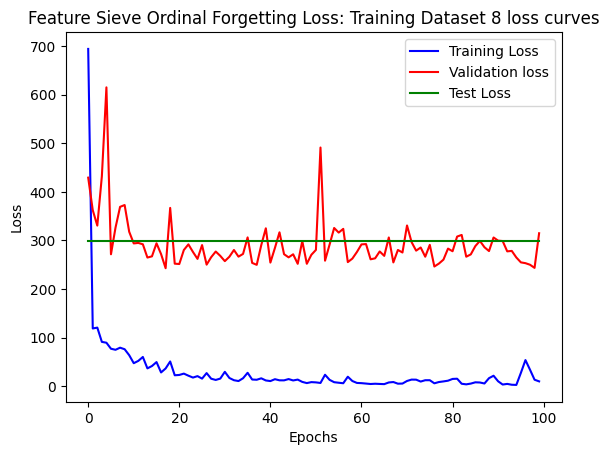

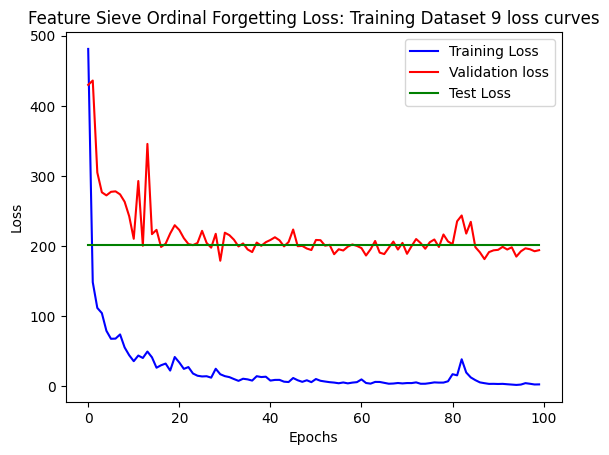

In [33]:
#plotting loss curves
for i in range(len(train_dataloaders)):
    plot_loss_curves(fs_ord_tlosses[i], fs_ord_vlosses[i], fs_ord_test_losses[i],  epochs=100, model_name = f"Feature Sieve Ordinal Forgetting Loss: Training Dataset {i}")

In [35]:
comp_fs_ord = fs_ord(1, best_num_bins, False).to(device)
comp_fs_ord, tloss, vloss = train_fs_ord(comp_fs_ord, comp_train_dataloader, val_dataloader, num_bins=best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, best_forget_lr], epochs=100, verbose=False)
comp_ord_tst_loss = eval_FSModel(comp_fs_ord, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:54:15<00:00, 68.56s/it]


Test Loss: 63.51879119873047


NameError: name 'comp_ord_test_loss' is not defined

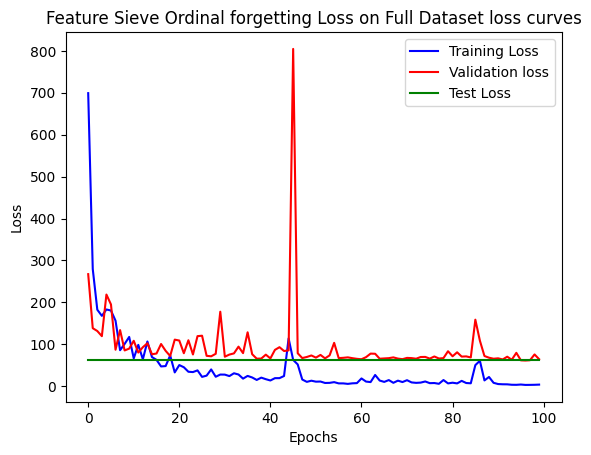

In [36]:
fs_ord_test_losses.insert(0, comp_ord_tst_loss)
plot_loss_curves(tloss, vloss, comp_ord_tst_loss, epochs=100, model_name="Feature Sieve Ordinal forgetting Loss on Full Dataset")

## Models on Dataset without Bias

Length of the Train Dataset with no bias: 5000


/tmp/ipykernel_1283413/1316461109.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
/tmp/ipykernel_1283413/1316461109.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_train_df_nb = train_df_nb[train_df.gender == 1].age.values


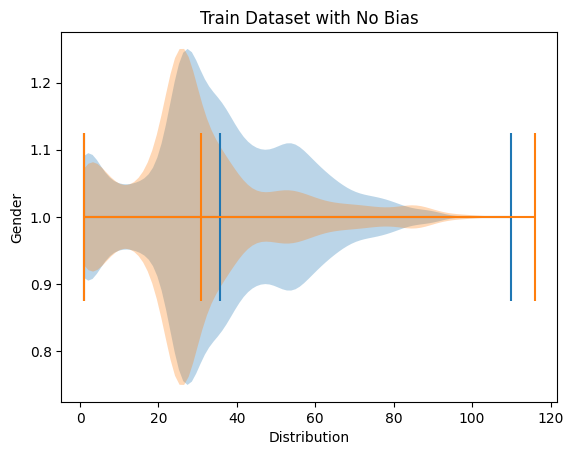

In [36]:
train_df_nb = train_df.sample(n=5000).reset_index(drop = True)
no_bias_dataset = UTKFaceDataset(dataframe = train_df_nb,
                                image_dir = DIR_PATH,
                                transform = custom_transform)

print(f"Length of the Train Dataset with no bias: {len(no_bias_dataset)}")

no_bias_dataloader = DataLoader(dataset = no_bias_dataset,
                               shuffle = True,
                               batch_size = BATCH_SIZE)

male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
female_train_df_nb = train_df_nb[train_df.gender == 1].age.values
plt.violinplot(male_train_df, vert=False, showmeans = True)
plt.violinplot(female_train_df, vert = False, showmeans= True)
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.title("Train Dataset with No Bias")
plt.savefig("./Datasets/Train_Dataset_no_bias.png")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:26<00:00, 17.66s/it]


Test Loss: 85.60638427734375


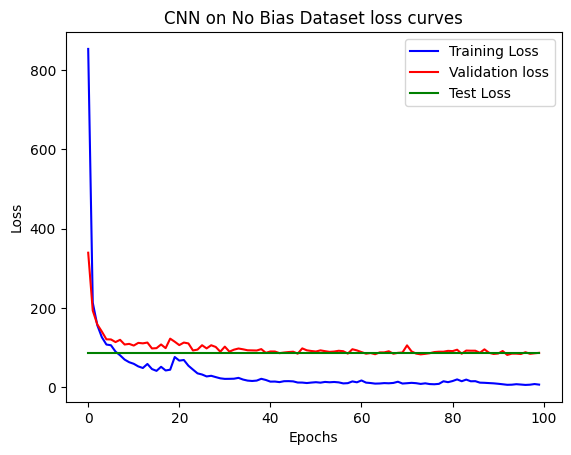

In [39]:
# Baseline
model = resnet34(1, False).to(device)
model, train_losses, val_losses = train(model, no_bias_dataloader, val_dataloader, epochs  =100, verbose = False)
test_loss = eval_model(model, test_dataloader)

plot_loss_curves(train_losses, val_losses, test_loss, epochs =100, model_name = "CNN on No Bias Dataset")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:49<00:00, 28.09s/it]


Test Loss: 101.37899017333984


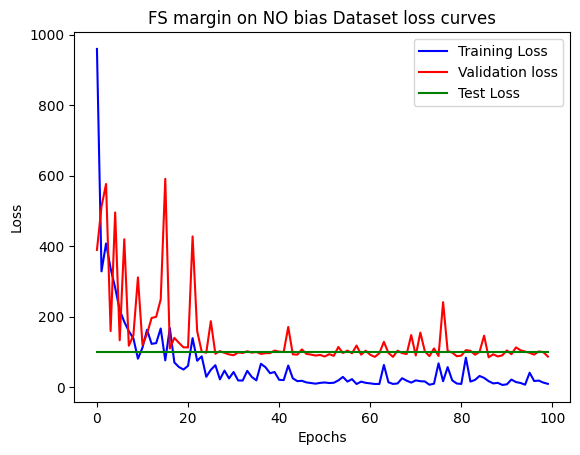

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:28<00:00, 33.29s/it]


Test Loss: 103.60517120361328


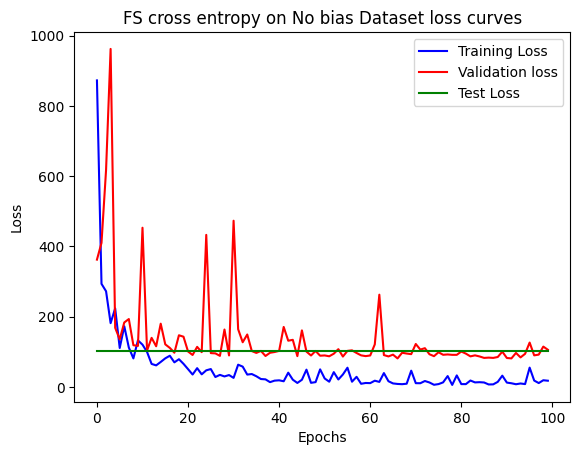

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:46<00:00, 28.07s/it]


Test Loss: 97.99505615234375


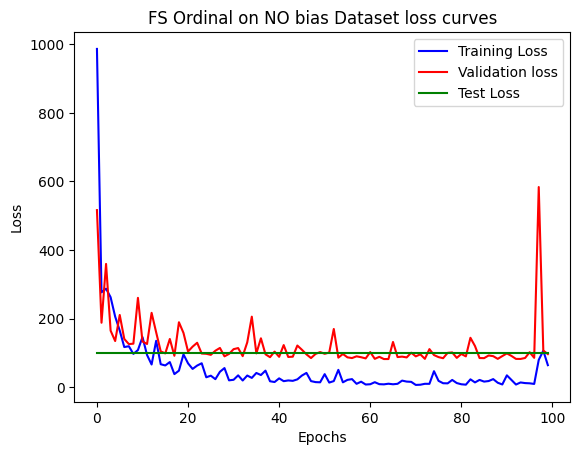

In [35]:
## Feature sieve Model
### Margin Forgetting Loss
best_forget_lr = 1e-5
best_forget_iter = 20
best_margin = 150

model = fs_margin(1, False).to(device)
model, train_losses, val_losses, _ = train_fs_mar(model, no_bias_dataloader, val_dataloader, verbose = False, epochs = 100, margin=best_margin, forget_iters=best_forget_iter, lrs=[5e-4, 5e-4, best_forget_lr])
test_loss = eval_FSModel(model, test_dataloader)
plot_loss_curves(train_losses, val_losses, test_loss, epochs = 100, model_name= "FS margin on NO bias Dataset")

### Cross Entropy forgetting Loss
best_forget_lr = 0.001
best_forget_iters = 50
best_num_bins = 3

model = fs_ce(1, best_num_bins, False).to(device)
model, fs_ce_loss, fs_ce_val_loss, _ = train_fs_ce(model, no_bias_dataloader, val_dataloader, ages, num_bins = best_num_bins, forget_iters=best_forget_iters, lrs=[0.0005, 0.0005, best_forget_lr], verbose = False)
fs_ce_tst_loss = eval_FSModel(model, test_dataloader)
plot_loss_curves(fs_ce_loss, fs_ce_val_loss, fs_ce_tst_loss, epochs = 100, model_name = "FS cross entropy on No bias Dataset")

### ORdinal forgetting loss
best_forget_lr = 0.0001
best_forget_iter = 90
best_num_bins = 100

fs_ord_model = fs_ord(1, best_num_bins, False).to(device)
fs_ord_model, fs_ord_tloss, fs_ord_vloss, _ = train_fs_ord(fs_ord_model, no_bias_dataloader, val_dataloader, num_bins = best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr],epochs=100, verbose = False)
fs_ord_test_loss = eval_FSModel(fs_ord_model, test_dataloader)
plot_loss_curves(fs_ord_tloss, fs_ord_vloss, fs_ord_test_loss, epochs = 100, model_name = "FS Ordinal on NO bias Dataset")

In [40]:
## Bayesian model
x = train_df_nb.gender.values
x = x.reshape(-1,1)
y = train_df_nb.age.values

#Bayesian Regression Model
reg = linear_model.BayesianRidge()
reg.fit(x, y)

#Error Calculations
x_test = test_df.gender.values
x_test = x_test.reshape(-1,1)
y_test = test_df.age.values

y_pred = reg.predict(x_test)
Loss = (np.square(y_test - y_pred)).mean() 
print(f"Test Loss of Bayesian Model: {Loss}")

test_losses_bayesian.insert(1, Loss)

Test Loss of Bayesian Model: 373.19666348499425


## Plotting a comparison between Models in different Datasets

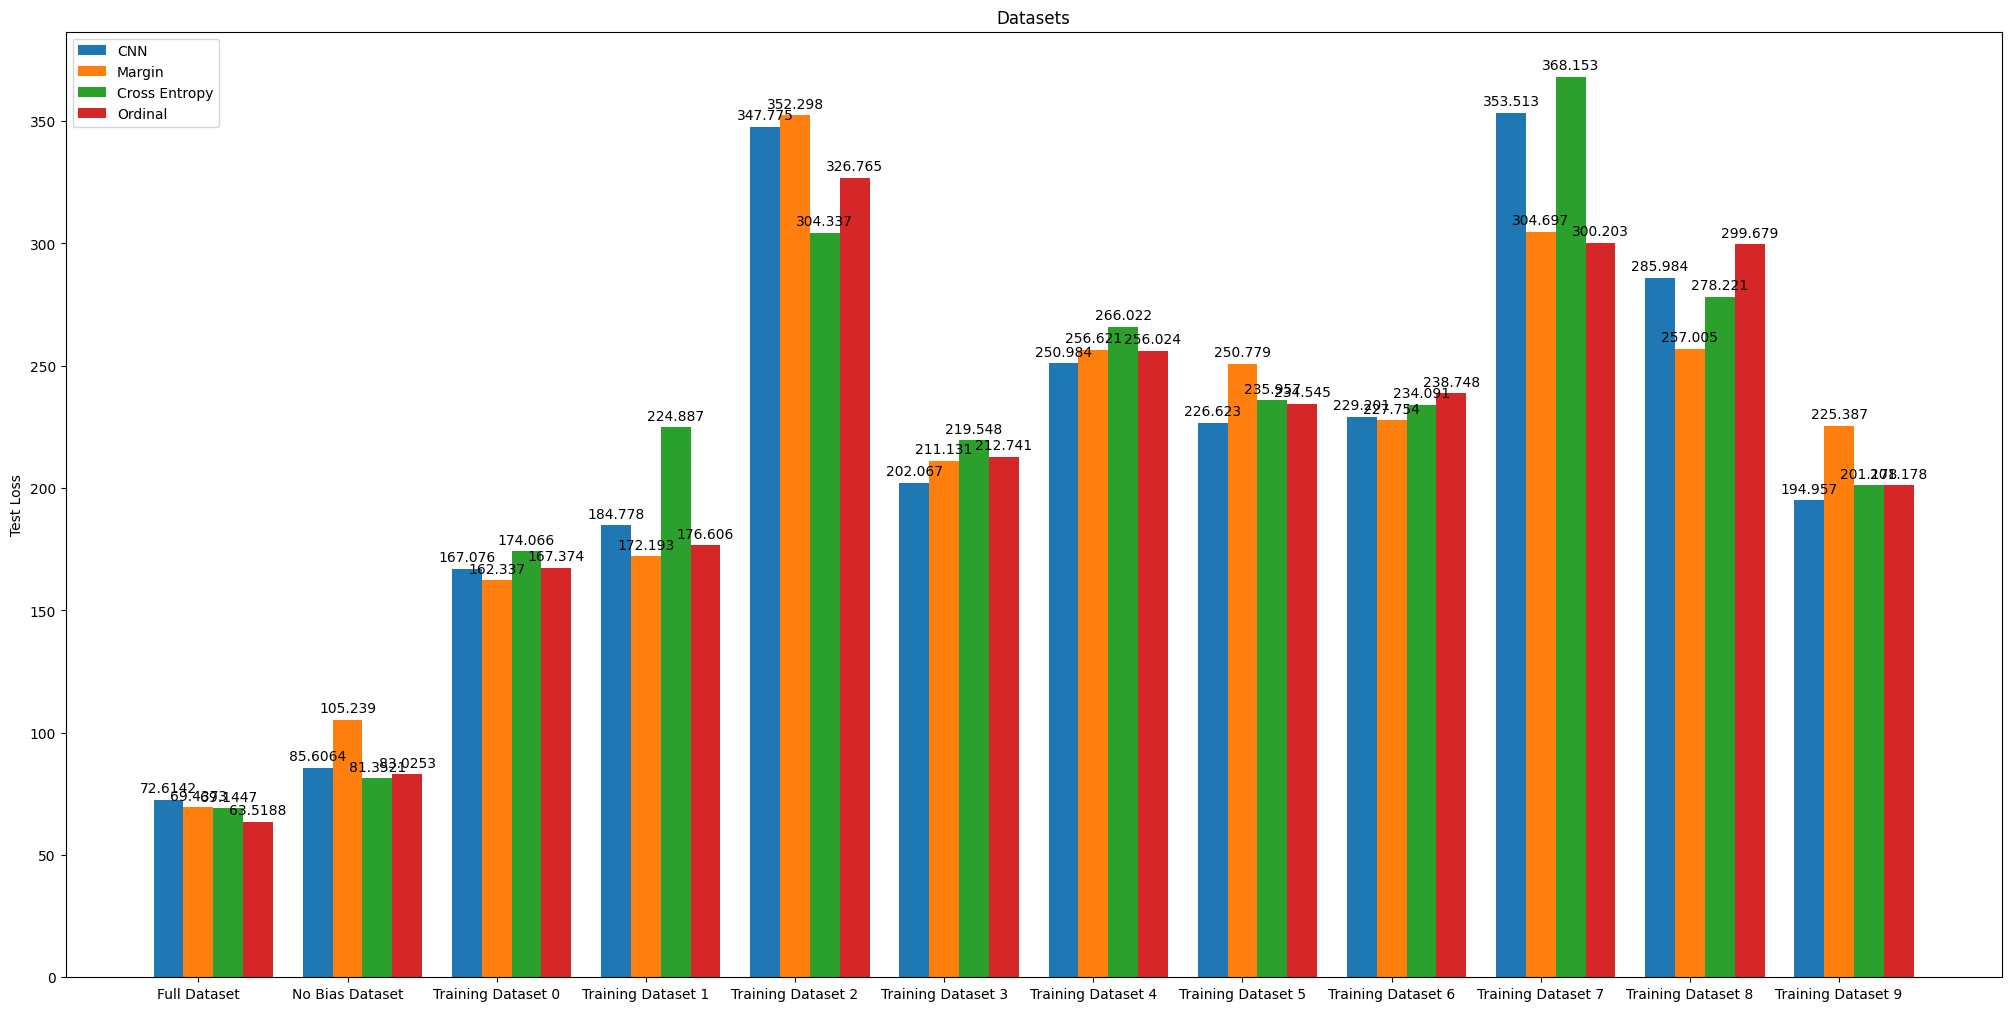

In [37]:
cnn_tst_loss = [72.61416625976562, 85.60638427734375, 167.07644653320312, 184.7777862548828, 347.7750549316406, 202.0666046142578, 250.9844512939453, 226.62294006347656, 229.2008819580078, 353.51263427734375, 285.98394775390625, 194.95729064941406]
fs_tst_losses = [69.43731689453125, 105.23925018310547, 162.33738708496094, 172.19313049316406, 352.29833984375, 211.13082885742188, 256.6214599609375, 250.77903747558594, 227.75367736816406, 304.69744873046875, 257.0054626464844, 225.3866729736328]
fs_ce_test_loss = [69.14472198486328,81.35213470458984,  174.06626892089844, 224.8866729736328, 304.33721923828125, 219.54811096191406, 266.0223388671875, 235.9572296142578, 234.09063720703125, 368.1534423828125, 278.2205810546875, 201.1782684326172]
fs_ord_test_losses = [63.51879119873047,83.02525329589844, 167.37442016601562, 176.6057891845703, 326.765380859375, 212.7412872314453, 256.0242614746094, 234.5452117919922, 238.74819946289062, 300.202880859375, 299.679443359375, 201.1782684326172]

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({"font.size":10})

datasets = [f"Training Dataset {i}" for i in range(10)]
datasets.insert(0, "Full Dataset")
datasets.insert(1, "No Bias Dataset")

test_losses = {
    "CNN": cnn_tst_loss,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_test_loss,
    "Ordinal": fs_ord_test_losses
}

x = np.arange(len(cnn_tst_loss))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for model_type, test_loss in test_losses.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, test_loss, width, label=model_type)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Test Loss")
ax.set_title("Datasets")
ax.set_xticks(x+ width, datasets)
ax.legend(loc="upper left")

plt.savefig("./Outputs/Test_Losses.png")
plt.show()

In [38]:
## lowest test loss models
test_losses  = [cnn_tst_loss, fs_tst_losses, fs_ce_test_loss, fs_ord_test_losses]
models = ["CNN", "Feature Sieve Margin", "Feature Sieve Cross Entropy", "Feature Sieve Ordinal"]

for i in range(len(cnn_tst_loss)):
    print(f"Dataset: {datasets[i]} ",end = "- ")
    tmp_losses  = []
    for j in range(len(test_losses)):
        tmp_losses.append(test_losses[j][i])

    print(models[tmp_losses.index(min(tmp_losses))])

Dataset: Full Dataset - Feature Sieve Ordinal
Dataset: No Bias Dataset - Feature Sieve Cross Entropy
Dataset: Training Dataset 0 - Feature Sieve Margin
Dataset: Training Dataset 1 - Feature Sieve Margin
Dataset: Training Dataset 2 - Feature Sieve Cross Entropy
Dataset: Training Dataset 3 - CNN
Dataset: Training Dataset 4 - CNN
Dataset: Training Dataset 5 - CNN
Dataset: Training Dataset 6 - Feature Sieve Margin
Dataset: Training Dataset 7 - Feature Sieve Ordinal
Dataset: Training Dataset 8 - Feature Sieve Margin
Dataset: Training Dataset 9 - CNN


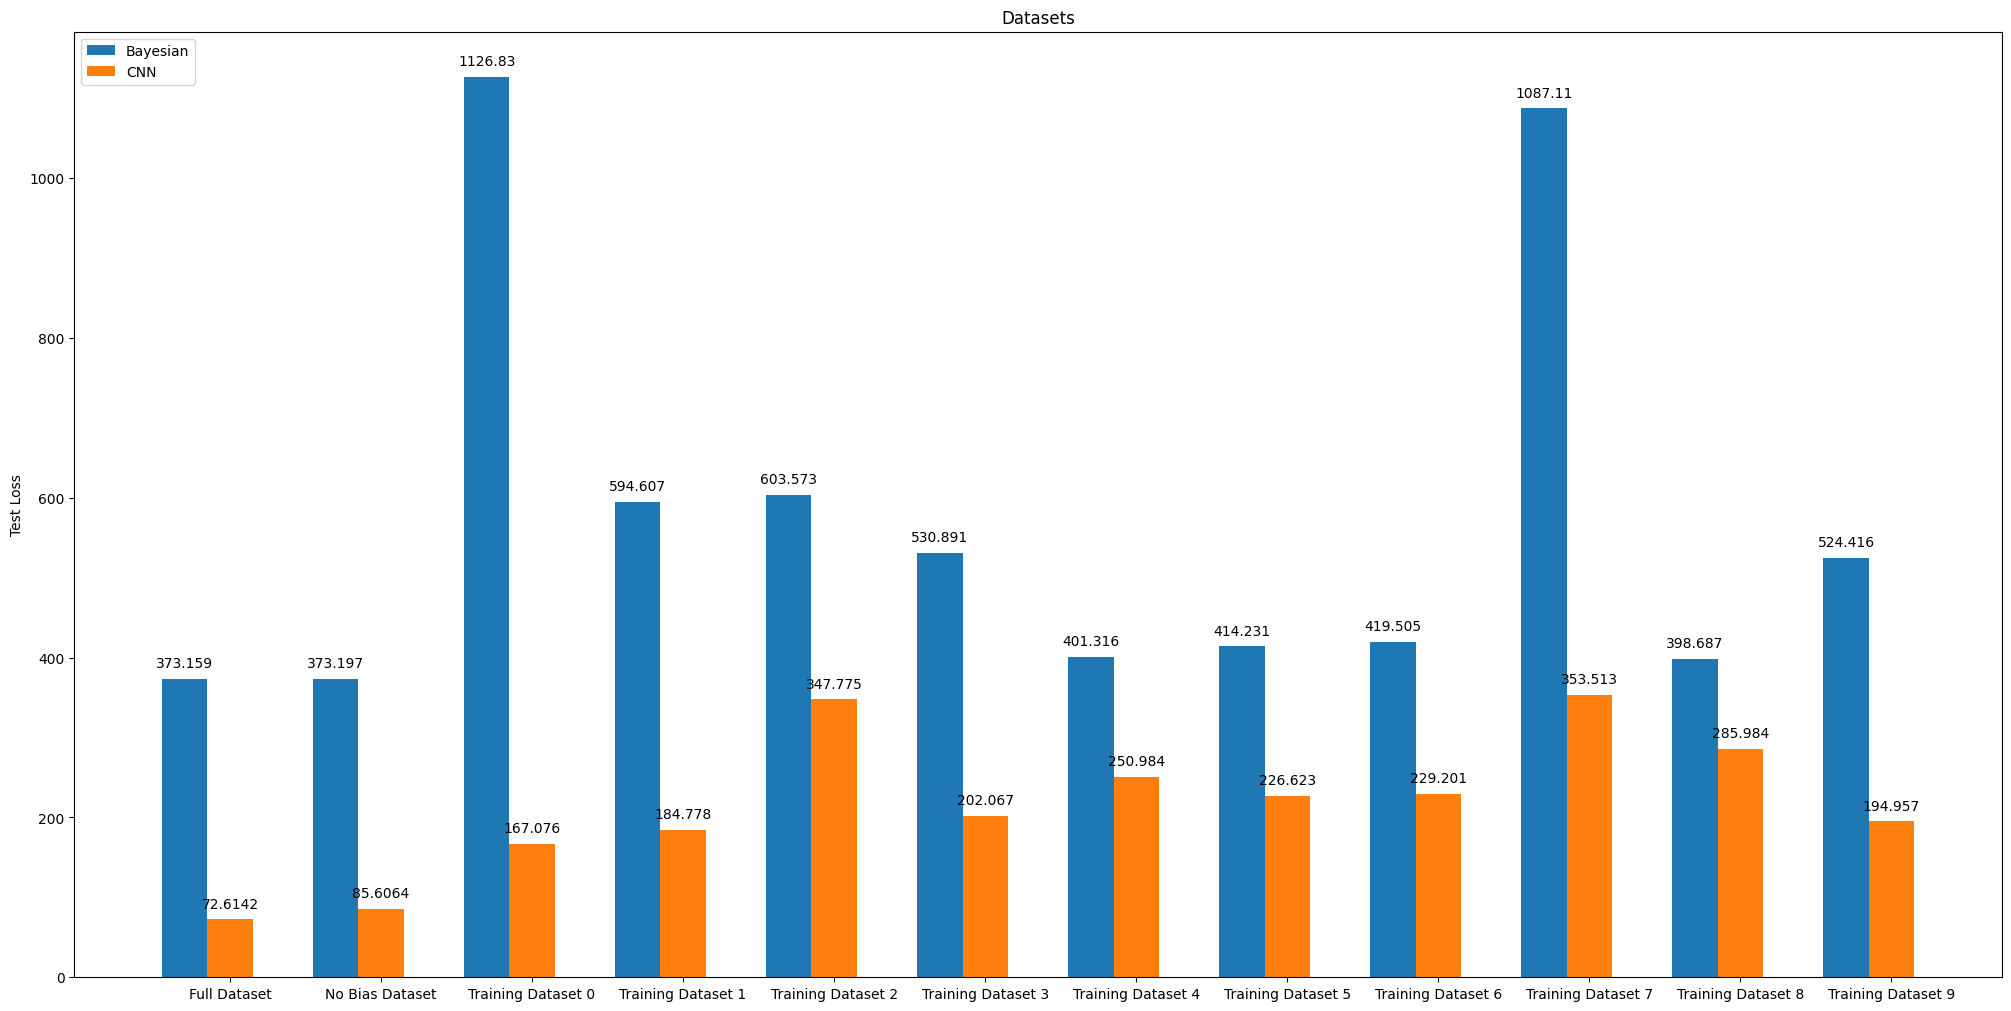

In [41]:
#plotting bayesian Losses
width = 0.3
multiplier = 0

test_losses = {
    "Bayesian": test_losses_bayesian,
    "CNN": cnn_tst_loss
}

fig, ax = plt.subplots(layout="constrained")
x = np.arange(len(cnn_tst_loss))

for model_type, test_loss in test_losses.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, test_loss, width, label=model_type)
    ax.bar_label(rects, padding=6)
    multiplier += 1

ax.set_ylabel("Test Loss")
ax.set_title("Datasets")
ax.set_xticks(x+ width, datasets)
ax.legend(loc="upper left")

plt.savefig("./Outputs/Test_Losses_Bayesian.png")
plt.show()

## Plotting the Bias of different datasets

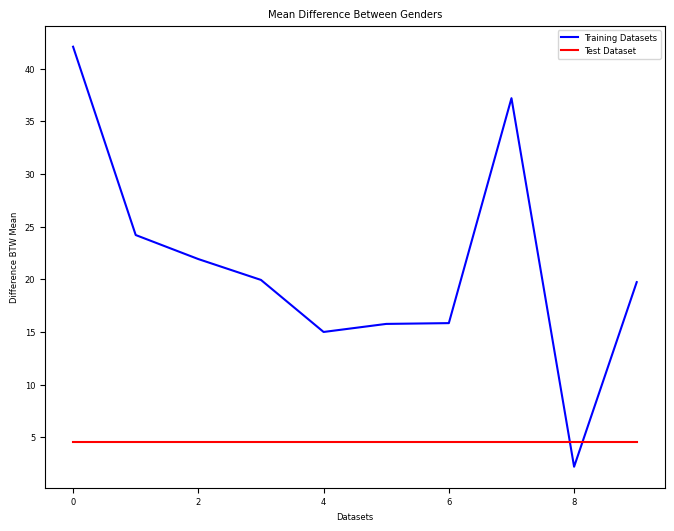

In [71]:
diff_mean = []
plt.rcParams["figure.figsize"] = (8.0, 6.0)
plt.rcParams.update({"font.size": 6.0})

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop= True)

    male_mean = male_df.age.mean()
    female_mean = female_df.age.mean()

    diff_mean.append(np.abs(male_mean - female_mean))

male_mean = test_df[test_df.gender == 0].age.mean()
female_mean = test_df[test_df.gender == 1].age.mean()
test_diff_mean = np.abs(male_mean - female_mean)

male_mean = val_df[val_df.gender  == 0].age.mean()
feamle_mean = val_df[val_df.gender == 1].age.mean()
val_diff_mean = np.abs(male_mean - female_mean)

plt.plot(range(len(diff_mean)), diff_mean, color = 'blue', label = "Training Datasets")
plt.plot(range(len(diff_mean)), [test_diff_mean] * len(diff_mean), color = 'red', label = "Test Dataset")
plt.xlabel("Datasets")
plt.ylabel("Difference BTW Mean")
plt.title("Mean Difference Between Genders")
plt.legend()
plt.savefig("Difference in Means.png")
plt.show()

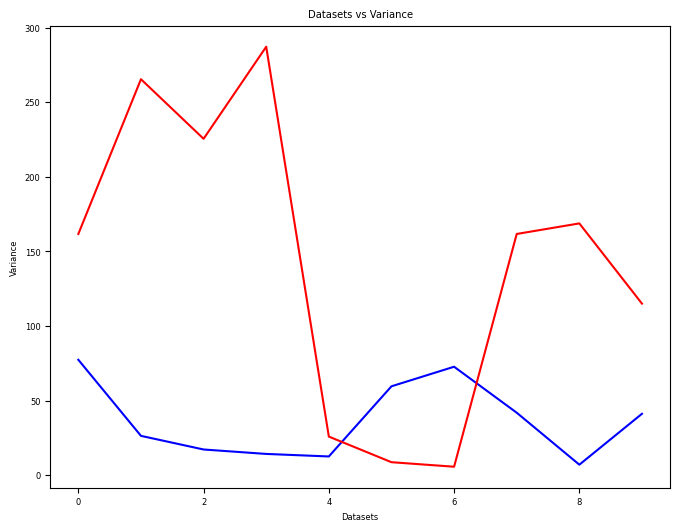

In [72]:
male_var = []
female_var = []

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    male_v = df[df.gender ==0].age.var()
    female_v = df[df.gender ==1].age.var()

    male_var.append(male_v)
    female_var.append(female_v)

test_male_var = test_df[test_df.gender ==0].age.var()
test_female_var = test_df[test_df.gender ==1].age.var()

val_male_df = test_df[test_df.gender ==0].age.var()
val_female_df = test_df[test_df.gender == 1].age.var()

plt.plot(range(len(male_var)), male_var, color  = "blue", label = "Male Variance")
plt.plot(range(len(female_var)), female_var, color = "red", label = "Female Variance")
plt.xlabel("Datasets")
plt.ylabel("Variance")
plt.title("Datasets vs Variance")
plt.savefig("Variance of Genders.png")
plt.show ()

# Forgetting Gender model

In [36]:
# Gender Forgetting Model
class Feature_Sieve_Gender(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Gender, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, 2)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = F.softmax(self.aux_fc(aux), dim = -1)
        
        return logits, aux

def fs_gender(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Gender(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [37]:
## Forget Loss: Margin Loss
def learn_main_gender(model, optim_main, x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux_gender(model, optim_main, optim_aux, x, y, alpha_aux = 1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux_gender(model, optim_forget, x):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux)/2)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()

In [38]:
def train_fs_gender(model, train_dataloader, val_dataloader, epochs = 100,  aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training model...............")
        
    train_losses= []
    val_losses = []
    aux_losses = []

    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y, gender = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)
            gender = gender.to(torch.long).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_gender(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_gender(model, optim_main, optim_aux, x, gender)
            if forget_iters and steps % forget_iters == 0:
                forget_aux_gender(model, optim_forget, x)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)
                
                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1
                aux_losses.append(aux_loss.detach().cpu())

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch+1}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses

In [ ]:
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
test_lossses =  []

for i in range(len(forget_lrs)):
    print("Forget LR", forgetl_lrs[i])
    model = fs_gender(1, False).to(device)
    model, train_losses, val_losses, _ = train_fs_gender(model, train_dataloaders[0], val_dataloader, epochs = 5, verbose = False, lrs = [5e-4, 5e-4, forget_lrs[i]])
    test_loss = eval_FSModel(model, test_dataloder)

    test_losses.append(test_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget LR: {best_forget_lr}")

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget iter:{forget_iters[i]}")
    model = fs_gender(1, False).to(device)
    model, train_losses, val_losses, _ = train_fs_gender(model, train_dataloaders[0], val_dataloader, epochs = 5, verbose = False, forget_iters = forget_iters[i], lrs = [5e-4, 5e-4, best_forget_lrs])
    test_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(test_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

In [51]:
#testing out model run
model = fs_gender(1, False).to(device)
model, train_losses, val_losses, _ = train_fs_gender(model, train_dataloaders[0], val_dataloader)
test_loss = eval_FSModel(model, test_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:11<00:00, 27.72s/it]


Test Loss: 164.5785369873047


In [ ]:
train_losses = []
val_losses = []
test_losses  = []

for i in range(len(train_dataloaders)):
    print(f"Training Dataset{i}: ")
    model = fs_margin(1, False).to(device)
    model, train_loss, val_loss, _ = train_fs_gender(model, train_dataloaders[i], val_dataloader, forget_iters = best_forget_iter, lrs = [5e-4, 5e-4, best_forget_lr], epochs = 100)
    test_loss = eval_FSModel(model, test_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

In [ ]:
for i in range(len(train_dataloaders)):
    plot_loss_curves(train_losses[i], val_losses[i], test_losses[i], model_name = f"Feature Sieve Gender Forgetting Dataset{i}")

## Checking for forgetting losses in Feature Sieve Models

In [39]:
def plot_aux_losses(aux_losses, model_name, forget_iters = 50):
    aux_losses = torch.tensor(aux_losses)
    plt.plot(range(aux_losses.shape[0]), aux_losses, color = "blue")
    plt.vlines(np.arange(0, aux_losses.shape[0], forget_iters), ymin = 0, ymax = aux_losses[np.arange(0,aux_losses.shape[0], 50)], color = "red")
    plt.xlabel("Epochs")
    plt.ylabel("Auxiliary loss")
    plt.title(model_name)
    plt.savefig(f"./{model_name}.png")
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [22:55<00:00, 27.51s/it]


Test Loss: 150.2161865234375


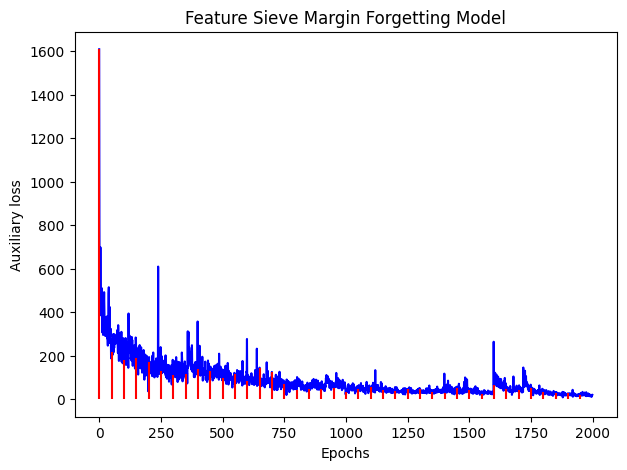

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [27:48<00:00, 33.37s/it]


Test Loss: 170.5046844482422


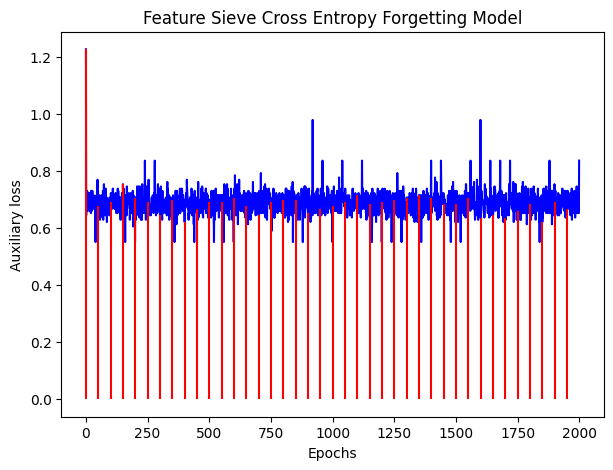

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [23:51<00:00, 28.63s/it]


Test Loss: 142.66183471679688


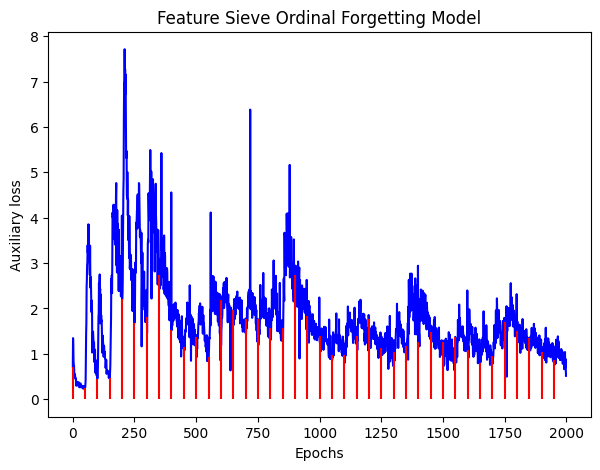

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [23:00<00:00, 27.61s/it]


Test Loss: 185.37350463867188


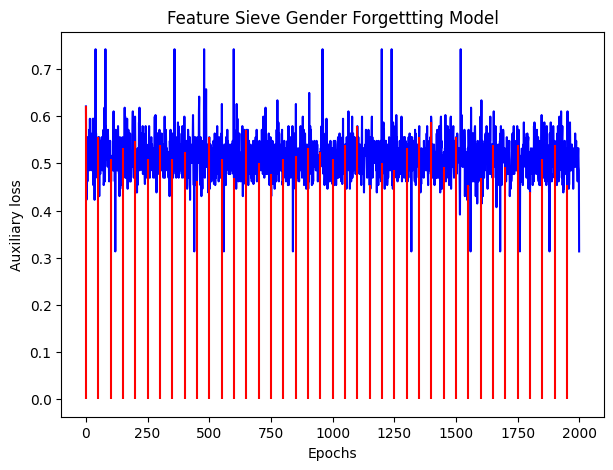

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:53<00:00, 28.74s/it]


NameError: name 'auc_losses' is not defined

In [40]:
# Feature Sieve Margin forgetting loss model
model = fs_margin(1, False).to(device)
model, train_losses, val_losses, aux_losses = train_fs_mar(model, train_dataloaders[0],  val_dataloader, epochs = 50, verbose=False, forget_iters = 50)
test_loss = eval_FSModel(model, test_dataloader)

plot_aux_losses(aux_losses, model_name = "Feature Sieve Margin Forgetting Model")

# Feature Sieve Cross Entropy Forgetting Loss Model
model = fs_ce(1, 3, False).to(device)
model, train_losses, val_losses, aux_losses = train_fs_ce(model, train_dataloaders[0], val_dataloader, age = ages, epochs = 50, verbose = False, forget_iters = 50, num_bins = 3)
test_loss = eval_FSModel(model, test_dataloader)

plot_aux_losses(aux_losses, model_name = "Feature Sieve Cross Entropy Forgetting Model")

# Feature Sieve Ordinal Forgetting Loss model
model = fs_ord(1, 100, False).to(device)
model, train_losses, val_losses, aux_losses = train_fs_ord(model, train_dataloaders[0], val_dataloader, epochs=50, verbose = False, forget_iters = 50, num_bins = 100)
test_loss = eval_FSModel(model, test_dataloader)

plot_aux_losses(aux_losses, model_name = "Feature Sieve Ordinal Forgetting Model")

# Forgettng gender model
model = fs_gender(1,False).to(device)
model, train_losses, val_losses, aux_losses = train_fs_gender(model, train_dataloaders[0], val_dataloader, epochs = 50, verbose = False, forget_iters = 50)
test_loss = eval_FSModel(model, test_dataloader)

plot_aux_losses(aux_losses, model_name = "Feature Sieve Gender Forgettting Model")

# Feature Sieve DYN Thresh model
model = fs_margin(1,False).to(device)
model, train_losses, val_losses = train_fs_thresh(model, train_dataloaders[0], val_dataloader, epochs = 50)
test_loss = eval_FSModel(model, test_dataloader)

plot_aux_losses(aux_losses, model_name = "Feature Sieve Dynamic Thresh Model")